In [1]:
# === Cell 0 (revised/final): imports + parameter loader + utils ===
from __future__ import annotations
from pathlib import Path
import os, re, json, types, time, warnings, math, hashlib
from collections import deque
from typing import List, Dict, Any
from datetime import datetime as _dt

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.utils.exceptions import AstropyUserWarning
from astropy.visualization import ZScaleInterval, ImageNormalize

# photutils 2.x
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

# 3rd
from scipy.spatial import cKDTree as KDTree

# ---- Warnings / BLAS guards ----
warnings.filterwarnings("once", category=AstropyUserWarning,
    message=r"Input data contains invalid values \(NaNs or infs\).*")
warnings.filterwarnings("ignore", message=".*'partition' will ignore the 'mask'.*")
warnings.filterwarnings("ignore", message="The deblending mode.*")

os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

# ---- NaN-safe gray colormap ----
CM_GRAY = mpl.cm.get_cmap('gray').copy()
CM_GRAY.set_bad((0.25,0.25,0.25,1.0))

# ---- Matplotlib ----
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 9
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['font.family'] = ['Malgun Gothic']
FIGSIZE = (6,5); DPI = 120

# ---- Jupyter backend ----
try:
    from IPython import get_ipython
    ip = get_ipython()
except Exception:
    ip = None
HAS_IPYMPL = False
if ip is not None:
    try:
        import ipympl  # noqa
        ip.run_line_magic("matplotlib", "widget")
        HAS_IPYMPL = True
    except Exception:
        try:
            ip.run_line_magic("matplotlib", "inline")
        except Exception:
            pass

# -------------------- Helpers --------------------
def _to_plain(a):
    if isinstance(a, np.ma.MaskedArray): 
        return a.filled(np.nan)
    return a

def _jsonify(o):
    if isinstance(o, (np.floating,)): return float(o)
    if isinstance(o, (np.integer,)):  return int(o)
    if isinstance(o, (np.bool_,)):    return bool(o)
    return o

def _is_up_to_date(target: Path, deps: List[Path]) -> bool:
    target = Path(target)
    if not target.exists(): 
        return False
    try:
        t = target.stat().st_mtime
        return all(Path(d).exists() and t >= Path(d).stat().st_mtime for d in deps)
    except Exception:
        return False

# ---- Tail logger ----
class TailLogger:
    def __init__(self, log_path: Path, tail: int = 5, enable_console: bool = True):
        self.log_path = Path(log_path)
        self.log_path.parent.mkdir(parents=True, exist_ok=True)
        self.fh = open(self.log_path, "a", encoding="utf-8")
        self.buf = deque(maxlen=max(1, tail))
        self.enable_console = enable_console
        try:
            from IPython.display import clear_output
            self._clear = lambda : clear_output(wait=True)
        except Exception:
            self._clear = lambda : None
    def write(self, msg: str):
        ts = time.strftime("%H:%M:%S")
        line = f"[{ts}] {msg}"
        self.fh.write(line + "\n"); self.fh.flush()
        if self.enable_console:
            self.buf.append(line); self._clear(); print("\n".join(self.buf))
    def close(self):
        try: self.fh.close()
        except: pass

# === FITS helpers ===
def get_exptime_from_fits(path: Path, default: float = 1.0) -> float:
    try:
        with fits.open(path) as hdul:
            return float(hdul[0].header.get("EXPTIME", default))
    except Exception:
        return default

def get_filter_from_fits(path: Path) -> str:
    """헤더 FILTER → 실패시 headers.csv/tsv 폴백. 반환은 소문자."""
    try:
        with fits.open(path) as hdul:
            f = hdul[0].header.get("FILTER", None)
            if f: return str(f).strip().lower()
    except Exception:
        pass

    base = Path(path).name
    if base.startswith("rc_"): base = base[3:]
    if base.startswith("r_"):  base = base[2:]

    try:
        if "df_headers" in globals() and df_headers is not None:
            row = df_headers[df_headers["Filename"] == base]
            if not row.empty:
                return str(row["FILTER"].values[0]).strip().lower()
    except Exception:
        pass
    return "unknown"

# ---- parameter loader ----
PARAM_PATH = Path("parameters.toml")  # 필요하면 "parameter.txt" 등으로 바꿔도 됨

def _as_bool(v, default=False):
    if v is None: 
        return default
    return str(v).strip().lower() in ("1","true","yes","y","on")

def _as_float_or_none(v):
    try:
        s = str(v).strip()
        return float(s) if s != "" else None
    except:
        return None

def _read_kv_lines(path: Path) -> Dict[str, str]:
    d={}
    if path.exists():
        for line in path.read_text(encoding="utf-8").splitlines():
            s=line.strip()
            if (not s) or s.startswith("#"): 
                continue
            if "#" in s: 
                s=s.split("#",1)[0].strip()
            if "=" in s:
                k,v=[t.strip() for t in s.split("=",1)]
                d[k]=v
    return d

def _getf(raw, key, default):
    s = str(raw.get(key, "")).strip()
    try:
        return default if s=="" else float(s)
    except:
        return default

def _geti(raw, key, default):
    s = str(raw.get(key, "")).strip()
    try:
        if s == "": return default
        return int(float(s))
    except:
        return default

def read_params(path: Path):
    raw = _read_kv_lines(path)

    # --- rdnoise 강제: 허용 키 중 하나는 반드시 있어야 함 ---
    rdnoise_candidate = (
        _as_float_or_none(raw.get("rdnoise_e",""))
        or _as_float_or_none(raw.get("datapar.readnoise",""))
        or _as_float_or_none(raw.get("readnoise_e",""))
    )
    if rdnoise_candidate is None:
        raise RuntimeError(
            "[parameter.txt] read noise 값이 필요합니다.\n"
            "  허용 키: rdnoise_e 또는 datapar.readnoise 또는 readnoise_e\n"
            "  예) rdnoise_e = 1.39   # electrons"
        )

    P = types.SimpleNamespace(
        # I/O
        data_dir          = raw.get("data_dir", "."),
        filename_prefix   = raw.get("filename_prefix", "pp_"),
        # ★ 기존 오타 수정: result_dir 키는 'result_dir'
        result_dir        = raw.get("result_dir", ""),
        cache_dir         = raw.get("cache_dir", "cache"),

        # 병렬
        parallel_mode     = raw.get("parallel_mode", "thread"),
        max_workers       = _geti(raw, "max_workers", 0),   # 0 → auto
        ui_log_tail       = _geti(raw, "ui_log_tail", 300),
        resume_mode       = _as_bool(raw.get("resume_mode","true"), True),
        force_redetect    = _as_bool(raw.get("force_redetect","false"), False),
        force_rephot      = _as_bool(raw.get("force_rephot","false"), False),
        detect_cache_strategy = raw.get("detect_cache_strategy","mtime"),
        detect_progress_bar   = _as_bool(raw.get("detect_progress_bar","true"), True),

        align_ref_index = _geti(raw,"align_ref_index",0),
        global_align = _as_bool(raw.get("global_align","true"), True),
        global_ref_filter = raw.get("global_ref_filter","r"),
        global_ref_index = _geti(raw,"global_ref_index",0),

        # 스케일/PSF/FWHM
        # (pixel scale은 Cell 1에서 instrument 계산값으로만 세팅)
        # pixel_scale_arcsec  # Removed: Use calculated PIX_SCALE_BIN instead
        fwhm_pix_guess     = _as_float_or_none(raw.get("fwhm_pix_guess","")),
        fwhm_guess_arcsec  = _as_float_or_none(raw.get("fwhm_guess_arcsec","")),
        fwhm_arcsec_min    = _as_float_or_none(raw.get("fwhm_arcsec_min","")),
        fwhm_arcsec_max    = _as_float_or_none(raw.get("fwhm_arcsec_max","")),
        fwhm_px_min        = _getf(raw,"fwhm_px_min", 3.5),
        fwhm_px_max        = _getf(raw,"fwhm_px_max", 12.0),
        fwhm_qc_max_sources= _geti(raw,"fwhm_qc_max_sources", 40),
        fwhm_elong_max     = _getf(raw,"fwhm_elong_max", 1.3),
        iso_min_sep_pix    = _getf(raw,"iso_min_sep_pix", 18.0),

        # 검출
        detect_engine      = raw.get("detect_engine","segm"),
        detect_sigma       = _getf(raw,"detect_sigma", 3.2),
        detect_sigma_g     = _as_float_or_none(raw.get("detect_sigma_g","")),
        detect_sigma_r     = _as_float_or_none(raw.get("detect_sigma_r","")),
        detect_sigma_i     = _as_float_or_none(raw.get("detect_sigma_i","")),
        minarea_pix        = _geti(raw,"minarea_pix", 3),
        deblend_enable     = _as_bool(raw.get("deblend_enable","true"), True),
        deblend_nthresh    = _geti(raw,"deblend_nthresh", 64),
        deblend_cont       = _getf(raw,"deblend_cont", 0.0025),
        segm_dilate_radius_px = _geti(raw,"segm_dilate_radius_px", 4),

        # 배경/클리핑/데이터범위
        bkg2d_in_detect    = _as_bool(raw.get("bkg2d_in_detect","true"), True),
        bkg2d_box          = _geti(raw,"bkg2d_box", 64),
        bkg2d_filter_size  = _geti(raw,"bkg2d_filter_size", 3),
        bkg2d_edge_method  = raw.get("bkg2d_edge_method", "pad"),
        bkg2d_method       = raw.get("bkg2d_method", "median"),

        # 게이트/QC
        gate_enable        = _as_bool(raw.get("gate_enable","true"), True),

        # 포토/아뉴러스 스케일
        phot_aperture_scale   = _getf(raw,"phot_aperture_scale", 1.0),
        fitsky_annulus_scale  = _getf(raw,"fitsky_annulus_scale", 4.0),
        fitsky_dannulus_scale = _getf(raw,"fitsky_dannulus_scale", 2.0),
        center_cbox_scale     = _getf(raw,"center_cbox_scale", 1.5),
        annulus_min_gap_px    = _getf(raw,"annulus_min_gap_px", 6.0),
        annulus_min_width_px  = _getf(raw,"annulus_min_width_px", 12.0),

        # Zero point / 카메라
        saturation_adu     = _getf(raw,"saturation_adu", 60000.0),
        gain_e_per_adu     = _getf(raw,"gain_e_per_adu", 0.1),
        # ★ 실제 값은 rdnoise_candidate로 확정
        rdnoise_e          = float(rdnoise_candidate),
        zp_initial         = _getf(raw,"zp_initial", 25.0),

        # 5X HUD
        _hud5 = {
            "5x.aperture_scale":       raw.get("5x.aperture_scale",""),
            "5x.center_cbox_scale":    raw.get("5x.center_cbox_scale",""),
            "5x.annulus_in_scale":     raw.get("5x.annulus_in_scale",""),
            "5x.annulus_out_scale":    raw.get("5x.annulus_out_scale",""),
            "5x.min_r_ap_px":          raw.get("5x.min_r_ap_px",""),
            "5x.min_r_in_px":          raw.get("5x.min_r_in_px",""),
            "5x.min_r_out_px":         raw.get("5x.min_r_out_px",""),
            "5x.sigma_clip":           raw.get("5x.sigma_clip",""),
            "5x.neighbor_mask_scale":  raw.get("5x.neighbor_mask_scale",""),
            "5x.mag_flux":             raw.get("5x.mag_flux","rate_e"),
            "5x.use_header_exptime":   raw.get("5x.use_header_exptime","true"),
        },

        # 11번셀 관련 플래그
        aperture_mode              = raw.get("aperture_mode","apcorr"),
        annulus_neighbor_mask_scale= _getf(raw,"annulus_neighbor_mask_scale", 1.3),
        recenter_aperture          = _as_bool(raw.get("recenter_aperture","true"), True),
        bkg_use_segm_mask          = _as_bool(raw.get("bkg_use_segm_mask","true"), True),
        min_snr_for_mag            = _getf(raw,"min_snr_for_mag", 3.0),
    )

    # raw 보존 (호환 접근용)
    P._raw = raw

    # result/cache dirs
    P.data_dir   = Path(P.data_dir)
    P.result_dir = Path(P.result_dir) if P.result_dir else (P.data_dir / "result")
    P.result_dir.mkdir(parents=True, exist_ok=True)
    P.cache_dir  = (P.result_dir / str(P.cache_dir))
    P.cache_dir.mkdir(parents=True, exist_ok=True)

    # FWHM seed(px): 여기서는 legacy(px)만 확정. arcsec 변환은 Cell 1에서 수행.
    pix_legacy = P.fwhm_pix_guess
    P.fwhm_seed_px = float(pix_legacy if pix_legacy is not None else 6.0)
    P._fwhm_seed_from = "pixel-legacy"

    return P

def _param_hash(path=PARAM_PATH):
    try:
        txt = Path(path).read_text(encoding="utf-8", errors="ignore")
        lines=[]
        for ln in txt.splitlines():
            s=ln.strip()
            if (not s) or s.startswith("#"): 
                continue
            if "#" in s: 
                s=s.split("#",1)[0].strip()
            lines.append(s)
        norm = "\n".join(lines).encode("utf-8")
        return hashlib.sha1(norm).hexdigest()
    except Exception:
        return "NO_PARAM"

# ---- bootstrap ----
CODE_VER = "pipeline-2025-10-29-rdnoise-param-required"
P = read_params(PARAM_PATH)
DATA_DIR, RESULT_DIR, CACHE_DIR = P.data_dir, P.result_dir, P.cache_dir
PARAM_HASH = _param_hash()

def print_bootstrap_summary(P):
    print("\n==================== PARAM SUMMARY ====================")
    print(f"DATA_DIR      : {P.data_dir}")
    print(f"RESULT_DIR    : {P.result_dir}")
    print(f"CACHE_DIR     : {P.cache_dir}")
    print(f"resume_mode   : {P.resume_mode} | force_redetect={P.force_redetect} | force_rephot={P.force_rephot}")
    print(f"parallel_mode : {P.parallel_mode} | max_workers={P.max_workers}")
    print(f"FWHM seed     : {P.fwhm_seed_px:.2f} px (from={getattr(P,'_fwhm_seed_from','?')})")
    print(f"FWHM range    : {P.fwhm_px_min:.2f} ~ {P.fwhm_px_max:.2f} px | elong_max={P.fwhm_elong_max} | iso_min_sep={P.iso_min_sep_pix}px")

    print(f"bkg2d detect  : {P.bkg2d_in_detect} | box={P.bkg2d_box}")
    print(f"detect_sigma  : base={P.detect_sigma} | g={P.detect_sigma_g} r={P.detect_sigma_r} i={P.detect_sigma_i}")
    print(f"deblend       : enable={P.deblend_enable} nthresh={P.deblend_nthresh} cont={P.deblend_cont} dilate={P.segm_dilate_radius_px}")

    print(f"clip          : sat_adu={P.saturation_adu}")
    print(f"camera        : gain={P.gain_e_per_adu} e-/ADU | rdnoise={P.rdnoise_e} e- | zp_init={P.zp_initial}")
    print("=======================================================\n")

print_bootstrap_summary(P)

# ---- optional headers.csv/tsv resolver (for FILTER lookup) ----
df_headers = None
for hp in (RESULT_DIR/"headers.csv", DATA_DIR/"headers.csv",
           RESULT_DIR/"headers.tsv", DATA_DIR/"headers.tsv"):
    if hp.exists():
        try:
            sep = "\t" if hp.suffix.lower()==".tsv" else ","
            df_headers = pd.read_csv(hp, sep=sep)
            df_headers.columns = [str(c).strip() for c in df_headers.columns]
            if "Filename" not in df_headers.columns:
                for cand in ("filename","FILE","File","name","Name"):
                    if cand in df_headers.columns:
                        df_headers.rename(columns={cand:"Filename"}, inplace=True)
                        break
            if "FILTER" not in df_headers.columns:
                for cand in ("Filter","filter","FILTER1","FILTER2"):
                    if cand in df_headers.columns:
                        df_headers.rename(columns={cand:"FILTER"}, inplace=True)
                        break
            print(f"Loaded headers: {hp.name} (rows={len(df_headers)})")
            break
        except Exception as e:
            print(f"headers load failed: {hp.name} → {e}")
            df_headers = None

df_header = df_headers  # legacy typo compatibility

# ---- Compatibility accessor for later cells ----
def _pget(name: str, default=None):
    """
    호환용 파라미터 접근자.
    1) P의 속성 → 2) P._raw의 원문 키 → 3) default
    """
    if hasattr(P, name):
        val = getattr(P, name)
        if not (val is None or (isinstance(val, str) and val.strip()=="")):
            return val
    if hasattr(P, "_raw") and name in P._raw:
        rawv = P._raw[name]
        if isinstance(default, bool):
            return _as_bool(rawv, default)
        if isinstance(default, int):
            fv = _as_float_or_none(rawv)
            return int(fv) if fv is not None else default
        if isinstance(default, float):
            fv = _as_float_or_none(rawv)
            return fv if fv is not None else default
        return rawv
    return default



==================== PARAM SUMMARY ====================
DATA_DIR      : C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38
RESULT_DIR    : C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result
CACHE_DIR     : C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\cache
resume_mode   : True | force_redetect=False | force_rephot=False
parallel_mode : auto | max_workers=0
FWHM seed     : 6.00 px (from=pixel-legacy)
FWHM range    : 3.00 ~ 10.00 px | elong_max=1.3 | iso_min_sep=10.0px
bkg2d detect  : True | box=64
detect_sigma  : base=3.2 | g=3.4 r=3.2 i=3.0
deblend       : enable=True nthresh=64 cont=0.004 dilate=4
clip          : sat_adu=65000.0
camera        : gain=0.1 e-/ADU | rdnoise=1.39 e- | zp_init=25.0

Loaded headers: headers.csv (rows=9)


C:\Users\bmffr\AppData\Local\Temp\ipykernel_10608\2720322986.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CM_GRAY = mpl.cm.get_cmap('gray').copy()


In [2]:
# === Cell 1 (Telescope/Camera 설정 + FOV/Pixel scale + LimMag helper + SIMBAD) ===
from astropy.coordinates import SkyCoord
import astropy.units as u

_raw = getattr(P, "_raw", {})  # ★ NameError 방지

# astroquery.simbad 는 있으면 사용, 없으면 우회
try:
    from astroquery.simbad import Simbad
    _HAS_SIMBAD = True
except Exception as e:
    print("[SIMBAD] astroquery.simbad import 실패 → SIMBAD 사용 불가:", e)
    _HAS_SIMBAD = False

# -----------------------------------------------------------------------------
# 1. 망원경/카메라 하드웨어 설정 (CDK500 + Moravian C3-61000)
# -----------------------------------------------------------------------------
TELESCOPE_NAME   = "Planewave CDK500"
APERTURE_MM      = 500.0
FOCAL_LENGTH_MM  = 3947.0
FOCAL_RATIO      = FOCAL_LENGTH_MM / APERTURE_MM

CAMERA_NAME      = "Moravian C3-61000"
PIX_SIZE_UM      = 3.76
SENSOR_W_MM      = 36.01
SENSOR_H_MM      = 24.02
SENSOR_NX_1X     = 9576
SENSOR_NY_1X     = 6388

# binning default (파라미터 있으면 그거, 없으면 2)
try:
    BIN_DEFAULT = int(float(getattr(P, "binning_default", 2) or 2))
except Exception:
    BIN_DEFAULT = 2

# -----------------------------------------------------------------------------
# 2. Pixel scale / FOV 계산 (instrument 값만 사용)
# -----------------------------------------------------------------------------
def _pixel_scale_arcsec(pixel_size_um: float, focal_length_mm: float, binning: int = 1) -> float:
    return 206.265 * pixel_size_um * float(binning) / float(focal_length_mm)

def _fov_deg(sensor_mm: float, focal_length_mm: float) -> float:
    return 57.2957795 * sensor_mm / float(focal_length_mm)

PIX_SCALE_1X = _pixel_scale_arcsec(PIX_SIZE_UM, FOCAL_LENGTH_MM, binning=1)
FOV_W_1X_DEG = _fov_deg(SENSOR_W_MM, FOCAL_LENGTH_MM)
FOV_H_1X_DEG = _fov_deg(SENSOR_H_MM, FOCAL_LENGTH_MM)

PIX_SCALE_BIN = _pixel_scale_arcsec(PIX_SIZE_UM, FOCAL_LENGTH_MM, binning=BIN_DEFAULT)

# ★ pixel scale은 parameter가 아니라 여기서 계산한 값만 사용
P.pixel_scale_arcsec = float(PIX_SCALE_BIN)
_PIX_SCALE_SOURCE = "instrument"
print(f"[Camera] pixel scale = {P.pixel_scale_arcsec:.6f}\"/pix (bin={BIN_DEFAULT}x{BIN_DEFAULT})")

# arcsec → px 변환 (pixel scale 확정 이후에만!)
arc = getattr(P, "fwhm_guess_arcsec", None)
if arc is not None and np.isfinite(arc) and arc > 0:
    P.fwhm_seed_px = max(2.0, float(arc) / P.pixel_scale_arcsec)
    P._fwhm_seed_from = "arcsec"

arcmin = getattr(P, "fwhm_arcsec_min", None)
if arcmin is not None and np.isfinite(arcmin):
    P.fwhm_px_min = max(float(P.fwhm_px_min), float(arcmin) / P.pixel_scale_arcsec)

arcmax = getattr(P, "fwhm_arcsec_max", None)
if arcmax is not None and np.isfinite(arcmax):
    P.fwhm_px_max = min(float(P.fwhm_px_max), float(arcmax) / P.pixel_scale_arcsec)

# param에 pixel_scale_arcsec가 있어도 무시한다는 경고(선택)
ps_in_param = str(_raw.get("pixel_scale_arcsec","")).strip()
if ps_in_param:
    print(f"[주의] parameter.txt의 pixel_scale_arcsec={ps_in_param} 은(는) 무시됨 → instrument 계산값 사용")

# -----------------------------------------------------------------------------
# 3. 한계등급 helper
# -----------------------------------------------------------------------------
def estimate_limiting_mag(
    zp: float,
    exptime_s: float,
    fwhm_arcsec: float,
    sky_sigma_e_per_px: float,
    pix_scale_arcsec: float,
    snr_limit: float = 5.0,
    rdnoise_e: float | None = None,
) -> float:
    if rdnoise_e is None:
        rdnoise_e = float(getattr(P, "rdnoise_e", 7.5))

    if pix_scale_arcsec <= 0:
        raise ValueError("pix_scale_arcsec > 0 이어야 합니다.")

    r_fwhm_px = (fwhm_arcsec / pix_scale_arcsec) / 2.0
    A_psf = math.pi * max(r_fwhm_px, 0.5)**2

    sky_e_per_px = sky_sigma_e_per_px**2

    def snr_for_mag(m: float) -> float:
        rate_e = 10.0**(-0.4 * (m - zp))
        N_star = rate_e * exptime_s
        N_sky  = sky_e_per_px * A_psf
        N_RN2  = (rdnoise_e**2) * A_psf
        var    = max(N_star + N_sky + N_RN2, 1e-12)
        return N_star / math.sqrt(var)

    m_min = zp - 5.0
    m_max = zp + 20.0
    s_min = snr_for_mag(m_min)
    s_max = snr_for_mag(m_max)

    if s_min < snr_limit:
        return m_min
    if s_max > snr_limit:
        return m_max

    for _ in range(60):
        m_mid = 0.5 * (m_min + m_max)
        s_mid = snr_for_mag(m_mid)
        if s_mid > snr_limit:
            m_min = m_mid
        else:
            m_max = m_mid
        if abs(m_max - m_min) < 1e-3:
            break
    return 0.5 * (m_min + m_max)

def _get_float_from_raw(key: str, default: float | None = None):
    v = _raw.get(key, "")
    s = str(v).strip()
    if s == "":
        return default
    try:
        return float(s)
    except Exception:
        return default

_lim_exptime_s      = _get_float_from_raw("lim_exptime_s", None)
_lim_fwhm_arcsec    = _get_float_from_raw("lim_fwhm_arcsec", None)
_lim_sky_sigma_e    = _get_float_from_raw("lim_sky_sigma_e", None)
_lim_snr            = _get_float_from_raw("lim_snr_limit", 5.0)
_zp_for_lim         = float(getattr(P, "zp_initial", 25.0))

# -----------------------------------------------------------------------------
# 4. SIMBAD 대상 찾기 + targets.txt 연동
# -----------------------------------------------------------------------------
TARGET_LIST_PATH = DATA_DIR / "targets.txt"

raw_targets: list[str] = []
tn_param = _raw.get("target_name", None)
if tn_param is not None and str(tn_param).strip():
    raw_targets.append(str(tn_param).strip())

if TARGET_LIST_PATH.exists():
    for line in TARGET_LIST_PATH.read_text(encoding="utf-8").splitlines():
        s = line.strip()
        if (not s) or s.startswith("#"):
            continue
        raw_targets.append(s)

if not raw_targets:
    raw_targets = ["M31"]

seen = set()
targets: list[str] = []
for name in raw_targets:
    if name not in seen:
        seen.add(name)
        targets.append(name)

targets_resolved: list[dict] = []
PRIMARY_TARGET = None
PRIMARY_COORD  = None

if _HAS_SIMBAD:
    Simbad.reset_votable_fields()
    Simbad.add_votable_fields("ra(d)", "dec(d)", "flux(V)", "otype")

    print("\n=== SIMBAD 대상 해결 시작 ===")
    for name in targets:
        try:
            res = Simbad.query_object(name)
            if res is None or len(res) == 0:
                print(f"[SIMBAD] Not found: {name}")
                continue

            ra_deg  = float(res["RA_d"][0])
            dec_deg = float(res["DEC_d"][0])
            ra_str  = str(res["RA"][0])
            dec_str = str(res["DEC"][0])
            vmag    = float(res["FLUX_V"][0]) if "FLUX_V" in res.colnames else np.nan
            otype   = str(res["OTYPE"][0]) if "OTYPE" in res.colnames else ""

            rec = dict(name=name, ra_deg=ra_deg, dec_deg=dec_deg,
                       ra_str=ra_str, dec_str=dec_str, vmag=vmag, otype=otype)
            targets_resolved.append(rec)

            print(f"[SIMBAD] {name:20s} → RA={ra_str}  DEC={dec_str}  "
                  f"({ra_deg:9.5f}°, {dec_deg:9.5f}°)  V~{vmag if np.isfinite(vmag) else 'n/a'}  [{otype}]")

        except Exception as e:
            print(f"[SIMBAD] ERROR for '{name}': {e}")

    if targets_resolved:
        PRIMARY_TARGET = targets_resolved[0]["name"]
        PRIMARY_COORD  = SkyCoord(targets_resolved[0]["ra_deg"], targets_resolved[0]["dec_deg"], unit="deg")
        out = RESULT_DIR / "targets_simbad.tsv"
        pd.DataFrame(targets_resolved).to_csv(out, sep="\t", index=False)
        print(f"→ SIMBAD 결과 저장: {out}")
    else:
        print("SIMBAD에서 성공적으로 해결된 타깃이 없습니다.")
else:
    print("\n[SIMBAD] astroquery 미설치/오류로 SIMBAD 해석은 건너뜁니다.")
    PRIMARY_TARGET = targets[0]
    PRIMARY_COORD  = None

# -----------------------------------------------------------------------------
# 5. 요약 출력 + (옵션) 한계등급 계산
# -----------------------------------------------------------------------------
print("\n=== Instrument summary (CDK500 + C3-61000) ===")
print(f"Telescope : {TELESCOPE_NAME}")
print(f"  Aperture D = {APERTURE_MM:.1f} mm")
print(f"  Focal length F = {FOCAL_LENGTH_MM:.1f} mm  (f/{FOCAL_RATIO:.2f})")
print(f"Camera    : {CAMERA_NAME}")
print(f"  Pixel size (1x1) = {PIX_SIZE_UM:.3f} μm")
print(f"  Sensor = {SENSOR_W_MM:.2f} × {SENSOR_H_MM:.2f} mm  "
      f"({SENSOR_NX_1X} × {SENSOR_NY_1X} px @1x1)")
print(f"Default binning = {BIN_DEFAULT}×{BIN_DEFAULT}")
print(f"Pixel scale (1x1)  ≈ {PIX_SCALE_1X:.6f} \" / px")
print(f"Pixel scale ({BIN_DEFAULT}x{BIN_DEFAULT}) ≈ {PIX_SCALE_BIN:.6f} \" / px  "
      f"(pipeline pixel_scale_arcsec={P.pixel_scale_arcsec:.6f} \" / px, source={_PIX_SCALE_SOURCE})")
print(f"Full FOV (sensor, any binning) ≈ {FOV_W_1X_DEG:.3f} × {FOV_H_1X_DEG:.3f} deg")

if PRIMARY_TARGET is not None:
    if PRIMARY_COORD is not None:
        ra_hms = PRIMARY_COORD.ra.to_string(unit=u.hour, sep=":", precision=2)
        dec_dms= PRIMARY_COORD.dec.to_string(unit=u.deg, sep=":", precision=1, alwayssign=True)
        print(f"\nPRIMARY TARGET: {PRIMARY_TARGET}  (RA={ra_hms}, DEC={dec_dms})")
    else:
        print(f"\nPRIMARY TARGET (이름만): {PRIMARY_TARGET}")

if (_lim_exptime_s is not None) and (_lim_fwhm_arcsec is not None) and (_lim_sky_sigma_e is not None):
    try:
        m_lim = estimate_limiting_mag(
            zp=_zp_for_lim,
            exptime_s=_lim_exptime_s,
            fwhm_arcsec=_lim_fwhm_arcsec,
            sky_sigma_e_per_px=_lim_sky_sigma_e,
            pix_scale_arcsec=float(P.pixel_scale_arcsec),
            snr_limit=float(_lim_snr),
            rdnoise_e=float(getattr(P, "rdnoise_e", 7.5)),
        )
        print(f"\n[Limiting mag] exptime={_lim_exptime_s:.1f}s, FWHM={_lim_fwhm_arcsec:.2f}\", "
              f"sky_sigma={_lim_sky_sigma_e:.2f} e-/px, SNR={_lim_snr:.1f} 기준")
        print(f"  → 대략적인 한계등급 m_lim ≈ {m_lim:.2f} mag (ZP={_zp_for_lim:.2f})")
    except Exception as e:
        print("[Limiting mag] 계산 중 오류:", e)
else:
    print("\n[Limiting mag] parameter.txt에 다음 키를 넣으면 자동 계산됩니다:")
    print("  lim_exptime_s      = (예: 300)      # 단일 프레임 노출시간 [s]")
    print("  lim_fwhm_arcsec    = (예: 2.0)      # seeing FWHM [arcsec]")
    print("  lim_sky_sigma_e    = (예: 15.0)     # sky sigma [e-/px] (frame_sky_sigma.csv 값)")
    print("  lim_snr_limit      = (선택, 예: 5.0) # SNR 한계 (기본 5σ)")


[Camera] pixel scale = 0.392985"/pix (bin=2x2)

=== SIMBAD 대상 해결 시작 ===
[SIMBAD] M38                  → RA=05 28 40.0  DEC=+35 49 08  ( 82.16670°,  35.81890°)  V~6.400000095367432  [OpenCluster]
→ SIMBAD 결과 저장: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\targets_simbad.tsv

=== Instrument summary (CDK500 + C3-61000) ===
Telescope : Planewave CDK500
  Aperture D = 500.0 mm
  Focal length F = 3947.0 mm  (f/7.89)
Camera    : Moravian C3-61000
  Pixel size (1x1) = 3.760 μm
  Sensor = 36.01 × 24.02 mm  (9576 × 6388 px @1x1)
Default binning = 2×2
Pixel scale (1x1)  ≈ 0.196493 " / px
Pixel scale (2x2) ≈ 0.392985 " / px  (pipeline pixel_scale_arcsec=0.392985 " / px, source=instrument)
Full FOV (sensor, any binning) ≈ 0.523 × 0.349 deg

PRIMARY TARGET: M38  (RA=5:28:40.01, DEC=+35:49:08.0)

[Limiting mag] parameter.txt에 다음 키를 넣으면 자동 계산됩니다:
  lim_exptime_s      = (예: 300)      # 단일 프레임 노출시간 [s]
  lim_fwhm_arcsec    = (예: 2.0)      # seeing FWHM [arcsec]
  lim_sky_si

In [3]:
# === Cell 2: 파일 리스트 ===
filenames = sorted([
    f for f in os.listdir(DATA_DIR)
    if f.startswith(P.filename_prefix) and f.lower().endswith((".fit", ".fits", ".fit.fz", ".fits.fz"))
])
(RESULT_DIR / "target_list.txt").write_text("\n".join(filenames), encoding="utf-8")
print(f"총 {len(filenames)}개 파일 → {RESULT_DIR/'target_list.txt'}")
if not filenames:
    raise RuntimeError("입력 파일 없음")


총 9개 파일 → C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\target_list.txt


In [4]:
# === Cell 3: 헤더 읽기 (ref 또는 첫 파일만 미리보기) ===
rows = []
for fn in filenames:
    try:
        with fits.open(DATA_DIR / fn) as hdul:
            h = hdul[0].header
            data = hdul[0].data
        bitpix = h.get("BITPIX", None)
        dtype = str(getattr(data, "dtype", "None"))
        if data is None:
            vmin = vmax = vmed = float('nan')
        else:
            finite = np.isfinite(data)
            vals = data[finite] if finite.any() else data.ravel()
            vmin = float(np.min(vals))
            vmax = float(np.max(vals))
            vmed = float(np.median(vals))
        rows.append({
            "Filename": fn,
            "DATE-OBS": h.get("DATE-OBS", "N/A"),
            "FILTER"  : h.get("FILTER", "UNKNOWN"),
            "EXPTIME" : h.get("EXPTIME", "N/A"),
            "AIRMASS" : h.get("AIRMASS", ""),
            "IMAGETYP": h.get("IMAGETYP", h.get("FRAME", "Unknown")),
            "BITPIX" : bitpix,
            "DTYPE"  : dtype,
            "MIN"    : vmin,
            "MAX"    : vmax,
            "MEDIAN" : vmed,
        })
    except Exception as e:
        print(f"⚠️ {fn}: 헤더 실패 → {e}")

df_headers = pd.DataFrame(rows)
df_headers.to_csv(RESULT_DIR/"headers.csv", index=False, encoding="utf-8")
print("Saved:", RESULT_DIR/"headers.csv", "| rows:", len(df_headers))

# ref 후보 선택: global_ref_filter 우선, 아니면 첫 파일
ref_candidates = df_headers
grf = str(getattr(P, "global_ref_filter", "")).lower()
if grf in ("g","r","i"):
    ref_candidates = df_headers[df_headers["FILTER"].astype(str).str.lower()==grf]
ref_name = ref_candidates.iloc[max(0, min(int(getattr(P,"global_ref_index",0) or 0), len(ref_candidates)-1))]["Filename"] \
           if not ref_candidates.empty else filenames[0]

print(f"미리보기 헤더: {ref_name}")
with fits.open(DATA_DIR / ref_name) as hdul:
    print(repr(hdul[0].header))


Saved: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\headers.csv | rows: 9
미리보기 헤더: calibrated_M38-0001-r.fit
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4788                                                  
NAXIS2  =                 3194                                                  
DATE-OBS= '2024-12-31T17:04:10' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   8.0000000000000000 /Exposure time in seconds                        
EXPOSURE=   8.0000000000000000 /Exposure time in seconds                        
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -14.967605590820313 /CCD temperature at start of exposure in C       
XPIXSZ  =   7.5199999999999996 /Pixel Width in micro

In [5]:
# === Cell 4 (NEW): CROP 선택/저장 (rect만; resume 시 스킵) ===
import os, json, hashlib
from ipywidgets import HTML, VBox
from matplotlib.widgets import RectangleSelector
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize

# --- 입력 파일 리스트 확보 ---
try:
    _target_filenames = list(filenames)
except NameError:
    tl = RESULT_DIR / "target_list.txt"
    if tl.exists():
        _target_filenames = [l.strip() for l in tl.read_text(encoding="utf-8").splitlines() if l.strip()]
    else:
        raise RuntimeError("타겟 파일 목록이 없습니다. Cell 2(파일 리스트)를 먼저 실행하세요.")

if not _target_filenames:
    raise RuntimeError("입력 파일 목록이 비어 있습니다. Cell 2 결과를 확인하세요.")

crop_path    = RESULT_DIR / "crop_rect.json"
RESUME       = bool(getattr(P, "resume_mode", True))
FORCE_RECROP = bool(getattr(P, "force_recrop", False))

# Crop_* 존재 여부
has_crop = any(
    f.startswith("Crop_") and f.lower().endswith((".fit", ".fits", ".fit.fz", ".fits.fz"))
    for f in os.listdir(RESULT_DIR)
)

def _rect_hash(d: dict) -> str:
    core = {k:int(d[k]) for k in ("x0","y0","x1","y1") if k in d}
    s = json.dumps(core, sort_keys=True).encode("utf-8")
    return hashlib.sha1(s).hexdigest()

if RESUME and (not FORCE_RECROP) and crop_path.exists() and has_crop:
    try:
        crop = json.loads(crop_path.read_text(encoding="utf-8"))
        print(f"↩︎ 기존 CROP 유지 (crop_rect.json 재사용): {crop_path}")
        print(
            f"   x=[{crop.get('x0')}:{crop.get('x1')}) "
            f"y=[{crop.get('y0')}:{crop.get('y1')})  ref_file={crop.get('ref_file')}  RECTH={_rect_hash(crop)}"
        )
    except Exception:
        print(f"↩︎ crop_rect.json 파싱 실패 → 다시 선택: {crop_path}")
else:
    ref_idx  = int(getattr(P, "crop_ref_index", getattr(P, "align_ref_index", 0)))
    ref_idx  = max(0, min(ref_idx, len(_target_filenames)-1))
    ref_file = _target_filenames[ref_idx]

    img = fits.getdata(DATA_DIR / ref_file).astype(float)

    interval = ZScaleInterval(); vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)

    plt.ioff()
    fig, ax = plt.subplots(figsize=(7,7), dpi=110)
    ax.imshow(img, cmap="gray", origin="lower", norm=norm)
    ax.set_title(f"[CROP 선택] {ref_file} — 드래그 후 Enter 저장", fontsize=11)

    CROP = {
        "x0": 0, "y0": 0,
        "x1": img.shape[1], "y1": img.shape[0],
        "ref_file": ref_file,
    }

    info = HTML("<b>Tip:</b> 마우스로 드래그 → <b>Enter</b>로 확정/저장 (crop_rect.json)")

    def onselect(eclick, erelease):
        if (eclick.xdata is None) or (erelease.xdata is None):
            return
        x0 = int(min(eclick.xdata, erelease.xdata))
        x1 = int(max(eclick.xdata, erelease.xdata))
        y0 = int(min(eclick.ydata,  erelease.ydata))
        y1 = int(max(eclick.ydata,  erelease.ydata))

        H, W = img.shape
        x0 = max(0, min(W-1, x0)); x1 = max(1, min(W, x1))
        y0 = max(0, min(H-1, y0)); y1 = max(1, min(H, y1))

        CROP.update(dict(x0=x0, y0=y0, x1=x1, y1=y1))
        info.value = f"선택: x=[{x0}:{x1}) y=[{y0}:{y1}) → W={x1-x0}, H={y1-y0}"

    def on_key(event):
        if event.key in ("enter", "return"):
            crop_path.write_text(json.dumps(CROP, indent=2, default=_jsonify), encoding="utf-8")
            info.value = (
                f"✅ CROP 저장: {crop_path}  "
                f"(x0={CROP['x0']}, y0={CROP['y0']}, x1={CROP['x1']}, y1={CROP['y1']}) "
                f"RECTH={_rect_hash(CROP)}"
            )
            print(info.value)

    selector = RectangleSelector(
        ax, onselect, useblit=True, button=[1],
        minspanx=5, minspany=5, spancoords='pixels', interactive=True,
        props=dict(edgecolor='orange', facecolor='none', linewidth=1.2)
    )
    fig.canvas.mpl_connect("key_press_event", on_key)

    from IPython.display import display
    if HAS_IPYMPL:
        display(VBox([info, fig.canvas]))
    else:
        display(info); display(fig)
    plt.ion()


In [6]:
# === Cell 4-APPLY (NEW): Crop_* 생성 + WCS 안전 보존(Cutout2D) + resume 보호 ===
import os, json, hashlib
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

# 버전(이거 바뀌면 resume가 과거 Crop_*를 자동으로 재생성하게 됨)
CROP_CODE_VER = "crop-2025-12-22-cutout2d-wcs-clean"

crop_path = RESULT_DIR / "crop_rect.json"
if not crop_path.exists():
    raise FileNotFoundError("crop_rect.json이 없습니다. Cell 4에서 먼저 저장하세요.")

crop = json.loads(crop_path.read_text(encoding="utf-8"))
x0, y0, x1, y1 = int(crop["x0"]), int(crop["y0"]), int(crop["x1"]), int(crop["y1"])
W = x1 - x0
H = y1 - y0
if W <= 10 or H <= 10:
    raise RuntimeError(f"CROP이 너무 작음: W={W}, H={H}")

def _rect_hash_xy(x0,y0,x1,y1) -> str:
    s = json.dumps({"x0":int(x0),"y0":int(y0),"x1":int(x1),"y1":int(y1)}, sort_keys=True).encode("utf-8")
    return hashlib.sha1(s).hexdigest()

RECTH = _rect_hash_xy(x0,y0,x1,y1)

# --- 입력 파일 리스트 확보 ---
try:
    input_filenames = list(filenames)
except NameError:
    tl = RESULT_DIR / "target_list.txt"
    if tl.exists():
        input_filenames = [l.strip() for l in tl.read_text(encoding="utf-8").splitlines() if l.strip()]
    else:
        raise RuntimeError("타겟 파일 목록이 없습니다. Cell 2(파일 리스트)를 먼저 실행하세요.")

if not input_filenames:
    raise RuntimeError("입력 파일 목록이 비어 있습니다. Cell 2 결과를 확인하세요.")

RESUME       = bool(getattr(P, "resume_mode", True))
FORCE_RECROP = bool(getattr(P, "force_recrop", False))

log = TailLogger(CACHE_DIR/"crop.log",
                 tail=getattr(P, "ui_log_tail", 5),
                 enable_console=True)

def _drop_iraf_shift_keys(hdr):
    # IRAF 잔존 이동/왜곡 키(프로그램에 따라 WCS를 2번 이동시키는 원인이 됨)
    for k in list(hdr.keys()):
        ku = str(k).upper()
        if ku.startswith("LTV") or ku.startswith("LTM") or ku.startswith("WAT"):
            try: del hdr[k]
            except Exception: pass

def _is_wcs_like_key(k: str) -> bool:
    ku = str(k).upper()
    if ku in ("WCSAXES","LONPOLE","LATPOLE","RADESYS","EQUINOX","EPOCH"):
        return True
    if ku.startswith("CRPIX") or ku.startswith("CRVAL") or ku.startswith("CDELT") or ku.startswith("CTYPE") or ku.startswith("CUNIT"):
        return True
    if ku.startswith("CROTA"):
        return True
    # CD/PC matrices
    if re.match(r"^(CD|PC)\d+_\d+$", ku):
        return True
    # PV distortion
    if re.match(r"^PV\d+_\d+$", ku):
        return True
    # SIP keywords
    if ku in ("A_ORDER","B_ORDER","AP_ORDER","BP_ORDER"):
        return True
    if re.match(r"^(A|B|AP|BP)_\d+_\d+$", ku):
        return True
    if ku.endswith("-SIP"):
        return True
    # some distortion related (leave aggressive to avoid mixed distortion)
    if ku.startswith("DP") or ku.startswith("CPDIS") or ku.startswith("DIS") or ku.startswith("WCSDIM"):
        return True
    # IRAF shift handled separately but ok
    if ku.startswith("LTV") or ku.startswith("LTM") or ku.startswith("WAT"):
        return True
    return False

def _wipe_wcs_block(hdr):
    for k in list(hdr.keys()):
        if _is_wcs_like_key(k):
            try: del hdr[k]
            except Exception: pass

crop_filenames = []

for fn in input_filenames:
    src = DATA_DIR / fn
    if not src.exists():
        log.write(f"⚠️ skip {fn}: 원본 없음 ({src})")
        continue

    out_name = fn if fn.startswith("Crop_") else f"Crop_{fn}"
    out = RESULT_DIR / out_name

    # resume 스킵(과거 잘못 만든 Crop_* 재사용 방지: CROPVER + RECTH 필수 체크)
    if RESUME and (not FORCE_RECROP) and out.exists():
        try:
            with fits.open(out) as hdul:
                hdr_out = hdul[0].header
            done_flag = bool(hdr_out.get("CROP_DONE", hdr_out.get("RC_DONE", False)))
            cond = (
                done_flag and
                (hdr_out.get("CROP_SRC", hdr_out.get("RC_SRC","")) == fn) and
                (hdr_out.get("RECTH","") == RECTH) and
                (hdr_out.get("CROPVER","") == CROP_CODE_VER) and
                (hdr_out.get("PARAMH","") == PARAM_HASH) and
                (hdr_out.get("CODEVER","") == CODE_VER)
            )
            if cond and _is_up_to_date(out, [src, crop_path]):
                log.write(f"↩︎ skip crop: {out.name} (up-to-date, RECTH ok)")
                crop_filenames.append(out.name)
                continue
        except Exception:
            pass

    try:
        with fits.open(src) as hdul:
            data = hdul[0].data
            hdr0 = hdul[0].header.copy()

        if data is None:
            log.write(f"⚠️ skip {fn}: data=None")
            continue
        if data.ndim != 2:
            log.write(f"⚠️ skip {fn}: 2D 아님({data.ndim}D)")
            continue

        H0, W0 = data.shape
        xa0, xa1 = max(0, x0), min(W0, x1)
        ya0, ya1 = max(0, y0), min(H0, y1)
        if (xa1 - xa0) <= 0 or (ya1 - ya0) <= 0:
            log.write(f"⚠️ skip {fn}: CROP 범위 밖")
            continue

        # --- WCS-aware crop (Cutout2D) ---
        hdr = hdr0.copy()
        _drop_iraf_shift_keys(hdr)   # 출력에서도 제거, + WCS 구성 전에 제거

        wcs_ok = False
        method = "no_wcs"

        # Cutout2D는 (x,y) 중심 + (ny,nx) size
        cx = 0.5 * (xa0 + xa1)
        cy = 0.5 * (ya0 + ya1)
        size = (ya1 - ya0, xa1 - xa0)

        try:
            w = WCS(hdr)
            if w is not None and w.has_celestial:
                cut = Cutout2D(data, position=(cx, cy), size=size, wcs=w, mode="trim")
                crop_img = cut.data
                wcs_new = cut.wcs
                wcs_ok = True
                method = "cutout2d"
            else:
                crop_img = data[ya0:ya1, xa0:xa1]
        except Exception as e:
            # WCS가 깨져있으면 데이터만 크롭
            crop_img = data[ya0:ya1, xa0:xa1]
            log.write(f"⚠️ {fn}: WCS/Cutout2D 실패 → manual slice 사용 ({e})")

        # --- Output header rebuild ---
        out_hdr = hdr0.copy()
        _drop_iraf_shift_keys(out_hdr)

        # WCS가 있으면: 기존 WCS/SIP/왜곡 블록 제거 후 새 WCS만 삽입
        if wcs_ok:
            _wipe_wcs_block(out_hdr)
            wcs_hdr = wcs_new.to_header(relax=True)
            for k, v in wcs_hdr.items():
                out_hdr[k] = v

        # 필수 축 정보
        out_hdr["NAXIS1"] = int(crop_img.shape[1])
        out_hdr["NAXIS2"] = int(crop_img.shape[0])

        # 메타데이터
        out_hdr["CROP_DONE"] = (True, "cropped from target frame")
        out_hdr["CROP_SRC"]  = (fn, "source target filename")
        out_hdr["RC_DONE"]   = (True, "compat: cropped")
        out_hdr["RC_SRC"]    = (fn, "compat: source filename")

        out_hdr["CROP_X0"]   = (int(xa0), "crop x0 in source (0-based index)")
        out_hdr["CROP_X1"]   = (int(xa1), "crop x1 in source (0-based index)")
        out_hdr["CROP_Y0"]   = (int(ya0), "crop y0 in source (0-based index)")
        out_hdr["CROP_Y1"]   = (int(ya1), "crop y1 in source (0-based index)")

        out_hdr["RECTH"]     = (RECTH, "hash of crop rect")
        out_hdr["CROPVER"]   = (CROP_CODE_VER, "crop code version")
        out_hdr["CROPWCS"]   = (bool(wcs_ok), "WCS preserved via Cutout2D")
        out_hdr["CROPMETH"]  = (method, "crop method")
        out_hdr["PARAMH"]    = (PARAM_HASH, "parameter hash")
        out_hdr["CODEVER"]   = (CODE_VER,   "pipeline code version")

        fits.PrimaryHDU(crop_img.astype(data.dtype, copy=False), header=out_hdr).writeto(out, overwrite=True)

        crop_filenames.append(out.name)
        log.write(f"✂️  {fn}  →  {out.name}  ({xa0}:{xa1}, {ya0}:{ya1}) | WCS={wcs_ok}({method})")

    except Exception as e:
        log.write(f"⚠️ 실패 {fn}: {e}")

log.close()

# 이후 단계 호환: r_filenames 를 Crop_* 리스트로 갱신
crop_filenames = sorted([
    f for f in os.listdir(RESULT_DIR)
    if f.startswith("Crop_") and f.lower().endswith((".fit", ".fits", ".fit.fz", ".fits.fz"))
])
r_filenames = crop_filenames

print(f"완료: Crop_* {len(crop_filenames)}개 | 전체 로그: {CACHE_DIR/'crop.log'}")
print("이후 단계 입력: r_filenames = Crop_* 목록으로 갱신됨")


[02:41:49] ✂️  calibrated_M38-0001-g.fit  →  Crop_calibrated_M38-0001-g.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:50] ✂️  calibrated_M38-0001-i.fit  →  Crop_calibrated_M38-0001-i.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:50] ✂️  calibrated_M38-0001-r.fit  →  Crop_calibrated_M38-0001-r.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:50] ✂️  calibrated_M38-0002-g.fit  →  Crop_calibrated_M38-0002-g.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:50] ✂️  calibrated_M38-0002-i.fit  →  Crop_calibrated_M38-0002-i.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:51] ✂️  calibrated_M38-0002-r.fit  →  Crop_calibrated_M38-0002-r.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:51] ✂️  calibrated_M38-0003-g.fit  →  Crop_calibrated_M38-0003-g.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:51] ✂️  calibrated_M38-0003-i.fit  →  Crop_calibrated_M38-0003-i.fit  (992:4137, 78:2630) | WCS=False(no_wcs)
[02:41:52] ✂️  calibrated_M38-0003-r.fit  →  Crop_calibrated_M38

In [8]:
# === Cell 5: Sky/Focus HUD (zscale only, wheel zoom, thin overlay, full stats) ===
import json, math, html, types
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import HTML, VBox, HBox, Layout, Output
from IPython.display import display
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from astropy.io import fits

# --------- params / const ----------
F5X = types.SimpleNamespace(
    ap_scale=float(getattr(P,"5x.aperture_scale",1.0) or 1.0),
    cbox_scale=float(getattr(P,"5x.center_cbox_scale",1.5) or 1.5),
    ann_in_scale=float(getattr(P,"5x.annulus_in_scale",4.0) or 4.0),
    ann_out_scale=float(getattr(P,"5x.annulus_out_scale",2.0) or 2.0),
    min_r_ap_px=float(getattr(P,"5x.min_r_ap_px",4.0) or 4.0),
    min_r_in_px=float(getattr(P,"5x.min_r_in_px",12.0) or 12.0),
    min_r_out_px=float(getattr(P,"5x.min_r_out_px",20.0) or 20.0),
    sigma_clip=float(getattr(P,"5x.sigma_clip",3.0) or 3.0),
    neighbor_scale=float(getattr(P,"5x.neighbor_mask_scale",1.3) or 1.3),
    mag_flux=str(getattr(P,"5x.mag_flux","rate_e") or "rate_e").lower(),
    use_header_exptime=bool(str(getattr(P,"5x.use_header_exptime","true")).strip().lower() in ("1","true","y","yes")),
)
GAIN = float(getattr(P,"gain_e_per_adu",0.1))
RN_PARM = float(getattr(P,"rdnoise_e",1.39))  # parameter(비교용)
ZP   = float(getattr(P,"zp_initial",25.0))
ANN_GAP   = float(getattr(P,"annulus_min_gap_px",6.0))
ANN_MINW  = float(getattr(P,"annulus_min_width_px",12.0))
FWHM_SEED = float(getattr(P,"fwhm_seed_px",6.0))
PS_ARCSEC = float(getattr(P,"pixel_scale_arcsec", np.nan) or np.nan)

# CSV 로그(옵션): 클릭 측정값 누적
F5X_LOG = RESULT_DIR / "5x_measurements.csv"
if not F5X_LOG.exists():
    F5X_LOG.write_text(
        "file,x,y,exptime,sky_min_adu,sky_med_adu,sky_max_adu,"
        "pix_min_adu,pix_med_adu,pix_max_adu,"
        "fwhm_px,fwhm_arcsec,rdnoise_est_e,snr,mag,mag_err\n",
        encoding="utf-8"
    )

# ---------- small utils ----------
def _html(text:str):
    return "<div style='white-space:pre-wrap;word-break:break-word;" \
           "font-family:ui-monospace,Consolas,monospace;font-size:12px;line-height:1.28'>" \
           + html.escape(text).replace("\n","<br>") + "</div>"

def _filter_label(fn):
    return get_filter_from_fits(RESULT_DIR / fn).lower()

def _norm_zscale(img):
    arr = np.asarray(img, float)
    finite = np.isfinite(arr)
    if not finite.any():
        return ImageNormalize(vmin=0, vmax=1)
    v0, v1 = ZScaleInterval().get_limits(arr[finite])
    return ImageNormalize(vmin=float(v0), vmax=float(v1))

def _disp_image_for(img):
    disp = img.astype(float, copy=True)
    if not np.isfinite(disp).any():
        return np.zeros_like(disp)
    if np.isnan(disp).mean() > 0.5:
        med = np.nanmedian(disp)
        disp = np.where(np.isfinite(disp), disp, med)
    return disp

def _get_exptime(path):
    return (get_exptime_from_fits(path, default=1.0)
            if F5X.use_header_exptime else 1.0)

def _circle_mask(shape, cx, cy, r):
    H, W = shape
    y = np.arange(H)[:,None]; x = np.arange(W)[None,:]
    return (x-cx)**2 + (y-cy)**2 <= (r*r)

def _recenter(img, x, y, fwhm):
    H, W = img.shape
    r = int(max(F5X.cbox_scale * max(fwhm, 2.0), 6.0))
    xi, yi = int(round(x)), int(round(y))
    x0,x1 = max(0,xi-r), min(W,xi+r+1)
    y0,y1 = max(0,yi-r), min(H,yi+r+1)
    if (x1-x0)<9 or (y1-y0)<9: return None
    cut = img[y0:y1, x0:x1]
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0)
    Z = cut - med; Z[~np.isfinite(Z)] = 0.0; Z[Z<0] = 0.0
    S = np.nansum(Z)
    if S <= 0: return None
    yy,xx = np.mgrid[y0:y1, x0:x1]
    xc = float(np.nansum(xx*Z)/S); yc = float(np.nansum(yy*Z)/S)
    return xc, yc

def _annulus_stats(img, xc, yc, fwhm):
    r_ap  = max(F5X.ap_scale * fwhm, F5X.min_r_ap_px)
    r_in  = max(F5X.ann_in_scale * fwhm, r_ap + ANN_GAP, F5X.min_r_in_px)
    r_out = max(r_in + F5X.ann_out_scale * fwhm, r_in + ANN_MINW, F5X.min_r_out_px)

    # annulus 값 추출 (클리핑)
    ann_mask = _circle_mask(img.shape, xc, yc, r_out) & (~_circle_mask(img.shape, xc, yc, r_in))
    vals = img[ann_mask]; vals = vals[np.isfinite(vals)]

    n_sky = 0
    sky_min=sky_med=sky_max=sky_std=np.nan
    if vals.size:
        sc = SigmaClip(F5X.sigma_clip, maxiters=int(getattr(P,"fitsky_max_iter",5)))
        v_cl = sc(vals)
        vv = v_cl.compressed() if np.ma.isMaskedArray(v_cl) else np.asarray(v_cl)
        vv = vv[np.isfinite(vv)]
        n_sky = int(vv.size)
        if n_sky:
            sky_min = float(np.nanmin(vv))
            sky_med = float(np.nanmedian(vv))
            sky_max = float(np.nanmax(vv))
            # robust std: max(std, MAD)
            std_lin = float(np.nanstd(vv, ddof=1)) if n_sky>1 else 0.0
            mad = 1.4826*float(np.nanmedian(np.abs(vv - sky_med))) if n_sky>0 else 0.0
            sky_std = float(max(std_lin, mad))

    return dict(r_ap=r_ap, r_in=r_in, r_out=r_out,
                sky_min=sky_min, sky_med=sky_med, sky_max=sky_max,
                sky_std=sky_std, n_sky=n_sky)

def _radial_fwhm(img, xc, yc, seed_fwhm_px, ann_in_scale, ann_out_scale,
                 sigma=3.0, maxiters=5, dr=0.5):
    """라디얼 프로파일 기반 FWHM (배경=annulus median)."""
    # annulus로 배경 추정
    r_in  = max(ann_in_scale*seed_fwhm_px, F5X.min_r_in_px)
    r_out = max(r_in + ann_out_scale*seed_fwhm_px, r_in + ANN_MINW, F5X.min_r_out_px)
    ann_mask = _circle_mask(img.shape, xc, yc, r_out) & (~_circle_mask(img.shape, xc, yc, r_in))
    vals = img[ann_mask]; vals = vals[np.isfinite(vals)]
    if vals.size:
        sc = SigmaClip(sigma=sigma, maxiters=maxiters)
        vv = sc(vals); vv = vv.compressed() if np.ma.isMaskedArray(vv) else np.asarray(vv)
        vv = vv[np.isfinite(vv)]
        sky_med = float(np.nanmedian(vv)) if vv.size else float(np.nanmedian(vals))
        sky_std = float(np.nanstd(vv, ddof=1)) if vv.size>1 else float(np.nanstd(vals, ddof=1)) if vals.size>1 else 0.0
    else:
        sky_med=0.0; sky_std=0.0

    H,W = img.shape
    rmax = int(max(6.0*seed_fwhm_px, r_out + 6.0))
    xi, yi = int(round(xc)), int(round(yc))
    x0,x1 = max(0, xi-rmax), min(W, xi+rmax+1)
    y0,y1 = max(0, yi-rmax), min(H, yi+rmax+1)
    cut = img[y0:y1, x0:x1].astype(float)
    yy,xx = np.mgrid[y0:y1, x0:x1]
    rr = np.hypot(xx-xc, yy-yc); val = cut - sky_med
    edges = np.arange(0.0, rmax+dr, dr); centers = 0.5*(edges[:-1]+edges[1:])
    prof = np.full_like(centers, np.nan, dtype=float)
    for i in range(len(centers)):
        a = (rr>=edges[i]) & (rr<edges[i+1])
        if np.any(a):
            vv = val[a]; vv = vv[np.isfinite(vv)]
            if vv.size: prof[i] = float(np.mean(vv))
    if not np.isfinite(prof).any(): 
        return np.nan, sky_med, sky_std
    k_peak = int(max(2, np.round(1.5*seed_fwhm_px/max(dr,1e-9))))
    use_slice = prof[:min(k_peak, len(prof))]
    peak = np.nanmax(use_slice) if np.isfinite(use_slice).any() else np.nanmax(prof)
    if not (np.isfinite(peak) and peak>0): 
        return np.nan, sky_med, sky_std
    half = 0.5*peak
    idx = np.where((prof[:-1] >= half) & (prof[1:] < half))[0]
    if len(idx)==0: 
        return np.nan, sky_med, sky_std
    i = int(idx[0]); x1_, y1_ = centers[i], prof[i]; x2_, y2_ = centers[i+1], prof[i+1]
    if not (np.isfinite(y1_) and np.isfinite(y2_) and (y1_!=y2_)):
        return np.nan, sky_med, sky_std
    r_half = x1_ + (half - y1_) * (x2_ - x1_) / (y2_ - y1_)
    return 2.0*float(r_half), sky_med, sky_std

# ---- UI setup ----
assert 'r_filenames' in globals() and len(r_filenames) > 0, "rc_* 프레임이 필요합니다."
plt.ioff()
fig, ax = plt.subplots(figsize=(7,7), dpi=115)
try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception: pass
try: fig.canvas.header_visible=False
except Exception: pass

cur_idx = max(0, min(int(getattr(P, "inspect_index", 0)), len(r_filenames)-1))
hud = HTML(layout=Layout(width="100%", height="132px"))
log_out = Output(layout=Layout(width='520px', height='740px', overflow='auto', border='1px solid #444'))

_LOG_BUF, _LOG_TAIL = [], int(getattr(P,"ui_log_tail",300))
def _log(msg):
    _LOG_BUF.insert(0, msg)
    with log_out:
        from IPython.display import clear_output
        clear_output(wait=True)
        for line in _LOG_BUF[:_LOG_TAIL]:
            print(line)

def _hud(text): hud.value = _html(text)

def _load(idx):
    name = r_filenames[idx]
    raw = fits.getdata(RESULT_DIR / name).astype(float)
    disp = _disp_image_for(raw)
    ax.clear()
    ax.imshow(disp, origin="lower", cmap=CM_GRAY, norm=_norm_zscale(disp), interpolation='none')
    ax.set_title(f"[{idx}] {name} — Sky/Focus probe (zscale) | filter={_filter_label(name)}", fontsize=11)
    fig.canvas.draw_idle()
    return name, raw

rc_name, img = _load(cur_idx)
help_text = "[ ] 프레임 이동   . 다음 필터   m 측정   h 도움말   q 닫기   (휠=줌)"
_hud(help_text)

def _jump_filter(idx, order=("g","r","i")):
    cur_f = _filter_label(r_filenames[idx])
    next_f = order[(order.index(cur_f)+1) % len(order)] if cur_f in order else cur_f
    cand = [k for k,fn in enumerate(r_filenames) if _filter_label(fn)==next_f]
    return (min(cand, key=lambda k: abs(k-idx)) if cand else (idx+1) % len(r_filenames))

# ---- overlay (얇은 선) ----
CROSS_LW = 0.6
AP_LW    = 0.8
xc_overlay = yc_overlay = None
ap_artist = ann_in_art = ann_out_art = None
cross_v = cross_h = None

def _init_overlay(xc, yc, r_ap, r_in, r_out):
    global cross_v, cross_h, ap_artist, ann_in_art, ann_out_art, xc_overlay, yc_overlay
    xc_overlay, yc_overlay = xc, yc
    cross_v = ax.plot([xc, xc], [yc-15, yc+15], lw=CROSS_LW, color="tab:cyan")[0]
    cross_h = ax.plot([xc-15, xc+15], [yc, yc], lw=CROSS_LW, color="tab:cyan")[0]
    ap_artist  = plt.Circle((xc,yc), r_ap,  fill=False, lw=AP_LW, ec="tab:orange")
    ann_in_art = plt.Circle((xc,yc), r_in,  fill=False, lw=AP_LW*0.9, ec="tab:green", ls=":")
    ann_out_art= plt.Circle((xc,yc), r_out, fill=False, lw=AP_LW*0.9, ec="tab:green", ls=":")
    for art in (ap_artist, ann_in_art, ann_out_art):
        ax.add_patch(art)
    fig.canvas.draw_idle()

def _update_overlay(xc, yc, r_ap, r_in, r_out):
    if cross_v is None: return
    cross_v.set_data([xc, xc], [yc-15, yc+15])
    cross_h.set_data([xc-15, xc+15], [yc, yc])
    for c, r in [(ap_artist,r_ap),(ann_in_art,r_in),(ann_out_art,r_out)]:
        c.center=(xc,yc); c.set_radius(r)
    fig.canvas.draw_idle()

# ---- mouse wheel zoom ----
def _on_scroll(event):
    if event.inaxes != ax: return
    base = 1.2
    s = 1/base if event.button == 'up' else base
    x0,x1 = ax.get_xlim(); y0,y1 = ax.get_ylim()
    x = event.xdata if event.xdata is not None else 0.5*(x0+x1)
    y = event.ydata if event.ydata is not None else 0.5*(y0+y1)
    w = (x1-x0)*s; h = (y1-y0)*s
    rx = (x-x0)/(x1-x0); ry = (y-y0)/(y1-y0)
    ax.set_xlim([x - w*rx, x + w*(1-rx)])
    ax.set_ylim([y - h*ry, y + h*(1-ry)])
    fig.canvas.draw_idle()
fig.canvas.mpl_connect("scroll_event", _on_scroll)

# ---- key handler ----
def on_key(e):
    global cur_idx, rc_name, img, xc_overlay, yc_overlay
    if e.key == "q":
        _hud(help_text+"\n종료"); plt.close(fig); return
    if e.key == "h":
        _hud(help_text+"\n[m] 지점에서 중심 재탐색 → 통계/FWHM/SNR/등급 표시 & 로그 저장")
        return
    if e.key == "[":
        cur_idx = (cur_idx - 1) % len(r_filenames); rc_name, img = _load(cur_idx); return
    if e.key == "]":
        cur_idx = (cur_idx + 1) % len(r_filenames); rc_name, img = _load(cur_idx); return
    if e.key == ".":
        cur_idx = _jump_filter(cur_idx); rc_name, img = _load(cur_idx); return
    if (e.inaxes != ax) or (e.xdata is None) or (e.ydata is None):
        return

    if e.key == "m":
        # 중심 재탐색
        rc = _recenter(img, float(e.xdata), float(e.ydata), FWHM_SEED)
        if rc is None:
            _hud(help_text+"\n측정 실패: 신호 없음"); _log("[m] 측정 실패"); return
        xc, yc = rc

        # 반경/배경 통계
        meta = _annulus_stats(img, xc, yc, FWHM_SEED)
        r_ap, r_in, r_out = meta["r_ap"], meta["r_in"], meta["r_out"]

        # 오버레이(처음이면 생성)
        if ap_artist is None:
            _init_overlay(xc, yc, r_ap, r_in, r_out)
        else:
            _update_overlay(xc, yc, r_ap, r_in, r_out)

        # 아퍼처 합/픽셀 통계
        ap = CircularAperture((xc, yc), r=r_ap)
        ap_mask = _circle_mask(img.shape, xc, yc, r_ap)
        pix_vals = img[ap_mask]; pix_vals = pix_vals[np.isfinite(pix_vals)]
        pix_min = float(np.nanmin(pix_vals)) if pix_vals.size else np.nan
        pix_med = float(np.nanmedian(pix_vals)) if pix_vals.size else np.nan
        pix_max = float(np.nanmax(pix_vals)) if pix_vals.size else np.nan
        st_ap = ApertureStats(img, ap, sigma_clip=SigmaClip(F5X.sigma_clip, maxiters=int(getattr(P,"fitsky_max_iter",5))))
        ap_sum  = float(st_ap.sum or 0.0)
        ap_area = float(np.count_nonzero(ap_mask))

        # 배경 값들
        sky_min = float(meta["sky_min"]); sky_med = float(meta["sky_med"]); sky_max = float(meta["sky_max"])
        bkg_std = float(meta["sky_std"]); n_sky = int(meta["n_sky"])

        # FWHM (px/arcsec)
        fwhm_px, _, _ = _radial_fwhm(
            img, xc, yc, max(FWHM_SEED,2.0),
            F5X.ann_in_scale, F5X.ann_out_scale,
            sigma=F5X.sigma_clip, maxiters=int(getattr(P,"fitsky_max_iter",5)), dr=0.5
        )
        fwhm_arc = (fwhm_px*PS_ARCSEC) if (np.isfinite(PS_ARCSEC) and np.isfinite(fwhm_px)) else np.nan

        # Photometry & SNR (Cell 11과 동일식)
        exptime = _get_exptime(RESULT_DIR / rc_name)
        flux_net_adu = ap_sum - sky_med * ap_area
        flux_e = max(flux_net_adu, 0.0) * GAIN

        sigma_pix_e2 = (bkg_std * GAIN)**2
        var_e = (flux_e
                 + ap_area * sigma_pix_e2
                 + (ap_area**2 / max(n_sky,1)) * sigma_pix_e2)
        sigma_e = math.sqrt(max(var_e, 0.0))
        snr = (flux_e / sigma_e) if sigma_e>0 else 0.0

        # RDNOISE 추정 (1픽셀 분산에서 μ_e 제거)
        mu_e = max(sky_med, 0.0) * GAIN
        rn2 = sigma_pix_e2 - mu_e
        rn_est = math.sqrt(rn2) if rn2 > 1e-12 else 0.0

        # 등급(m, merr)
        if "rate" in F5X.mag_flux and exptime>0:
            rate = (flux_e/exptime)
            mag = -2.5*math.log10(rate) + ZP if rate>0 else np.nan
            # sigma_rate/rate == sigma_e/flux_e (exptime 상쇄)
            mag_err = 1.0857 * (sigma_e/max(flux_e,1e-30))
        else:
            mag = -2.5*math.log10(max(flux_e,1e-30)) + ZP if flux_e>0 else np.nan
            mag_err = 1.0857 * (sigma_e/max(flux_e,1e-30))

        # HUD 표시(요청 컬럼들만 전면)
        txt = (
            f"(x,y)=({xc:.2f},{yc:.2f})   FWHM={fwhm_px:.2f}px"
            + (f" ({fwhm_arc:.2f}\")" if np.isfinite(fwhm_arc) else "")
            + f"\nSNR={snr:.2f}   m={mag:.3f}±{(mag_err if np.isfinite(mag_err) else np.nan):.3f}"
            f"\nsky[min/med/max]={sky_min:.2f}/{sky_med:.2f}/{sky_max:.2f} ADU"
            f"   pix[min/med/max]={pix_min:.2f}/{pix_med:.2f}/{pix_max:.2f} ADU"
            f"\nRDNOISE(est)={rn_est:.3f} e⁻ (param={RN_PARM:.2f})"
        )
        _hud(help_text+"\n"+txt)
        _log("[m] "+txt)

        # CSV 누적 저장(소수점 유지)
        with open(F5X_LOG, "a", encoding="utf-8") as fh:
            fh.write(
                f"{rc_name},{xc:.3f},{yc:.3f},{exptime:.4f},"
                f"{sky_min:.6g},{sky_med:.6g},{sky_max:.6g},"
                f"{pix_min:.6g},{pix_med:.6g},{pix_max:.6g},"
                f"{(fwhm_px if np.isfinite(fwhm_px) else np.nan):.6g},"
                f"{(fwhm_arc if np.isfinite(fwhm_arc) else np.nan):.6g},"
                f"{rn_est:.6g},{snr:.6g},{mag:.6g},{(mag_err if np.isfinite(mag_err) else np.nan):.6g}\n"
            )

fig.canvas.mpl_connect("key_press_event", on_key)

# 오른쪽 패널(로그)
right = VBox([hud, log_out])
if HAS_IPYMPL:
    display(HBox([fig.canvas, right]))
else:
    display(hud); display(HBox([fig, right])); display(fig)
plt.ion()


In [7]:
# === Cell 6 (REVISED): Detection (SEG + optional Peak) + Frame SKY SIGMA (parallel) ===
import os, math, time, json, warnings, concurrent.futures as cf
try:
    import psutil
    PSUTIL_AVAILABLE = True
except ImportError:
    PSUTIL_AVAILABLE = False
import numpy as np, pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from scipy.ndimage import median_filter, binary_dilation, gaussian_filter
from scipy.spatial import cKDTree as KDTree
from photutils.segmentation import SourceCatalog, detect_sources, deblend_sources

# ---------- fallbacks ----------
try:
    TailLogger  # noqa
except NameError:
    class TailLogger:
        def __init__(self, path, tail=200, enable_console=True):
            self.path = Path(path)
            self.enable_console = enable_console
            self.path.parent.mkdir(parents=True, exist_ok=True)
            self.tail = tail
        def write(self, msg):
            s = str(msg)
            try:
                with open(self.path, "a", encoding="utf-8") as f:
                    f.write(s + "\n")
            except Exception:
                pass
            if self.enable_console:
                print(s)
        def close(self):
            pass

try:
    get_filter_from_fits  # noqa
except NameError:
    def get_filter_from_fits(path):
        try:
            with fits.open(path) as hdul:
                f = hdul[0].header.get("FILTER", None)
                return str(f).strip().lower() if f is not None else "unknown"
        except Exception:
            return "unknown"

def _as_bool(x, default=False):
    if isinstance(x, bool):
        return x
    if x is None:
        return default
    if isinstance(x, (int, np.integer)):
        return bool(x)
    s = str(x).strip().lower()
    if s in ("1","true","t","yes","y","on"):
        return True
    if s in ("0","false","f","no","n","off"):
        return False
    return default

def _is_up_to_date(out_path: Path, in_paths):
    try:
        out_m = out_path.stat().st_mtime
    except Exception:
        return False
    for p in in_paths:
        try:
            if Path(p).stat().st_mtime > out_m:
                return False
        except Exception:
            return False
    return True

def _pget(name: str, default=None):
    """
    Cell0의 _pget이 있으면 그걸 쓰고, 없으면 P + P._raw 기반으로 읽기.
    (P에 속성이 없어도 parameter.txt(_raw)에 있으면 값이 먹도록)
    """
    if "_pget" in globals() and callable(globals().get("_pget")):
        try:
            return globals()["_pget"](name, default)
        except Exception:
            pass
    # fallback
    try:
        if hasattr(P, name):
            v = getattr(P, name)
            if not (v is None or (isinstance(v, str) and v.strip() == "")):
                return v
        raw = getattr(P, "_raw", {})
        if name in raw:
            rv = raw.get(name)
            if isinstance(default, bool):
                return _as_bool(rv, default)
            if isinstance(default, int):
                try:
                    return int(float(str(rv).strip()))
                except Exception:
                    return default
            if isinstance(default, float):
                try:
                    return float(str(rv).strip())
                except Exception:
                    return default
            return rv
    except Exception:
        pass
    return default


# -------------------- CONFIG (Cell1/P + parameter.txt keys) --------------------
RESUME         = _as_bool(_pget("resume_mode", True), True)
FORCE_REDETECT = _as_bool(_pget("force_redetect", False), False)

# ★ Cell1에서 확정된 값 우선 (없으면 fallback)
GAIN    = float(_pget("gain_e_per_adu", 0.1))          # <- 네가 원하는 0.1
RDNOISE = float(_pget("rdnoise_e", 1.39))              # <- 네가 원하는 1.39 (여긴 기록용)
PIX_ARC = float(_pget("pixel_scale_arcsec", np.nan))   # <- Cell1에서 instrument로 세팅한 값

if not np.isfinite(PIX_ARC) or PIX_ARC <= 0:
    raise RuntimeError("[Cell 6] pixel scale 미확정: Cell 1(Telescope/Camera) 먼저 실행하세요.")

sat_adu = float(_pget("saturation_adu", 60000.0))

# --- detect threshold ---
detect_engine = str(_pget("detect_engine", "segm")).strip().lower()  # segm | peak
detect_sigma  = float(_pget("detect_sigma", 3.2))
detect_sigma_g= _pget("detect_sigma_g", None)
detect_sigma_r= _pget("detect_sigma_r", None)
detect_sigma_i= _pget("detect_sigma_i", None)
MINAREA_PX    = int(_pget("minarea_pix", 3))

# --- deblend ---
DEBLEND_EN = _as_bool(_pget("deblend_enable", True), True)
DEBL_NTHR  = int(_pget("deblend_nthresh", 64))
DEBL_CONT  = float(_pget("deblend_cont", 0.004))

# 네 파라미터 이름 그대로 사용
DEBL_LABEL_SOFT_MAX = int(_pget("deblend_max_labels", 4000))        # soft 완화 기준
DEBL_LABEL_HARD_MAX = int(_pget("deblend_label_hard_max", 7000))    # hard 스킵 기준
DEBL_NLEVEL_SOFT    = int(_pget("deblend_nlevels_soft", 32))
DEBL_CONT_SOFT      = float(_pget("deblend_contrast_soft", 0.005))
DETECT_KEEP_MAX     = int(_pget("detect_keep_max", 6000))
SEG_DIL_R           = int(_pget("segm_dilate_radius_px", 4))

# --- peak ---
PEAK_EN      = _as_bool(_pget("peak_pass_enable", True), True)
PEAK_NSIG    = float(_pget("peak_nsigma", 3.2))
PEAK_SCALES  = _pget("peak_kernel_scales", "0.9,1.3")
if isinstance(PEAK_SCALES, str):
    PEAK_SCALES = [float(s) for s in PEAK_SCALES.split(",") if s.strip()]
PEAK_MINSEP  = float(_pget("peak_min_sep_px", 4.0))
PEAK_MAXADD  = int(_pget("peak_max_add", 600))
PEAK_ELONGMX = float(_pget("peak_max_elong", 1.6))
PEAK_SHARPLO = float(_pget("peak_sharp_lo", 0.12))
PEAK_SKIP_IF_NSRC_GE = int(_pget("peak_skip_if_nsrc_ge", 4500))

# --- 2D background ---
BKG2D_ENABLE  = _as_bool(_pget("bkg2d_enable", True), True)
BKG2D_IN_DET  = BKG2D_ENABLE and _as_bool(_pget("bkg2d_in_detect", True), True)
BKG2D_BOX     = int(_pget("bkg2d_box", 64))
BKG2D_DOWNSMP = int(_pget("bkg2d_downsample", 4))

# --- FWHM / isolation ---
FWHM_SEED_PX = float(getattr(P, "fwhm_seed_px", _pget("fwhm_pix_guess", 6.0) or 6.0))
elong_max    = float(_pget("fwhm_elong_max", 1.3))
iso_min_sep  = float(_pget("iso_min_sep_pix", 10.0))

FWHM_QC_MAX_SOURCES = int(_pget("fwhm_qc_max_sources", 40))
FWHM_MEASURE_MAX    = int(_pget("fwhm_measure_max", 25))
FWHM_DR             = float(_pget("fwhm_dr", 0.5))

PX_MIN  = float(_pget("fwhm_px_min", 3.0))
PX_MAX  = float(_pget("fwhm_px_max", 10.0))
ARC_MIN = _pget("fwhm_arcsec_min", 1.0)
ARC_MAX = _pget("fwhm_arcsec_max", 4.0)

# annulus sky for FWHM measurement (Cell0 값 유지)
ANN_IN_SC   = float(getattr(P, "fitsky_annulus_scale", 4.0))
ANN_OUT_SC  = float(getattr(P, "fitsky_dannulus_scale", 2.0))
ANN_SIGMA   = float(getattr(P, "fitsky_sigma_clip", 3.0))
ANN_MAXITER = int(getattr(P,  "fitsky_max_iter", 5))

# --- QC gate ---
GATE_ENABLE           = _as_bool(_pget("gate_enable", True), True)
GATE_SKY_SIGMA_MAX_E = getattr(P, "gate_sky_sigma_max_e", None)
if isinstance(GATE_SKY_SIGMA_MAX_E, str) and GATE_SKY_SIGMA_MAX_E.strip() == "":
    GATE_SKY_SIGMA_MAX_E = None

GATE_NSRC_MIN         = int(_pget("gate_nsrc_min", 0))        # ★ 네 키 이름
KEEP_POS_IF_QC_FAIL   = _as_bool(_pget("keep_positions_if_qc_fail", False), False)

# parallel
PAR_MODE     = str(_pget("parallel_mode", "thread")).lower()  # auto | process | thread
mw           = int(_pget("max_workers", 0))
MAX_WORKERS = min(4, os.cpu_count() or 1) if mw <= 0 else min(mw, os.cpu_count() or 1)  # Memory overflow prevention
PROGRESS_BAR = _as_bool(_pget("detect_progress_bar", True), True)
ui_tail      = int(_pget("ui_log_tail", 300))

log    = TailLogger(CACHE_DIR/"detect.log", tail=ui_tail, enable_console=True)
skylog = TailLogger(CACHE_DIR/"sky_sigma.log", tail=ui_tail, enable_console=True)

# 출력 CSV (튜닝용 전역 하늘 σ)
sky_csv_path = RESULT_DIR / "frame_sky_sigma.csv"
if not sky_csv_path.exists():
    sky_csv_path.write_text(
        "file,sky_sigma_med_e,sky_sigma_med_adu,n_boxes,method\n",
        encoding="utf-8"
    )

print(
    "[Cell6]",
    "detect_engine=", detect_engine,
    "| gain=", GAIN, "e/ADU",
    "| rdnoise=", RDNOISE, "e-",
    "| pix_scale=", f"{PIX_ARC:.6f}\"/px",
    "| bkg2d_in_detect=", BKG2D_IN_DET, f"(box={BKG2D_BOX}, ds={BKG2D_DOWNSMP})",
    "| deblend=", DEBLEND_EN, f"(soft>{DEBL_LABEL_SOFT_MAX}, hard>{DEBL_LABEL_HARD_MAX})",
    "| peak=", PEAK_EN,
    "| FWHM_seed_px=", f"{FWHM_SEED_PX:.2f}",
)

# ---------- helpers ----------
class PhaseBar:
    def __init__(self, fname, steps, emit):
        self.fname = fname
        self.steps = list(steps)
        self.total = max(1, len(self.steps))
        self.k = 0
        self.t0 = time.time()
        self.emit = emit
    def tick(self, label=None):
        self.k = min(self.k + 1, self.total)
        if label is None and (self.k - 1) < len(self.steps):
            label = self.steps[self.k - 1]
        bar_w = 22
        done = int(bar_w * self.k / self.total)
        rem = bar_w - done
        el = time.time() - self.t0
        self.emit(f"[{self.fname}] "
                  f"[{'#'*done}{'.'*rem}] {self.k}/{self.total} {label} | {el:5.1f}s")

def _nn_sep(xy):
    if len(xy) < 2:
        return np.array([np.inf]*len(xy))
    tree = KDTree(xy)
    d, _ = tree.query(xy, k=2)
    return d[:, 1]

def _refine_centroid(img, x, y, seed_fwhm_px):
    H, W = img.shape
    r = max(int(round(3.5*max(seed_fwhm_px, 2.0))), 8)
    xi, yi = int(round(x)), int(round(y))
    x0, x1 = max(0, xi-r), min(W, xi+r+1)
    y0, y1 = max(0, yi-r), min(H, yi+r+1)
    if (x1-x0) < 9 or (y1-y0) < 9:
        return None
    cut = img[y0:y1, x0:x1]
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0, maxiters=5, mask=~np.isfinite(cut))
    Z = cut - med
    Z[~np.isfinite(Z)] = 0.0
    Z[Z < 0] = 0.0
    S = np.nansum(Z)
    if S <= 0:
        return None
    yy, xx = np.mgrid[y0:y1, x0:x1]
    xc = float(np.nansum(xx*Z)/S)
    yc = float(np.nansum(yy*Z)/S)
    return xc, yc, float(med), float(0.0)

def _shape_metrics(img, xc, yc, seed_fwhm_px):
    H, W = img.shape
    r = max(int(round(2.5*max(seed_fwhm_px, 2.0))), 7)
    xi, yi = int(round(xc)), int(round(yc))
    x0, x1 = max(0, xi-r), min(W, xi+r+1)
    y0, y1 = max(0, yi-r), min(H, yi+r+1)
    if (x1-x0) < 7 or (y1-y0) < 7:
        return np.inf, 0.0
    cut = img[y0:y1, x0:x1].astype(float)
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0, maxiters=5, mask=~np.isfinite(cut))
    Z = cut - med
    Z[~np.isfinite(Z)] = 0.0
    Z[Z < 0] = 0.0
    S = float(np.nansum(Z))
    if S <= 0:
        return np.inf, 0.0
    yy, xx = np.mgrid[y0:y1, x0:x1]
    xbar = float(np.nansum(xx*Z)/S)
    ybar = float(np.nansum(yy*Z)/S)
    dx = xx - xbar
    dy = yy - ybar
    Ixx = float(np.nansum(Z*dx*dx)/S)
    Iyy = float(np.nansum(Z*dy*dy)/S)
    Ixy = float(np.nansum(Z*dx*dy)/S)
    w, _ = np.linalg.eigh(np.array([[Ixx, Ixy], [Ixy, Iyy]]))
    w = np.sort(np.maximum(w, 1e-12))
    elong = float(np.sqrt(w[1]/w[0]))
    cx, cy = int(round(xbar)), int(round(ybar))
    def _box_sum(R):
        xa0, xa1 = max(0, cx-R), min(W, cx+R+1)
        ya0, ya1 = max(0, cy-R), min(H, cy+R+1)
        b = img[ya0:ya1, xa0:xa1] - med
        b = np.where(np.isfinite(b), b, 0.0)
        return float(np.nansum(b[b > 0]))
    s33 = _box_sum(1)
    s55 = _box_sum(2)
    sharp = (s33/max(s55, 1e-9)) if s55 > 0 else 0.0
    return elong, sharp

def _radial_fwhm(img, xc, yc, seed_fwhm_px, ann_sigma, ann_maxiter, dr=0.5):
    from photutils.aperture import CircularAnnulus, ApertureStats
    r_in  = max(ANN_IN_SC*seed_fwhm_px, 12.0)
    r_out = max(r_in + ANN_OUT_SC*seed_fwhm_px, r_in + 12.0)
    an = CircularAnnulus((xc, yc), r_in=r_in, r_out=r_out)
    st = ApertureStats(
        img,
        an,
        mask=~np.isfinite(img),
        sigma_clip=SigmaClip(sigma=ann_sigma, maxiters=ann_maxiter),
    )
    sky_med = float(st.median)

    H, W = img.shape
    rmax = int(max(6.0*seed_fwhm_px, r_out + 6.0))
    xi, yi = int(round(xc)), int(round(yc))
    x0, x1 = max(0, xi-rmax), min(W, xi+rmax+1)
    y0, y1 = max(0, yi-rmax), min(H, yi+rmax+1)

    cut = img[y0:y1, x0:x1].astype(float)
    yy, xx = np.mgrid[y0:y1, x0:x1]
    rr = np.hypot(xx-xc, yy-yc)
    val = cut - sky_med

    edges = np.arange(0.0, rmax+dr, dr)
    centers = 0.5*(edges[:-1]+edges[1:])
    prof = np.full_like(centers, np.nan, dtype=float)

    for i in range(len(centers)):
        a = (rr >= edges[i]) & (rr < edges[i+1])
        if np.any(a):
            vv = val[a]
            vv = vv[np.isfinite(vv)]
            if vv.size:
                prof[i] = float(np.mean(vv))

    k_peak = int(max(2, np.round(1.5*seed_fwhm_px/max(dr, 1e-9))))
    use_slice = prof[:min(k_peak, len(prof))] if len(prof) else prof
    peak = np.nanmax(use_slice) if np.isfinite(use_slice).any() else np.nanmax(prof)
    if not np.isfinite(peak) or peak <= 0:
        return np.nan, sky_med, np.nan
    half = 0.5*peak
    idx = np.where((prof[:-1] >= half) & (prof[1:] < half))[0]
    if len(idx) == 0:
        return np.nan, sky_med, np.nan
    i = int(idx[0])
    x1_, y1_ = centers[i], prof[i]
    x2_, y2_ = centers[i+1], prof[i+1]
    if not (np.isfinite(y1_) and np.isfinite(y2_) and (y1_ != y2_)):
        return np.nan, sky_med, np.nan
    r_half = x1_ + (half - y1_) * (x2_ - x1_) / (y2_ - y1_)
    return 2.0*float(r_half), sky_med, np.nan

def _peak_pass_candidates(data_det, med, seed_fwhm_px):
    from photutils.detection import find_peaks
    H, W = data_det.shape
    fill = float(np.nanmedian(data_det))
    det_safe = np.where(np.isfinite(data_det), data_det, fill)
    out = []

    for s in (PEAK_SCALES or [0.9, 1.3]):
        sig = max(0.7, (s*seed_fwhm_px)/2.355)
        F = gaussian_filter(det_safe - med, sig, mode="nearest")
        _, mF, stdF = sigma_clipped_stats(F, sigma=3.0, maxiters=5)
        thr = mF + PEAK_NSIG * max(stdF, 1e-9)
        tbl = find_peaks(F, threshold=thr, box_size=9)
        if tbl is None or len(tbl) == 0:
            continue
        for r in tbl:
            x = float(r["x_peak"])
            y = float(r["y_peak"])
            rc = _refine_centroid(data_det, x, y, seed_fwhm_px)
            if rc is None:
                continue
            xc, yc, _, _ = rc
            if not (2 <= xc < W-2 and 2 <= yc < H-2):
                continue
            elong, sharp = _shape_metrics(data_det, xc, yc, seed_fwhm_px)
            if (elong <= PEAK_ELONGMX) and (sharp >= PEAK_SHARPLO):
                out.append((xc, yc))

    if not out:
        return []
    pts = np.array(out, float)
    keep = np.ones(len(pts), bool)
    tree = KDTree(pts)
    for i in range(len(pts)):
        if not keep[i]:
            continue
        j = tree.query_ball_point(pts[i], r=PEAK_MINSEP)
        for k in j:
            if k <= i:
                continue
            keep[k] = False
    pts = pts[keep]
    if len(pts) > PEAK_MAXADD:
        vals = data_det[pts[:, 1].astype(int), pts[:, 0].astype(int)]
        order = np.argsort(vals)[::-1][:PEAK_MAXADD]
        pts = pts[order]
    return [tuple(xy) for xy in pts]

def _estimate_sky_sigma_frame(
    data,
    seg_mask=None,
    gain=GAIN,
    box=32,
    n=120,
    seed=12345,
    clip_sigma=3.0,
    clip_maxiters=5,
):
    H, W = data.shape
    rng = np.random.default_rng(seed)
    sky_adu = []
    for _ in range(n):
        if H < box or W < box:
            break
        y0 = int(rng.integers(0, H - box + 1))
        x0 = int(rng.integers(0, W - box + 1))
        cut = data[y0:y0+box, x0:x0+box].astype(float)
        if seg_mask is not None:
            cut = np.where(seg_mask[y0:y0+box, x0:x0+box], np.nan, cut)
        if np.count_nonzero(np.isfinite(cut)) < (box*box*0.6):
            continue
        _, _, std_adu = sigma_clipped_stats(cut, sigma=clip_sigma, maxiters=clip_maxiters)
        if np.isfinite(std_adu):
            sky_adu.append(float(std_adu))
    n_used = len(sky_adu)
    sky_med_adu = float(np.median(sky_adu)) if n_used else np.nan
    sky_med_e   = sky_med_adu * gain if np.isfinite(sky_med_adu) else np.nan
    return sky_med_e, sky_med_adu, n_used, "boxes_clip"


# ---------- worker ----------
def _process_one_frame(fname: str):
    logs = []
    if PSUTIL_AVAILABLE:
        process = psutil.Process()
        mem_start = process.memory_info().rss / 1024**2
        logs.append(f"Memory at start: {mem_start:.1f} MB")

    def L(*a):
        logs.append(" ".join(str(x) for x in a))

    det_csv   = CACHE_DIR / f"detect_{fname}.csv"
    mask_npz  = CACHE_DIR / f"mask_{fname}.npz"
    meta_json = CACHE_DIR / f"detect_{fname}.json"

    in_fits = RESULT_DIR / fname

    # ---- 캐시 스킵 ----
    if RESUME and (not FORCE_REDETECT) and det_csv.exists() and meta_json.exists() and mask_npz.exists():
        try:
            up_to_date = (
                _is_up_to_date(det_csv,   [in_fits]) and
                _is_up_to_date(meta_json, [in_fits]) and
                _is_up_to_date(mask_npz,  [in_fits])
            )
        except Exception:
            up_to_date = False

        if up_to_date:
            try:
                df_det = pd.read_csv(det_csv) if det_csv.stat().st_size > 0 else pd.DataFrame()
                positions = df_det[["x", "y"]].to_numpy(float).tolist() if {"x","y"} <= set(df_det.columns) else []
            except Exception:
                positions = []

            try:
                meta = json.loads(meta_json.read_text(encoding="utf-8"))
            except Exception:
                meta = {}

            try:
                z = np.load(mask_npz)
                seg_mask = z.get("mask", None)
            except Exception:
                seg_mask = None

            fwhm_med_px  = float(meta.get("fwhm_med_rad_px", meta.get("fwhm_med_px", np.nan)))
            if not np.isfinite(fwhm_med_px):
                fwhm_med_px = float(FWHM_SEED_PX)
            fwhm_med_arc = float(meta.get("fwhm_med_rad_arcsec", meta.get("fwhm_med_arc", fwhm_med_px*PIX_ARC)))

            passed         = bool(meta.get("passed", True))
            sky_sig_med_e  = float(meta.get("sky_sigma_med_e",   np.nan))
            sky_sig_med_adu= float(meta.get("sky_sigma_med_adu", np.nan))
            n_boxes        = int(meta.get("n_boxes", 0))
            sky_method     = meta.get("sky_method", "cached")

            L(f"↩︎ skip detect: {fname} (cache, N={len(positions)})")
            return dict(
                fname=fname, positions=positions, seg_mask=seg_mask,
                fwhm_med_px=fwhm_med_px, fwhm_med_arc=fwhm_med_arc,
                passed=passed,
                sky_sig_med_e=sky_sig_med_e, sky_sig_med_adu=sky_sig_med_adu,
                n_boxes=n_boxes, sky_method=sky_method,
                logs=logs
            )

    # ---- 실제 디텍션 ----
    steps = ["open","clip/bkg2d","smooth","threshold","segment","deblend","peak","FWHM","SKY","save"]
    pb = PhaseBar(fname, steps, emit=L) if PROGRESS_BAR else None

    try:
        data = fits.getdata(in_fits, memmap=False).astype(float)
    except MemoryError as e:
        L(f"MEMORY ERROR: Failed to load {fname}, file too large: {e}")
        raise
    except Exception as e:
        L(f"ERROR: Failed to load {fname}: {type(e).__name__}: {e}")
        raise

    this_filter = get_filter_from_fits(in_fits)
    if pb: pb.tick("open")

    # clip (optional)
    dmin = getattr(P, "datamin_adu", None)
    dmax = getattr(P, "datamax_adu", None)
    if dmin is not None or dmax is not None:
        dmin_val = float(dmin) if dmin is not None else -np.inf
        dmax_val = float(dmax) if dmax is not None else np.inf
        data = np.where((data >= dmin_val) & (data <= dmax_val), data, np.nan)

    # bkg2d in detect (downsample median approximation)
    if BKG2D_IN_DET:
        H, W = data.shape
        fill = float(np.nanmedian(data))
        data_filled = np.where(np.isfinite(data), data, fill)

        ds = max(1, int(BKG2D_DOWNSMP))
        small = data_filled[::ds, ::ds]
        k = max(3, int(round(BKG2D_BOX / ds)))
        bkg_small = median_filter(small, size=k, mode="nearest")
        bkg = np.repeat(np.repeat(bkg_small, ds, axis=0), ds, axis=1)[:H, :W]

        data_det = data - bkg
        work = np.where(np.isfinite(data_det), data_det, 0.0)
    else:
        data_det = data
        work = np.where(np.isfinite(data_det), data_det, 0.0)
    if pb: pb.tick("clip/bkg2d")

    _, med, _ = sigma_clipped_stats(work, sigma=3.0, maxiters=5)
    fwhm_seed = float(FWHM_SEED_PX)

    # smoothing
    sig = max(0.8, fwhm_seed/2.355)
    fim = gaussian_filter(work - med, sig, mode="nearest")
    if pb: pb.tick("smooth")

    # threshold (filter별 sigma)
    if this_filter == "g":
        nsig = float(detect_sigma_g if detect_sigma_g is not None else detect_sigma)
    elif this_filter == "r":
        nsig = float(detect_sigma_r if detect_sigma_r is not None else detect_sigma)
    elif this_filter == "i":
        nsig = float(detect_sigma_i if detect_sigma_i is not None else detect_sigma)
    else:
        nsig = float(detect_sigma)

    _, mF, stdF = sigma_clipped_stats(fim, sigma=3.0, maxiters=5)
    thr = mF + nsig * max(stdF, 1e-9)
    if pb: pb.tick("threshold")

    positions = []
    seg_mask  = None
    nlabels0  = 0

    # ---------------- segm engine ----------------
    if detect_engine != "peak":
        try:
            segm = detect_sources(fim, threshold=thr, npixels=max(3, MINAREA_PX), connectivity=8)
            if pb: pb.tick("segment")

            do_deblend = (segm is not None and segm.nlabels > 0 and DEBLEND_EN)
            if segm is not None:
                nlabels0 = int(segm.nlabels)

            if do_deblend:
                if nlabels0 >= DEBL_LABEL_HARD_MAX:
                    do_deblend = False
                    L(fname, f": deblend SKIP (labels={nlabels0} >= {DEBL_LABEL_HARD_MAX})")
                else:
                    nlev = DEBL_NTHR
                    cont = DEBL_CONT
                    if nlabels0 >= DEBL_LABEL_SOFT_MAX:
                        nlev = min(nlev, DEBL_NLEVEL_SOFT)
                        cont = max(cont, DEBL_CONT_SOFT)
                        L(fname, f": deblend SOFT (labels={nlabels0}) → nlevels={nlev}, cont={cont}")

                    segm = deblend_sources(
                        fim, segm,
                        npixels=max(3, MINAREA_PX),
                        nlevels=int(nlev),
                        contrast=float(cont),
                    )
            if pb: pb.tick("deblend")

            if segm is not None and segm.nlabels > 0:
                cat = SourceCatalog(work, segm)
                tab = cat.to_table(columns=("xcentroid","ycentroid","elongation","segment_flux"))

                flux  = np.asarray(tab["segment_flux"], float)
                xcen  = np.asarray(tab["xcentroid"], float)
                ycen  = np.asarray(tab["ycentroid"], float)
                elong = np.asarray(tab["elongation"], float) if "elongation" in tab.colnames else np.ones_like(xcen)

                order = np.argsort(flux)[::-1]
                x0 = xcen[order]; y0 = ycen[order]; e0 = elong[order]
                keep = np.isfinite(x0) & np.isfinite(y0) & (e0 <= elong_max)
                x0, y0 = x0[keep], y0[keep]

                cand = np.vstack([x0, y0]).T
                if len(cand) > DETECT_KEEP_MAX:
                    cand = cand[:DETECT_KEEP_MAX]

                if len(cand) > 1:
                    sep = _nn_sep(cand)
                    cand = cand[sep >= iso_min_sep]

                if len(cand) > 0:
                    H, W = data.shape
                    ix = np.clip(np.round(cand[:,0]).astype(int), 0, W-1)
                    iy = np.clip(np.round(cand[:,1]).astype(int), 0, H-1)
                    ok = data[iy, ix] < sat_adu
                    cand = cand[ok]

                positions = list(map(tuple, cand))
                seg_mask = (segm.data > 0)
                if SEG_DIL_R > 0 and seg_mask is not None:
                    seg_mask = binary_dilation(
                        seg_mask,
                        structure=np.ones((2*SEG_DIL_R+1, 2*SEG_DIL_R+1), bool),
                    )

            L(fname, f": segmentation OK (N={len(positions)}) labels={nlabels0}")

        except Exception as e:
            L(fname, f": segmentation FAIL → {e}")
            positions = []
            seg_mask  = None
            if pb: pb.tick("deblend")
    else:
        if pb: pb.tick("segment")
        if pb: pb.tick("deblend")
        L(fname, ": detect_engine=peak (segm skipped)")

    # ---------------- peak assist ----------------
    added_peak = 0
    if PEAK_EN:
        if (len(positions) < PEAK_SKIP_IF_NSRC_GE):
            try:
                peak_xy = _peak_pass_candidates(data_det, med, fwhm_seed)
                if positions:
                    base = np.array(positions, float)
                    treeB = KDTree(base)
                    for (x, y) in peak_xy:
                        d, _ = treeB.query([x, y], k=1)
                        if d >= iso_min_sep * 0.6:
                            positions.append((float(x), float(y)))
                            added_peak += 1
                else:
                    positions = [(float(x), float(y)) for (x, y) in peak_xy]
                    added_peak = len(positions)
                L(fname, f": peak-assist +{added_peak}")
            except Exception as e:
                L(fname, f": peak-assist FAIL → {e}")
        else:
            L(fname, f": peak-assist SKIP (N={len(positions)} >= {PEAK_SKIP_IF_NSRC_GE})")
    if pb: pb.tick("peak")

    # ---------- FWHM (절대 저장) ----------
    fwhm_fallback = False
    try:
        fwhms = []
        if len(positions) > 0:
            pts = np.array(positions, float)
            H, W = data.shape
            ix = np.clip(np.round(pts[:,0]).astype(int), 0, W-1)
            iy = np.clip(np.round(pts[:,1]).astype(int), 0, H-1)
            vals = np.where(np.isfinite(data_det[iy, ix]), data_det[iy, ix], data[iy, ix])
            order = np.argsort(vals)[::-1]
            pts = pts[order]

            n_use = min(int(FWHM_QC_MAX_SOURCES), int(FWHM_MEASURE_MAX), len(pts))
            for (x, y) in pts[:n_use]:
                rc = _refine_centroid(data, x, y, fwhm_seed)
                if rc is None:
                    continue
                xc, yc, _, _ = rc
                fpx, _, _ = _radial_fwhm(
                    data, xc, yc, max(fwhm_seed, 2.0),
                    ANN_SIGMA, ANN_MAXITER, dr=float(FWHM_DR),
                )
                if np.isfinite(fpx):
                    fwhms.append(float(fpx))

        fwhm_med_px = float(np.nanmedian(fwhms)) if fwhms else np.nan
        if not np.isfinite(fwhm_med_px):
            fwhm_med_px = float(FWHM_SEED_PX)
            fwhm_fallback = True

        fwhm_med_arc = (fwhm_med_px * float(PIX_ARC)) if (np.isfinite(PIX_ARC) and PIX_ARC > 0) else np.nan
        L(fname, f": FWHM med ~ {fwhm_med_px:.2f}px / {fwhm_med_arc:.2f}\"" + (" (fallback)" if fwhm_fallback else ""))

    except Exception as e:
        fwhm_med_px = float(FWHM_SEED_PX)
        fwhm_med_arc = (fwhm_med_px * float(PIX_ARC)) if (np.isfinite(PIX_ARC) and PIX_ARC > 0) else np.nan
        fwhm_fallback = True
        L(fname, f": FWHM FAIL → {e} (fallback={fwhm_med_px:.2f}px)")
    if pb: pb.tick("FWHM")

    # SKY σ (전역; 튜닝/기록 전용)
    sky_sig_med_e, sky_sig_med_adu, n_boxes, sky_method = _estimate_sky_sigma_frame(
        data,
        seg_mask=seg_mask,
        gain=GAIN,
        box=32,
        n=120,
        seed=1337,
        clip_sigma=3.0,
        clip_maxiters=5,
    )
    L(fname, f": SKY σ ~ {sky_sig_med_e:.3f} e- ({sky_sig_med_adu:.3f} ADU) n={n_boxes} [{sky_method}]")
    if pb: pb.tick("SKY")

    # QC gate
    passed = True
    if GATE_ENABLE:
        px_min = float(PX_MIN)
        px_max = float(PX_MAX)

        if (ARC_MIN is not None) and np.isfinite(PIX_ARC) and (PIX_ARC > 0):
            px_min = max(px_min, float(ARC_MIN)/PIX_ARC)
        if (ARC_MAX is not None) and np.isfinite(PIX_ARC) and (PIX_ARC > 0):
            px_max = min(px_max, float(ARC_MAX)/PIX_ARC)

        passed = (np.isfinite(fwhm_med_px) and (px_min <= fwhm_med_px <= px_max))

        if int(GATE_NSRC_MIN) > 0:
            passed = passed and (len(positions) >= int(GATE_NSRC_MIN))

        if (GATE_SKY_SIGMA_MAX_E is not None) and np.isfinite(sky_sig_med_e):
            if float(sky_sig_med_e) > float(GATE_SKY_SIGMA_MAX_E):
                passed = False

    if (not passed) and (not KEEP_POS_IF_QC_FAIL):
        positions = []

    # save caches
    pd.DataFrame(positions, columns=["x", "y"]).to_csv(det_csv, index=False)

    if seg_mask is not None and np.size(seg_mask):
        np.savez_compressed(mask_npz, mask=seg_mask.astype(bool))
    else:
        np.savez_compressed(mask_npz, mask=np.array([], dtype=bool))

    meta = {
        "engine": "segm+peak" if detect_engine != "peak" else "peak_only",
        "filter": this_filter,

        "gain_e_per_adu": float(GAIN),
        "rdnoise_e": float(RDNOISE),
        "pix_scale_arcsec": float(PIX_ARC),

        "fwhm_method": "radial_annulus",
        "fwhm_med_rad_px": float(fwhm_med_px),
        "fwhm_med_rad_arcsec": float(fwhm_med_arc),
        "fwhm_fallback": bool(fwhm_fallback),

        "nsrc": int(len(positions)),
        "passed": bool(passed),
        "peak_added": int(added_peak),

        "sky_sigma_med_e": float(sky_sig_med_e),
        "sky_sigma_med_adu": float(sky_sig_med_adu),
        "sky_method": sky_method,
        "n_boxes": int(n_boxes),

        "bkg2d_in_detect": bool(BKG2D_IN_DET),
        "deblend_labels_in": int(nlabels0),
    }
    meta_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")

    if pb: pb.tick("save")

    return dict(
        fname=fname, positions=positions, seg_mask=seg_mask,
        fwhm_med_px=fwhm_med_px, fwhm_med_arc=fwhm_med_arc,
        passed=passed,
        sky_sig_med_e=sky_sig_med_e, sky_sig_med_adu=sky_sig_med_adu,
        n_boxes=n_boxes, sky_method=sky_method,
        logs=logs
    )


# ---------- run_pool ----------
def _run_pool(files, fn, mode="thread", max_workers=None, on_result=None):
    mode = (mode or "thread").lower()
    if mode == "auto":
        mode = "thread"
    Executor = cf.ThreadPoolExecutor if mode == "thread" else cf.ProcessPoolExecutor

    if max_workers is None:
        try:
            cpu = os.cpu_count() or 1
        except Exception:
            cpu = 1
        max_workers = min(cpu, max(1, len(files)))

    start = time.time()
    total = len(files)
    with Executor(max_workers=max_workers) as ex:
        futs = {ex.submit(fn, f): f for f in files}
        for i, fut in enumerate(cf.as_completed(futs), 1):
            res = fut.result()
            if on_result:
                on_result(res, i, total, start, mode)


# ---------- main ----------
star_positions_list = []
segm_masks = {}
rows_qc = []
t0 = time.time()

def _on_result(res, k, total, start_ts, mode):
    for ln in res.get("logs", []):
        log.write(ln)
    fname = res["fname"]
    segm_masks[fname] = res["seg_mask"]
    star_positions_list.append({"filename": fname, "positions": res["positions"]})

    rows_qc.append(dict(
        file=fname,
        fwhm_med=float(res["fwhm_med_px"]),
        nsrc=int(len(res["positions"])),
        passed=bool(res["passed"]),
        sky_sigma_med_e=float(res["sky_sig_med_e"]),
        sky_sigma_med_adu=float(res["sky_sig_med_adu"]),
    ))

    with open(sky_csv_path, "a", encoding="utf-8") as fh:
        fh.write(
            f"{fname},{res['sky_sig_med_e']:.6g},"
            f"{res['sky_sig_med_adu']:.6g},"
            f"{res['n_boxes']},{res['sky_method']}\n"
        )

    skylog.write(
        f"{fname}: skyσ~{res['sky_sig_med_e']:.3f} e- "
        f"({res['sky_sig_med_adu']:.3f} ADU) "
        f"n={res['n_boxes']} [{res['sky_method']}]"
    )

    pct = 100.0 * k / max(total, 1)
    eta = (time.time() - start_ts) / max(k, 1) * (total - k)
    log.write(
        f"[{k:03d}/{total}] {fname}: N={len(res['positions'])} "
        f"| FWHM~{res['fwhm_med_px']:.2f}px "
        f"| QC={res['passed']} | mode={mode} | {pct:.1f}% | ETA~{eta/60:.1f}m"
    )

# r_filenames는 Crop_* 리스트여야 함
if "r_filenames" not in globals() or not r_filenames:
    raise RuntimeError("r_filenames가 비어있습니다. Crop 셀(Cell 4-APPLY)부터 확인하세요.")

_run_pool(r_filenames, _process_one_frame,
          mode=PAR_MODE, max_workers=MAX_WORKERS,
          on_result=_on_result)

pd.DataFrame(rows_qc).to_csv(RESULT_DIR/"frame_quality.csv", index=False)

log.close()
skylog.close()
print(f"Saved: {RESULT_DIR/'frame_quality.csv'}")
print(f"Saved: {sky_csv_path}")
print(f"Detect index saved: {CACHE_DIR/'detect_*.json/.csv/.npz'}")


[02:44:12] Memory at start: 528.8 MB
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [##....................] 1/10 open |   0.1s
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [####..................] 2/10 clip/bkg2d |   2.3s
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [######................] 3/10 smooth |   4.5s
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [########..............] 4/10 threshold |   6.1s
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [###########...........] 5/10 segment |   6.3s
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [#############.........] 6/10 deblend |  72.2s
[02:44:12] Crop_calibrated_M38-0002-g.fit : segmentation OK (N=689) labels=974
[02:44:12] Crop_calibrated_M38-0002-g.fit : peak-assist +100
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [###############.......] 7/10 peak | 129.0s
[02:44:12] Crop_calibrated_M38-0002-g.fit : FWHM med ~ 8.46px / 3.32"
[02:44:12] [Crop_calibrated_M38-0002-g.fit] [#################.....] 8/10 FWHM | 131.7s
[02:44:12] Crop_calibrated_M38

In [ ]:
# === Cell 7 (REVISED/FULL): WCS Solve (ASTAP) + Gaia cache(1회) + Refine(옵션) + QC-pass만 처리 ===
# 패치 요약
# 1) Windows 파일 lock 방지: fits.open/getdata 모두 memmap=False
# 2) warning 숨김: FITSFixedWarning/VerifyWarning 등 ignore
# 3) Gaia 장애 대비: retry/backoff + cache fallback, cache도 없으면 refine 자동 스킵(디버깅 로그 남김)
# 4) ASTAP이 FITS 헤더 대신 .wcs 파일로만 결과를 남기는 경우 ingest 지원

import os, re, json, time, math, subprocess, threading, shutil, warnings
import numpy as np
import pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.table import Table

# -------------------- warnings: hide noisy FITS/WCS warnings --------------------
try:
    from astropy.wcs.wcs import FITSFixedWarning
except Exception:
    FITSFixedWarning = Warning

try:
    from astropy.io.fits.verify import VerifyWarning
except Exception:
    VerifyWarning = Warning

warnings.filterwarnings("ignore", category=FITSFixedWarning)
warnings.filterwarnings("ignore", category=VerifyWarning)
warnings.filterwarnings("ignore", message="Card is too long*")
warnings.filterwarnings("ignore", message="Keyword name*HIERARCH*")
warnings.filterwarnings("ignore", message="The WCS transformation has more axes*")

# -------------------- logger --------------------
class TailLogger:
    def __init__(self, log_path: Path, tail: int = 300, enable_console: bool = True):
        self.log_path = Path(log_path)
        self.log_path.parent.mkdir(parents=True, exist_ok=True)
        self.enable_console = bool(enable_console)
        self.tail = int(tail)
        self.buf = []

    def write(self, msg: str):
        ts = time.strftime("%H:%M:%S")
        line = f"[{ts}] {msg}"
        try:
            with open(self.log_path, "a", encoding="utf-8") as f:
                f.write(line + "\n")
        except Exception:
            pass
        if self.enable_console:
            print(line, flush=True)
        self.buf.append(line)
        if self.tail > 0 and len(self.buf) > self.tail:
            self.buf = self.buf[-self.tail:]

    def close(self):
        pass

# -------------------- parameter getter --------------------
if "_pget" not in globals():
    def _pget(name: str, default=None):
        return getattr(P, name, default)

# -------------------- inputs --------------------
if "r_filenames" not in globals() or not r_filenames:
    raise RuntimeError("r_filenames가 비어있습니다. Crop 셀(Cell 4-APPLY)부터 확인하세요.")

PIX_IN_ARCSEC = float(getattr(P, "pixel_scale_arcsec", np.nan))
if not np.isfinite(PIX_IN_ARCSEC) or PIX_IN_ARCSEC <= 0:
    raise RuntimeError("[Cell7] P.pixel_scale_arcsec 미확정: Cell 1(Telescope/Camera) 먼저 실행하세요.")

# -------------------- params --------------------
ASTAP_EXE          = str(_pget("astap_exe", "astap_cli.exe"))
ASTAP_TIMEOUT_S    = float(_pget("astap_timeout_s", 120.0))
ASTAP_SEARCH_R_DEG = float(_pget("astap_search_radius_deg", 8.0))
ASTAP_FOV_FUDGE    = float(_pget("astap_fov_fudge", 1.00))
ASTAP_Z            = int(_pget("astap_downsample_z", 2))
ASTAP_S            = int(_pget("astap_max_stars_s", 500))

GAIA_FUDGE         = float(_pget("gaia_radius_fudge", 1.35))
GAIA_MAG_MAX       = float(_pget("gaia_mag_max", 18.0))

# Gaia 장애 대비
GAIA_RETRY         = int(_pget("gaia_retry", 2))               # 실패 시 재시도 횟수
GAIA_BACKOFF_S     = float(_pget("gaia_backoff_s", 6.0))       # 재시도 사이 sleep
GAIA_ALLOW_NOCACHE = bool(_pget("gaia_allow_no_cache", True))  # cache도 없고 gaia도 실패하면 refine 스킵 허용

WCS_REQUIRE_QC_PASS = bool(_pget("wcs_require_qc_pass", True))
WCS_REFINE_ENABLE   = bool(_pget("wcs_refine_enable", True))
REFINE_MAX_MATCH    = int(_pget("wcs_refine_max_match", 600))
REFINE_MATCH_R_FWHM = float(_pget("wcs_refine_match_r_fwhm", 1.6))
REFINE_MIN_MATCH    = int(_pget("wcs_refine_min_match", 50))

WCS_PAR_MODE        = str(_pget("wcs_parallel_mode", "none")).lower()  # none | thread
WCS_MAX_WORKERS     = int(_pget("wcs_max_workers", min(2, os.cpu_count() or 1)))

# -------------------- IO paths --------------------
WCS_META_DIR    = CACHE_DIR / "wcs_solve"
WCS_META_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_CSV     = RESULT_DIR / "wcs_solve_summary.csv"
GAIA_CACHE_ECSV = RESULT_DIR / "gaia_fov.ecsv"
LOG_PATH        = CACHE_DIR / "wcs_solve.log"

log = TailLogger(LOG_PATH, tail=int(_pget("ui_log_tail", 300)), enable_console=True)

# -------------------- helpers --------------------
def _sanitize_misc_header_inplace(hdr: fits.Header):
    # DATE-OBS 등에 따옴표가 값으로 들어가있는 경우가 꽤 흔함(Writer 버그/수동입력)
    for k in ("DATE-OBS", "DATEOBS", "MJD-OBS"):
        if k in hdr and isinstance(hdr[k], str):
            v = hdr[k].strip()
            v = v.strip("'").strip('"').strip()
            hdr[k] = v

def _sanitize_wcs_header_inplace(hdr: fits.Header):
    # CUNIT 깨짐 방지
    for k in ("CUNIT1","CUNIT2"):
        if k in hdr:
            v = str(hdr[k]).strip().lower()
            if v in ("deg2", "degree2", "degsq", "deg^2", "deg**2"):
                hdr[k] = "deg"
            elif v in ("degrees",):
                hdr[k] = "deg"

    # TAN + SIP 정리
    has_sip = any(k in hdr for k in ("A_ORDER","B_ORDER","AP_ORDER","BP_ORDER")) \
              or any(re.match(r"^(A|B|AP|BP)_\d+_\d+$", str(k).upper() or "") for k in hdr.keys())
    if has_sip:
        for ck in ("CTYPE1","CTYPE2"):
            if ck in hdr:
                ct = str(hdr[ck]).strip()
                if ct and (not ct.upper().endswith("-SIP")) and ("TAN" in ct.upper()):
                    hdr[ck] = ct + "-SIP"

def _pixscale_from_wcs_arcsec(w: WCS):
    try:
        if w is None or (not w.has_celestial):
            return np.nan
        sc = proj_plane_pixel_scales(w.celestial) * u.deg
        return float(np.nanmedian(sc.to(u.arcsec).value))
    except Exception:
        return np.nan

def _load_fwhm_for_frame(fname: str):
    qpath = RESULT_DIR / "frame_quality.csv"
    if qpath.exists():
        try:
            q = pd.read_csv(qpath)
            row = q[q["file"].astype(str) == str(fname)]
            if not row.empty:
                fwhm_px = float(row["fwhm_med"].values[0])
                return fwhm_px, fwhm_px * PIX_IN_ARCSEC
        except Exception:
            pass
    meta_json = CACHE_DIR / f"detect_{fname}.json"
    if meta_json.exists():
        try:
            meta = json.loads(meta_json.read_text(encoding="utf-8"))
            fpx = float(meta.get("fwhm_med_rad_px", meta.get("fwhm_med_px", np.nan)))
            if np.isfinite(fpx):
                return fpx, fpx * PIX_IN_ARCSEC
        except Exception:
            pass
    fpx = float(getattr(P, "fwhm_seed_px", 6.0))
    return fpx, fpx * PIX_IN_ARCSEC

def _load_detect_positions(fname: str):
    det_csv = CACHE_DIR / f"detect_{fname}.csv"
    if not det_csv.exists():
        return np.empty((0,2), float)
    try:
        df = pd.read_csv(det_csv)
        if {"x","y"} <= set(df.columns) and len(df):
            pts = df[["x","y"]].to_numpy(float)
            ok = np.isfinite(pts).all(axis=1)
            return pts[ok]
    except Exception:
        pass
    return np.empty((0,2), float)

def _astap_wcs_candidates(fits_path: Path):
    c = []
    c.append(fits_path.with_suffix(".wcs"))             # Crop_xxx.wcs
    c.append(Path(str(fits_path) + ".wcs"))             # Crop_xxx.fit.wcs
    c.append(fits_path.parent / fits_path.name.replace(fits_path.suffix, "") + ".wcs")
    c.append(fits_path.parent / (fits_path.name + ".wcs"))
    seen, out = set(), []
    for p in c:
        ps = str(p)
        if ps not in seen:
            seen.add(ps)
            out.append(p)
    return out

def _parse_astap_wcs_file(wcs_path: Path):
    d = {}
    txt = wcs_path.read_text(encoding="utf-8", errors="ignore").splitlines()
    for line in txt:
        s = line.strip()
        if not s or s.startswith("#") or ("=" not in s):
            continue
        k, v = s.split("=", 1)
        key = k.strip().upper()
        val = v.strip()
        if " / " in val:
            val = val.split(" / ", 1)[0].strip()
        if (len(val) >= 2) and ((val[0] == '"' and val[-1] == '"') or (val[0] == "'" and val[-1] == "'")):
            d[key] = val[1:-1]
            continue
        if val in ("T", "F"):
            d[key] = (val == "T")
            continue
        try:
            if any(ch in val for ch in (".", "E", "e", "+", "-")):
                d[key] = float(val)
            else:
                d[key] = int(val)
        except Exception:
            d[key] = val
    return d

def _inject_astap_wcs_into_fits_header(hdr: fits.Header, wcs_dict: dict):
    for k, v in wcs_dict.items():
        try:
            hdr[k] = v
        except Exception:
            pass

def _try_ingest_wcs_from_astap_output(fits_path: Path, hdr: fits.Header):
    # 이미 헤더에 celestial WCS가 있으면 OK
    try:
        w0 = WCS(hdr, relax=True)
        if w0 is not None and w0.has_celestial:
            return True, "already_in_header"
    except Exception:
        pass

    # ASTAP .wcs ingest 시도
    for wp in _astap_wcs_candidates(fits_path):
        if wp.exists() and wp.stat().st_size > 0:
            try:
                wcsd = _parse_astap_wcs_file(wp)
                if not wcsd:
                    continue
                _inject_astap_wcs_into_fits_header(hdr, wcsd)
                _sanitize_wcs_header_inplace(hdr)
                w1 = WCS(hdr, relax=True)
                if w1 is not None and w1.has_celestial:
                    return True, f"ingested:{wp.name}"
            except Exception:
                continue

    return False, "no_wcs_output"

# -------------------- Gaia loader (global once) --------------------
_GAIA_LOCK = threading.Lock()
GAIA_REQUIRED_COLS = ["source_id","ra","dec","phot_g_mean_mag","pmra","pmdec"]

def _table_lowercase_cols(tab: Table) -> Table:
    cols = list(tab.colnames)
    lower = [c.lower() for c in cols]
    if lower != cols:
        if len(set(lower)) != len(lower):
            raise RuntimeError(f"[Gaia] colnames lower() 충돌: {cols}")
        tab.rename_columns(cols, lower)
    return tab

def _load_gaia_cache_if_ok() -> pd.DataFrame | None:
    if not GAIA_CACHE_ECSV.exists():
        return None
    try:
        tab = Table.read(GAIA_CACHE_ECSV, format="ascii.ecsv")
        tab = _table_lowercase_cols(tab)
        if (len(tab) > 0) and all(c in tab.colnames for c in GAIA_REQUIRED_COLS):
            df = tab.to_pandas()
            df.columns = [c.lower() for c in df.columns]
            return df
    except Exception as e:
        log.write(f"[Gaia] cache read 실패: {e}")
    return None

def _query_gaia(center: SkyCoord, radius_deg: float) -> pd.DataFrame:
    try:
        from astroquery.gaia import Gaia
    except Exception as e:
        raise RuntimeError(f"[Gaia] astroquery.gaia import 실패: {e}")

    adql = f"""
    SELECT
      source_id, ra, dec,
      phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
      pmra, pmdec, pmra_error, pmdec_error,
      parallax, parallax_error
    FROM gaiadr3.gaia_source
    WHERE 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {center.ra.deg:.8f}, {center.dec.deg:.8f}, {radius_deg:.8f})
    )
    """

    Gaia.ROW_LIMIT = -1
    log.write(f"[Gaia] query r≈{radius_deg:.4f} deg | RA={center.ra.deg:.6f}, DEC={center.dec.deg:.6f}")
    job = Gaia.launch_job_async(adql, dump_to_file=False)
    tab = job.get_results()
    tab = _table_lowercase_cols(tab)

    if "phot_g_mean_mag" in tab.colnames and np.isfinite(GAIA_MAG_MAX):
        tab = tab[np.isfinite(tab["phot_g_mean_mag"]) & (tab["phot_g_mean_mag"] <= GAIA_MAG_MAX)]

    try:
        tab.write(GAIA_CACHE_ECSV, format="ascii.ecsv", overwrite=True)
        log.write(f"[Gaia] cache 저장: {GAIA_CACHE_ECSV} | N={len(tab)}")
    except Exception as e:
        log.write(f"[Gaia] cache 저장 실패: {e}")

    df = tab.to_pandas()
    df.columns = [c.lower() for c in df.columns]
    return df

def _load_or_query_gaia(center: SkyCoord, radius_deg: float):
    # 1) cache 우선
    df_cache = _load_gaia_cache_if_ok()
    if df_cache is not None:
        return df_cache, "cache"

    # 2) lock + 재시도
    with _GAIA_LOCK:
        df_cache2 = _load_gaia_cache_if_ok()
        if df_cache2 is not None:
            return df_cache2, "cache(lock)"

        last_err = None
        for att in range(1, max(1, GAIA_RETRY) + 1):
            try:
                dfq = _query_gaia(center, radius_deg)
                return dfq, f"query(att={att})"
            except Exception as e:
                last_err = e
                log.write(f"[Gaia] query 실패(att={att}/{GAIA_RETRY}): {type(e).__name__}: {e}")
                if att < GAIA_RETRY:
                    time.sleep(float(GAIA_BACKOFF_S))

        # 3) 실패: cache 다시 시도
        df_cache3 = _load_gaia_cache_if_ok()
        if df_cache3 is not None:
            log.write("[Gaia] query 최종 실패 → cache로 진행")
            return df_cache3, "cache(after_fail)"

        # 4) cache도 없음
        if GAIA_ALLOW_NOCACHE:
            log.write(f"[Gaia] cache 없음 + query 실패 → refine 스킵으로 진행 ({type(last_err).__name__})")
            return pd.DataFrame(), f"fail_no_cache:{type(last_err).__name__}"
        raise RuntimeError(f"[Gaia] cache 없음 + query 실패: {last_err}")

# -------------------- ASTAP runner --------------------
def _resolve_exe(exe: str) -> str:
    exe = str(exe)
    p = Path(exe)
    if p.exists():
        return str(p)
    w = shutil.which(exe)
    if w:
        return w
    if not exe.lower().endswith(".exe"):
        w2 = shutil.which(exe + ".exe")
        if w2:
            return w2
    return exe

def _run_astap_solve(fits_path: Path, fov_deg: float, radius_deg: float, timeout_s: float):
    exe = _resolve_exe(ASTAP_EXE)
    cmd = [
        exe,
        "-f", str(fits_path),
        "-fov", f"{fov_deg:.6f}",
        "-r", f"{radius_deg:.3f}",
        "-z", str(int(ASTAP_Z)),
        "-s", str(int(ASTAP_S)),
    ]
    t0 = time.time()
    try:
        cp = subprocess.run(cmd, capture_output=True, text=True, timeout=timeout_s)
        dt = time.time() - t0
        return (cp.returncode == 0), cp.returncode, dt, (cp.stdout or ""), (cp.stderr or ""), cmd
    except subprocess.TimeoutExpired:
        dt = time.time() - t0
        return False, -999, dt, "", "timeout", cmd
    except FileNotFoundError as e:
        dt = time.time() - t0
        return False, -998, dt, "", f"[ASTAP exe not found] {e}", cmd
    except Exception as e:
        dt = time.time() - t0
        return False, -998, dt, "", str(e), cmd

# -------------------- refine (CRPIX shift) --------------------
def _refine_crpix_by_match(w: WCS, hdr: fits.Header, det_xy: np.ndarray, gaia_df: pd.DataFrame,
                           fwhm_px: float, max_match: int):

    if w is None or (not w.has_celestial):
        return False, "no_wcs", np.nan, np.nan, 0
    if det_xy.size == 0:
        return False, "no_det", np.nan, np.nan, 0
    if gaia_df is None or len(gaia_df) == 0:
        return False, "gaia_unavailable", np.nan, np.nan, 0

    try:
        ra = gaia_df["ra"].to_numpy(float)
        dec= gaia_df["dec"].to_numpy(float)
    except Exception:
        return False, "gaia_cols_missing", np.nan, np.nan, 0

    nx = int(hdr.get("NAXIS1", 0))
    ny = int(hdr.get("NAXIS2", 0))
    if nx <= 0 or ny <= 0:
        return False, "bad_shape", np.nan, np.nan, 0

    try:
        xg, yg = w.celestial.world_to_pixel(SkyCoord(ra*u.deg, dec*u.deg))
        xg = np.asarray(xg, float); yg = np.asarray(yg, float)
        okb = np.isfinite(xg) & np.isfinite(yg) & (xg >= 0) & (xg < nx) & (yg >= 0) & (yg < ny)
        if okb.sum() == 0:
            return False, "gaia_outside", np.nan, np.nan, 0
        gaia_xy = np.vstack([xg[okb], yg[okb]]).T
    except Exception as e:
        return False, f"world2pix_fail:{e}", np.nan, np.nan, 0

    from scipy.spatial import cKDTree as KDTree
    r_match = max(3.0, float(fwhm_px) * float(REFINE_MATCH_R_FWHM))
    tree = KDTree(gaia_xy)
    d, j = tree.query(det_xy, k=1)
    m = np.isfinite(d) & (d <= r_match)
    if m.sum() < int(REFINE_MIN_MATCH):
        return False, f"match_too_small:{m.sum()}", np.nan, np.nan, int(m.sum())

    det_m  = det_xy[m]
    gaia_m = gaia_xy[j[m]]

    if det_m.shape[0] > int(max_match):
        order = np.argsort(d[m])[:int(max_match)]
        det_m, gaia_m = det_m[order], gaia_m[order]

    dx = det_m[:,0] - gaia_m[:,0]
    dy = det_m[:,1] - gaia_m[:,1]
    dx_med = float(np.median(dx))
    dy_med = float(np.median(dy))

    if "CRPIX1" in hdr and "CRPIX2" in hdr:
        hdr["CRPIX1"] = float(hdr["CRPIX1"]) + dx_med
        hdr["CRPIX2"] = float(hdr["CRPIX2"]) + dy_med
    else:
        return False, "no_crpix", np.nan, np.nan, det_m.shape[0]

    w2 = WCS(hdr, relax=True)
    pix_fit = _pixscale_from_wcs_arcsec(w2)
    if not np.isfinite(pix_fit):
        pix_fit = float(PIX_IN_ARCSEC)

    resid_arc = np.hypot(dx - dx_med, dy - dy_med) * float(pix_fit)
    resid_med = float(np.median(resid_arc)) if resid_arc.size else np.nan
    resid_max = float(np.max(resid_arc)) if resid_arc.size else np.nan
    return True, f"m1={det_m.shape[0]}", resid_med, resid_max, int(det_m.shape[0])

# -------------------- build WCS target list --------------------
files = list(r_filenames)
log.write(f"[Cell7] input frames: N={len(files)}")

if WCS_REQUIRE_QC_PASS:
    qpath = RESULT_DIR / "frame_quality.csv"
    if qpath.exists():
        q = pd.read_csv(qpath)
        good = set(q.loc[q["passed"] == True, "file"].astype(str))
        before = len(files)
        files = [f for f in files if f in good]
        log.write(f"[Cell7] QC pass only: {before} -> {len(files)}")
    else:
        log.write("[Cell7] frame_quality.csv 없음 → QC 필터 스킵")

if not files:
    raise RuntimeError("[Cell7] WCS 대상 파일이 0개입니다(QC 필터 조건 확인).")

# -------------------- center coord for Gaia --------------------
center_coord = None
if "PRIMARY_COORD" in globals() and PRIMARY_COORD is not None:
    center_coord = PRIMARY_COORD
else:
    try:
        with fits.open(RESULT_DIR / files[0], memmap=False) as hdul:
            hdr0 = hdul[0].header.copy()
        ra0 = hdr0.get("OBJCTRA", None)
        dec0 = hdr0.get("OBJCTDEC", None)
        if ra0 is not None and dec0 is not None:
            center_coord = SkyCoord(str(ra0), str(dec0), unit=(u.hourangle, u.deg))
    except Exception:
        center_coord = None

if center_coord is None:
    raise RuntimeError("[Cell7] Gaia center 좌표를 못 구했습니다. Cell1(SIMBAD)에서 PRIMARY_COORD를 만들거나 헤더 OBJCTRA/OBJCTDEC를 확인하세요.")

# -------------------- compute Gaia radius from first frame shape --------------------
with fits.open(RESULT_DIR / files[0], memmap=False) as hdul:
    data0 = hdul[0].data
    if data0 is None:
        raise RuntimeError("[Cell7] 첫 프레임 data가 None 입니다(FITS 손상/잠김).")
    ny0, nx0 = data0.shape

pix_deg = PIX_IN_ARCSEC / 3600.0
diag_deg = math.hypot(nx0*pix_deg, ny0*pix_deg)
gaia_r = float(0.5 * diag_deg * GAIA_FUDGE)
log.write(f"[Gaia] radius≈{gaia_r:.4f} deg")

# -------------------- global Gaia once --------------------
GAIA_DF, GAIA_SRC = _load_or_query_gaia(center_coord, gaia_r)
log.write(f"[Gaia] source={GAIA_SRC} | N={len(GAIA_DF)}")

# -------------------- solve per frame --------------------
t0_all = time.time()

def _solve_one(idx, fname):
    fpath = RESULT_DIR / fname
    meta_path = WCS_META_DIR / f"wcs_{fname}.json"

    nx = ny = 0
    ok = False
    status = "init"
    pix_fit = np.nan
    resid_med = np.nan
    resid_max = np.nan
    refine_str = ""
    m1 = 0
    ing_note = "init"

    try:
        # read once (memmap off)
        with fits.open(fpath, memmap=False) as hdul:
            data = hdul[0].data
            hdr  = hdul[0].header.copy()
        if data is None:
            raise RuntimeError("data is None (FITS open/read failed)")
        ny, nx = data.shape

        # ASTAP FOV
        fov_w_deg = (nx * PIX_IN_ARCSEC) / 3600.0 * ASTAP_FOV_FUDGE
        fov_h_deg = (ny * PIX_IN_ARCSEC) / 3600.0 * ASTAP_FOV_FUDGE
        fov_deg = float(max(fov_w_deg, fov_h_deg))

        ok_astap, rc, dt, out_s, err_s, cmd = _run_astap_solve(
            fpath, fov_deg=fov_deg, radius_deg=ASTAP_SEARCH_R_DEG, timeout_s=ASTAP_TIMEOUT_S
        )

        if not ok_astap and rc in (-999, -998):
            status = f"astap_fail(rc={rc}, dt={dt:.1f}s): {str(err_s)[:180]}"
            return dict(fname=fname, ok=False, status=status, nx=nx, ny=ny,
                        pix_in=PIX_IN_ARCSEC, pix_fit=np.nan,
                        fwhm_arc=_load_fwhm_for_frame(fname)[1],
                        refine="", resid_med=np.nan, resid_max=np.nan, N=0)

        # update header (memmap off)
        with fits.open(fpath, mode="update", memmap=False) as hdul:
            hdr2 = hdul[0].header
            _sanitize_misc_header_inplace(hdr2)

            # ingest .wcs if needed
            ing_ok, ing_note = _try_ingest_wcs_from_astap_output(fpath, hdr2)
            _sanitize_wcs_header_inplace(hdr2)

            w = WCS(hdr2, relax=True)
            if w is None or (not w.has_celestial):
                status = f"wcs_missing ({ing_note})"
                hdul.flush()
                return dict(fname=fname, ok=False, status=status, nx=nx, ny=ny,
                            pix_in=PIX_IN_ARCSEC, pix_fit=np.nan,
                            fwhm_arc=_load_fwhm_for_frame(fname)[1],
                            refine="", resid_med=np.nan, resid_max=np.nan, N=0)

            pix_fit = _pixscale_from_wcs_arcsec(w)

            if WCS_REFINE_ENABLE:
                det_xy = _load_detect_positions(fname)
                fwhm_px, fwhm_arc = _load_fwhm_for_frame(fname)

                ok_ref, note, rmed, rmax, nmatch = _refine_crpix_by_match(
                    w, hdr2, det_xy, GAIA_DF, fwhm_px=float(fwhm_px), max_match=int(REFINE_MAX_MATCH)
                )

                if ok_ref:
                    w3 = WCS(hdr2, relax=True)
                    pix_fit = _pixscale_from_wcs_arcsec(w3)
                    resid_med, resid_max = rmed, rmax
                    refine_str = note
                    status = f"ok(refined; {ing_note})"
                    ok = True
                    m1 = nmatch
                else:
                    status = f"ok(no_refine:{note}; {ing_note})"
                    ok = True
                    refine_str = note
                    m1 = nmatch
            else:
                status = f"ok({ing_note})"
                ok = True

            # write compact WCS status (avoid huge comments)
            hdr2["WCS_OK"] = (bool(ok), "WCS solve success")
            hdr2["WCSPIXI"] = (float(PIX_IN_ARCSEC), "pixscale in (arcsec/pix)")
            if np.isfinite(pix_fit):
                hdr2["WCSPIXF"] = (float(pix_fit), "pixscale fit (arcsec/pix)")
            if refine_str:
                hdr2["WCSREFN"] = (str(refine_str)[:68], "refine note")
            if np.isfinite(resid_med):
                hdr2["WCSRMD"] = (float(resid_med), "ref resid med (arcsec)")
            if np.isfinite(resid_max):
                hdr2["WCSRMAX"] = (float(resid_max), "ref resid max (arcsec)")
            hdul.flush()

        meta = dict(
            file=fname,
            ok=bool(ok),
            status=status,
            nx=int(nx), ny=int(ny),
            pix_in=float(PIX_IN_ARCSEC),
            pix_fit=float(pix_fit) if np.isfinite(pix_fit) else None,
            ingest=ing_note,
            refine=refine_str,
            resid_med=float(resid_med) if np.isfinite(resid_med) else None,
            resid_max=float(resid_max) if np.isfinite(resid_max) else None,
            n_match=int(m1),
            gaia_source=str(GAIA_SRC),
            ts=time.strftime("%Y-%m-%d %H:%M:%S"),
        )
        meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

        fwhm_px, fwhm_arc = _load_fwhm_for_frame(fname)
        return dict(fname=fname, ok=ok, status=status, nx=nx, ny=ny,
                    pix_in=PIX_IN_ARCSEC, pix_fit=pix_fit,
                    fwhm_arc=fwhm_arc,
                    refine=refine_str, resid_med=resid_med, resid_max=resid_max, N=m1)

    except Exception as e:
        status = f"open_fail: {e}"
        fwhm_px, fwhm_arc = _load_fwhm_for_frame(fname)
        return dict(fname=fname, ok=False, status=status, nx=nx, ny=ny,
                    pix_in=PIX_IN_ARCSEC, pix_fit=np.nan,
                    fwhm_arc=fwhm_arc,
                    refine="", resid_med=np.nan, resid_max=np.nan, N=0)

# -------------------- execute --------------------
results = []
if WCS_PAR_MODE == "thread":
    import concurrent.futures as cf
    mw = max(1, int(WCS_MAX_WORKERS))
    with cf.ThreadPoolExecutor(max_workers=mw) as ex:
        futs = {ex.submit(_solve_one, i, f): (i, f) for i, f in enumerate(files, 1)}
        for fut in cf.as_completed(futs):
            results.append(fut.result())
else:
    for i, f in enumerate(files, 1):
        results.append(_solve_one(i, f))

# -------------------- summary + minimal final output --------------------
results_sorted = sorted(results, key=lambda d: d["fname"])
df_sum = pd.DataFrame(results_sorted)
df_sum.to_csv(SUMMARY_CSV, index=False, encoding="utf-8")

# 콘솔 마지막 출력은 "결과" 위주로만(경고는 이미 suppress)
ok_n = int(df_sum["ok"].sum()) if "ok" in df_sum.columns else 0
log.write(f"Saved: {SUMMARY_CSV} | ok={ok_n}/{len(df_sum)}")
log.write(f"Meta dir: {WCS_META_DIR}")
log.write(f"[DONE] elapsed: {(time.time()-t0_all):.1f}s")
log.close()

# notebook output: 표 형태로 보고 싶으면 아래 1줄이 제일 깔끔
display(df_sum[["fname","ok","status","pix_fit","fwhm_arc","refine","resid_med","resid_max","N"]])

print("Saved:", SUMMARY_CSV, flush=True)
print("Meta dir:", WCS_META_DIR, flush=True)


[03:09:29] [Cell7] input frames: N=9
[03:09:29] [Cell7] QC pass only: 9 -> 8
[03:09:29] [Gaia] radius≈0.2984 deg
[03:09:29] [Gaia] cache 사용: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\gaia_fov.ecsv | N=4160
[03:09:33] [001/8] Crop_calibrated_M38-0001-g.fit | ok=True | ok(refined; already_in_header) | pix_fit=0.3948205237032818" | FWHM~3.09" | refine:m1=600 resid_med=0.14031204403833022 resid_max=0.4336794235636465 N=600
[03:09:33] [002/8] Crop_calibrated_M38-0001-i.fit | ok=True | ok(refined; already_in_header) | pix_fit=0.3947652892829066" | FWHM~2.53" | refine:m1=600 resid_med=0.12160550389323035 resid_max=0.2941817370577447 N=600
[03:09:33] [003/8] Crop_calibrated_M38-0001-r.fit | ok=True | ok(refined; already_in_header) | pix_fit=0.3948530042586743" | FWHM~2.50" | refine:m1=600 resid_med=0.11823076867517457 resid_max=0.24458906247749293 N=600
[03:09:33] [004/8] Crop_calibrated_M38-0002-g.fit | ok=True | ok(refined; already_in_header) | pix_fit=0.39486

fname    ok                          status  \
0  Crop_calibrated_M38-0001-g.fit  True  ok(refined; already_in_header)   
1  Crop_calibrated_M38-0001-i.fit  True  ok(refined; already_in_header)   
2  Crop_calibrated_M38-0001-r.fit  True  ok(refined; already_in_header)   
3  Crop_calibrated_M38-0002-g.fit  True  ok(refined; already_in_header)   
4  Crop_calibrated_M38-0002-i.fit  True  ok(refined; already_in_header)   
5  Crop_calibrated_M38-0002-r.fit  True  ok(refined; already_in_header)   
6  Crop_calibrated_M38-0003-g.fit  True  ok(refined; already_in_header)   
7  Crop_calibrated_M38-0003-r.fit  True  ok(refined; already_in_header)   

    pix_fit  resid_med  resid_max    N  
0  0.394821   0.140312   0.433679  600  
1  0.394765   0.121606   0.294182  600  
2  0.394853   0.118231   0.244589  600  
3  0.394860   0.135554   0.407589  600  
4  0.394792   0.142922   0.372666  600  
5  0.394808   0.139580   0.327322  600  
6  0.394864   0.172112   0.782270  600  
7  0.394815   0.132528   0.303346  600

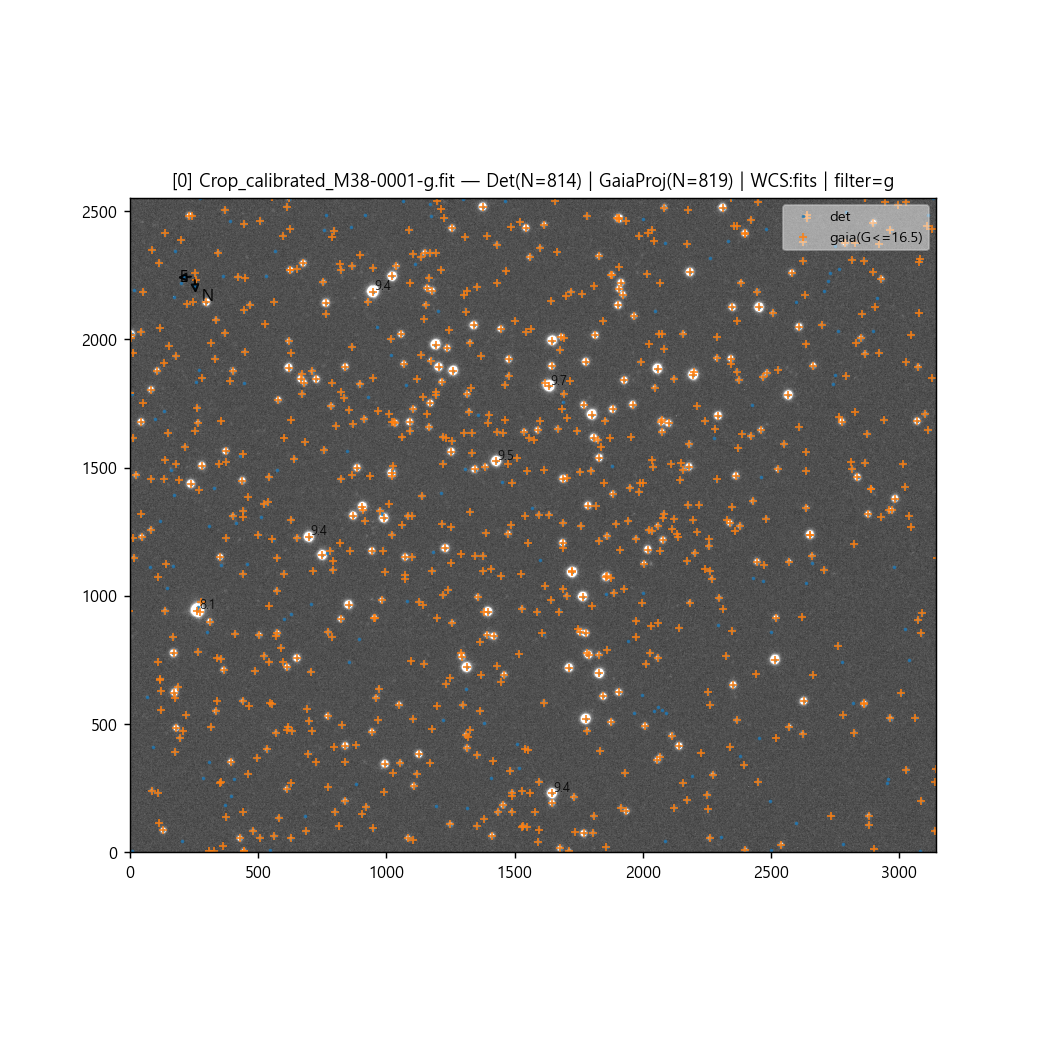

Navigator keys: [ (prev)  ] (next)  . (cycle filter)  q (quit)


In [13]:
# === Cell 7-a: Detection + PlateSolve Overlay Navigator ([], ., q) — filter 소문자 분류/표시 ===
#  - detect 오버레이 + (가능하면) WCS 기반 Gaia 별 위치 overlay + N/E compass
#  - "표시"만 추가 (파이프라인 데이터는 건드리지 않음)

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

# ---------- required globals ----------
if "RESULT_DIR" not in globals():
    raise RuntimeError("RESULT_DIR가 없습니다.")
if "CACHE_DIR" not in globals():
    raise RuntimeError("CACHE_DIR가 없습니다.")
RESULT_DIR = Path(RESULT_DIR)
CACHE_DIR  = Path(CACHE_DIR)

assert "r_filenames" in globals() and len(r_filenames) > 0, "r_filenames가 비어있습니다."

# ---------- optional helpers ----------
# get_filter_from_fits(path) 가 파이프라인에서 이미 있다고 가정.
if "get_filter_from_fits" not in globals():
    def get_filter_from_fits(path):
        try:
            h = fits.getheader(path)
            return str(h.get("FILTER","unknown")).strip()
        except Exception:
            return "unknown"

FIGSIZE = tuple(getattr(P, "overlay_figsize", (8.0, 8.0)))
DPI     = int(getattr(P, "overlay_dpi", 130))

# ---------- detect loader ----------
def _load_detect_xy(fname):
    p = CACHE_DIR / f"detect_{fname}.csv"
    if p.exists():
        try:
            df = pd.read_csv(p)
            if not df.empty and {"x","y"} <= set(df.columns):
                xy = df[["x","y"]].to_numpy(float)
                xy = xy[np.isfinite(xy).all(axis=1)]
                return xy
        except Exception:
            pass
    return np.zeros((0,2), float)

# ---------- filter → index map (lowercase) ----------
by_filter = {}
for k, fn in enumerate(r_filenames):
    f = str(get_filter_from_fits(RESULT_DIR / fn)).strip().lower()
    by_filter.setdefault(f, []).append(k)
filters = sorted(by_filter.keys())

cur_idx = 0
cur_filter = None
interval = ZScaleInterval()

# ---------- Gaia cache (optional) ----------
gaia_cache = RESULT_DIR / "gaia_fov.ecsv"
t_gaia = None
try:
    if gaia_cache.exists():
        t_gaia = Table.read(str(gaia_cache), format="ascii.ecsv")
        # ✅ 컬럼명 소문자 정규화
        cols = list(t_gaia.colnames)
        lower = [c.lower() for c in cols]
        if lower != cols:
            if len(set(lower)) != len(lower):
                raise RuntimeError(f"[Overlay] Gaia colnames lower() 충돌: {cols}")
            t_gaia.rename_columns(cols, lower)
except Exception:
    t_gaia = None

gaia_g_disp = float(getattr(P, "platesolve_gaia_display_g_limit", 16.5))

# ---------- Ref WCS header fallback (optional) ----------
_ref_wcs_hdr = None
ref_wcs_header_txt = RESULT_DIR / "ref_wcs_header.txt"
try:
    if ref_wcs_header_txt.exists():
        _ref_wcs_hdr = fits.Header.fromstring(ref_wcs_header_txt.read_text(encoding="utf-8"), sep="\n")
except Exception:
    _ref_wcs_hdr = None

def _has_wcs_like(h):
    return ("CRVAL1" in h) and ("CRVAL2" in h) and ("CRPIX1" in h) and ("CRPIX2" in h) and (
        ("CD1_1" in h) or ("PC1_1" in h) or ("CDELT1" in h)
    )

def _load_wcs_for_frame(fname):
    """프레임 FITS 헤더에서 WCS 로드. 없으면 ref_wcs_header.txt fallback."""
    h = None
    try:
        h = fits.getheader(RESULT_DIR / fname)
    except Exception:
        h = None

    # 1) 파일 자체 헤더에 WCS
    if h is not None and _has_wcs_like(h):
        try:
            w = WCS(h, relax=True)
            return w, "fits"
        except Exception:
            pass

    # 2) fallback ref_wcs_header.txt
    if _ref_wcs_hdr is not None and _has_wcs_like(_ref_wcs_hdr):
        try:
            w = WCS(_ref_wcs_hdr, relax=True)
            return w, "ref_wcs_header.txt"
        except Exception:
            pass

    return None, None

def _world2pix_safe(w, ra_deg, dec_deg):
    """WCS world->pix 안전 변환 (celestial 우선)."""
    ra = np.asarray(ra_deg, float)
    dec = np.asarray(dec_deg, float)
    sc = SkyCoord(ra*u.deg, dec*u.deg, frame="icrs")
    try:
        x, y = w.celestial.world_to_pixel(sc)
        return np.asarray(x, float), np.asarray(y, float)
    except Exception:
        x, y = w.wcs_world2pix(ra, dec, 0)
        return np.asarray(x, float), np.asarray(y, float)

def _draw_compass(ax, w, nx, ny):
    """WCS가 있으면 N/E 방향 화살표를 그림."""
    if w is None:
        return

    cx, cy = (nx - 1) * 0.5, (ny - 1) * 0.5
    try:
        sc0 = w.celestial.pixel_to_world(cx, cy)
        ra0, dec0 = float(sc0.ra.deg), float(sc0.dec.deg)
    except Exception:
        return

    d = 0.02  # deg ~ 72"
    raN, decN = ra0, dec0 + d
    raE = ra0 + d / max(np.cos(np.deg2rad(dec0)), 1e-6)
    decE = dec0

    try:
        x0, y0 = cx, cy
        xN, yN = _world2pix_safe(w, [raN], [decN]); xN, yN = float(xN[0]), float(yN[0])
        xE, yE = _world2pix_safe(w, [raE], [decE]); xE, yE = float(xE[0]), float(yE[0])
    except Exception:
        return

    def _norm_arrow(x1, y1, maxlen=80.0):
        dx, dy = x1 - x0, y1 - y0
        L = (dx*dx + dy*dy) ** 0.5
        if not np.isfinite(L) or L <= 1e-6:
            return None
        s = min(maxlen / L, 1.0)
        return (dx*s, dy*s)

    aN = _norm_arrow(xN, yN)
    aE = _norm_arrow(xE, yE)
    if aN is None or aE is None:
        return

    xA, yA = 0.08*nx, 0.88*ny
    dxN, dyN = aN
    dxE, dyE = aE

    ax.annotate("", xy=(xA + dxN, yA + dyN), xytext=(xA, yA),
                arrowprops=dict(arrowstyle="-|>", lw=1.2, alpha=0.9))
    ax.annotate("", xy=(xA + dxE, yA + dyE), xytext=(xA, yA),
                arrowprops=dict(arrowstyle="-|>", lw=1.2, alpha=0.9))
    ax.text(xA + dxN, yA + dyN, " N", fontsize=9, va="center", ha="left", alpha=0.95)
    ax.text(xA + dxE, yA + dyE, " E", fontsize=9, va="center", ha="left", alpha=0.95)

# ---------- UI ----------
plt.ioff()
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# matplotlib 기본 키핸들러 끄기(충돌 방지)
try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception:
    pass

def _redraw():
    ax.clear()
    fname = r_filenames[cur_idx]
    path = RESULT_DIR / fname

    img = fits.getdata(path)
    ny, nx = img.shape

    vmin, vmax = interval.get_limits(img)
    ax.imshow(img, cmap="gray", origin="lower", norm=ImageNormalize(vmin=vmin, vmax=vmax))

    # 1) detect overlay
    pos = _load_detect_xy(fname)
    if len(pos):
        ax.plot(pos[:,0], pos[:,1], "o", ms=1.0, alpha=0.75, label="det")

    # 2) Gaia overlay (WCS -> pix)
    w, wsrc = _load_wcs_for_frame(fname)
    gaia_n = 0
    if (w is not None) and (t_gaia is not None) and (len(t_gaia) > 0) and ("ra" in t_gaia.colnames) and ("dec" in t_gaia.colnames):
        try:
            if "phot_g_mean_mag" in t_gaia.colnames:
                m = np.isfinite(t_gaia["phot_g_mean_mag"]) & (t_gaia["phot_g_mean_mag"] <= gaia_g_disp)
            else:
                m = np.ones(len(t_gaia), bool)
            tt = t_gaia[m]

            xg, yg = _world2pix_safe(w, tt["ra"], tt["dec"])
            ok = np.isfinite(xg) & np.isfinite(yg) & (xg >= -5) & (xg < nx+5) & (yg >= -5) & (yg < ny+5)
            xg, yg = xg[ok], yg[ok]
            gaia_n = int(len(xg))

            if gaia_n > 0:
                ax.plot(xg, yg, "+", ms=4.0, mew=1.0, alpha=0.85, label=f"gaia(G<={gaia_g_disp:g})")

                # 상위 몇 개만 라벨(밝은 순)
                if "phot_g_mean_mag" in tt.colnames and gaia_n > 0:
                    mag = np.asarray(tt["phot_g_mean_mag"], float)[ok]
                    if len(mag) > 0:
                        ii = np.argsort(mag)[:min(6, len(mag))]
                        for j in ii:
                            ax.text(xg[j] + 6, yg[j] + 6, f"{mag[j]:.1f}", fontsize=7, alpha=0.85)
        except Exception:
            gaia_n = 0

    # 3) compass
    if w is not None:
        _draw_compass(ax, w, nx, ny)

    # title / legend
    filt = str(get_filter_from_fits(path)).strip().lower()
    wcs_txt = "WCS:None" if w is None else f"WCS:{wsrc or 'OK'}"
    ax.set_title(
        f"[{cur_idx}] {fname} — Det(N={len(pos)}) | GaiaProj(N={gaia_n}) | {wcs_txt} | filter={filt}",
        fontsize=10
    )
    ax.set_xlim(0, nx-1)
    ax.set_ylim(0, ny-1)

    try:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(loc="upper right", fontsize=8, framealpha=0.5)
    except Exception:
        pass

    fig.canvas.draw_idle()

def _jump(step=1):
    global cur_idx
    n = len(r_filenames)
    if cur_filter is None:
        cur_idx = (cur_idx + step) % n
    else:
        cand = by_filter.get(cur_filter, [])
        if not cand:
            cur_idx = (cur_idx + step) % n
        else:
            if cur_idx in cand:
                j = cand.index(cur_idx)
                cur_idx = cand[(j + (1 if step > 0 else -1)) % len(cand)]
            else:
                diffs = [(abs(k-cur_idx), k) for k in cand]
                cur_idx = min(diffs)[1]
    _redraw()

def _cycle_filter():
    global cur_filter, cur_idx
    if not filters:
        cur_filter = None
        _redraw()
        return

    if cur_filter is None:
        cur_filter = str(get_filter_from_fits(RESULT_DIR / r_filenames[cur_idx])).strip().lower()
        if cur_filter not in filters:
            cur_filter = filters[0]
    else:
        i = filters.index(cur_filter)
        cur_filter = filters[(i + 1) % len(filters)]

    cand = by_filter.get(cur_filter, [])
    if cand:
        diffs = [(abs(k-cur_idx), k) for k in cand]
        cur_idx = min(diffs)[1]
    _redraw()

_redraw()

def on_key(e):
    if e.key == "q":
        plt.close(fig); return
    if e.key == "[":
        _jump(step=-1); return
    if e.key == "]":
        _jump(step=+1); return
    if e.key == ".":
        _cycle_filter(); return

cid = fig.canvas.mpl_connect("key_press_event", on_key)

plt.ion()
plt.show()

print("Navigator keys: [ (prev)  ] (next)  . (cycle filter)  q (quit)")


In [14]:
# === Cell 8 (FIXED/FULL) — Star ID Matching (WCS-based, Gaia source_id) ===
# 요구사항 반영:
# - gaia_fov.ecsv에서 G/BP/RP + pmra/pmdec(+error)까지 로드/없으면 자동 재쿼리
# - 출력 CSV에 gaia_G/BP/RP + pmra/pmdec(+err) 포함 (기존 gmag/bpmag/rpmag도 유지)
# - 컬럼명 대문자/소문자 혼선 방지: Table colnames를 전부 소문자로 정규화
# - RESUME에서 cache 스킵해도 master_star_ids가 비지 않게 보호

import os, json
import numpy as np
import pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# ---------- fallbacks ----------
def _as_bool(x, default=False):
    if isinstance(x, bool): return x
    if x is None: return default
    if isinstance(x, (int, np.integer)): return bool(x)
    s = str(x).strip().lower()
    if s in ("1","true","t","yes","y","on"): return True
    if s in ("0","false","f","no","n","off"): return False
    return default

def _is_up_to_date(out_path: Path, in_paths):
    try:
        out_m = out_path.stat().st_mtime
    except Exception:
        return False
    for p in in_paths:
        try:
            if Path(p).stat().st_mtime > out_m:
                return False
        except Exception:
            return False
    return True

def _table_cols_lower(tab: Table) -> Table:
    cols = list(tab.colnames)
    lower = [c.lower() for c in cols]
    if lower != cols:
        if len(set(lower)) != len(lower):
            raise RuntimeError(f"[IDMatch] Gaia colnames lower() 충돌: {cols}")
        tab.rename_columns(cols, lower)
    return tab

# ---------- dirs ----------
# 기존 파이프라인이 CACHE_DIR/RESULT_DIR 전역을 쓰면 그걸 우선 사용
if "CACHE_DIR" in globals() and "RESULT_DIR" in globals():
    CACHE_DIR  = Path(CACHE_DIR)
    RESULT_DIR = Path(RESULT_DIR)
else:
    CACHE_DIR  = Path(getattr(P, "cache_dir"))
    RESULT_DIR = Path(getattr(P, "result_dir"))
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- frames ----------
if "r_filenames" in globals() and len(r_filenames) > 0:
    frames = list(r_filenames)
else:
    frames = sorted([p.name for p in RESULT_DIR.glob("Crop_*.fit*")])
if not frames:
    raise RuntimeError("[IDMatch] 대상 프레임이 없습니다. Crop_* 또는 r_filenames 확인.")

# ---------- pixel scale ----------
pix_scale_arcsec = float(getattr(P, "pixel_scale_arcsec", np.nan))
if not np.isfinite(pix_scale_arcsec) or pix_scale_arcsec <= 0:
    raise RuntimeError("[IDMatch] P.pixel_scale_arcsec 미확정: Cell 1에서 instrument 계산값을 저장해야 합니다.")

# ---------- center coord (for possible re-query) ----------
ra0_deg = dec0_deg = None
if "PRIMARY_COORD" in globals() and (globals().get("PRIMARY_COORD") is not None):
    c0 = globals()["PRIMARY_COORD"]
    ra0_deg  = float(c0.ra.deg)
    dec0_deg = float(c0.dec.deg)
else:
    _raw = getattr(P, "_raw", {}) if hasattr(P, "_raw") else {}
    ra0_deg  = float(_raw.get("target_ra_deg", _raw.get("ra_deg", 0.0)) or 0.0)
    dec0_deg = float(_raw.get("target_dec_deg", _raw.get("dec_deg", 0.0)) or 0.0)

# ---------- Gaia cache ensure ----------
gaia_cache = RESULT_DIR / "gaia_fov.ecsv"
if not gaia_cache.exists():
    raise FileNotFoundError("[IDMatch] gaia_fov.ecsv가 없습니다. Cell 7(NEW) 먼저 실행하세요.")

t_gaia = Table.read(str(gaia_cache), format="ascii.ecsv")
t_gaia = _table_cols_lower(t_gaia)

# 이번 단계에서 필요한 컬럼(요청 반영: G/BP/RP + pm)
REQ = ["source_id","ra","dec","phot_g_mean_mag","phot_bp_mean_mag","phot_rp_mean_mag","pmra","pmdec"]
missing = [c for c in REQ if c not in t_gaia.colnames]

# cache가 오래되었으면 자동 재쿼리/덮어쓰기
if missing:
    print(f"[IDMatch] gaia_fov.ecsv 누락컬럼 {missing} → Gaia 재쿼리로 갱신합니다.")
    rad_scale = float(getattr(P, "platesolve_gaia_radius_scale", 1.35))
    max_r = 0.0
    for fn in frames[:min(len(frames), 20)]:
        ny, nx = fits.getdata(RESULT_DIR/fn, memmap=False).shape
        fov_w_deg = (nx * pix_scale_arcsec) / 3600.0
        fov_h_deg = (ny * pix_scale_arcsec) / 3600.0
        r = 0.5 * float(np.hypot(fov_w_deg, fov_h_deg))
        max_r = max(max_r, r)
    gaia_radius_deg = max(0.05, max_r * rad_scale)

    from astroquery.gaia import Gaia
    Gaia.ROW_LIMIT = -1
    q = f"""
    SELECT
      source_id, ra, dec,
      phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
      pmra, pmdec, pmra_error, pmdec_error,
      parallax, parallax_error
    FROM gaiadr3.gaia_source
    WHERE 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra0_deg:.8f}, {dec0_deg:.8f}, {gaia_radius_deg:.8f})
    )
    """
    job = Gaia.launch_job_async(q)
    t_gaia = job.get_results()
    t_gaia = _table_cols_lower(t_gaia)

    t_gaia.write(str(gaia_cache), format="ascii.ecsv", overwrite=True)
    print(f"[IDMatch] gaia_fov.ecsv 재저장 완료 | N={len(t_gaia)} | cols={t_gaia.colnames}")

# ---------- match params ----------
g_match = float(getattr(P, "idmatch_gaia_g_limit", 18.0))
if "phot_g_mean_mag" in t_gaia.colnames:
    m = np.isfinite(t_gaia["phot_g_mean_mag"]) & (t_gaia["phot_g_mean_mag"] <= g_match)
    t_use = t_gaia[m]
else:
    t_use = t_gaia

if len(t_use) == 0:
    raise RuntimeError("[IDMatch] Gaia 사용 대상(t_use)이 0개입니다. gaia_fov.ecsv / g_limit 확인하세요.")

gaia_sky = SkyCoord(t_use["ra"], t_use["dec"], unit="deg", frame="icrs")

tol_arcsec = float(getattr(P, "idmatch_tol_arcsec", np.nan))
if not np.isfinite(tol_arcsec) or tol_arcsec <= 0:
    tol_px = float(getattr(P, "idmatch_tol_px", 2.0))
    tol_arcsec = tol_px * pix_scale_arcsec

print(f"[IDMatch] Gaia G<={g_match:.1f} | tol={tol_arcsec:.3f}\"  (pix_scale={pix_scale_arcsec:.5f}\")")

RESUME = _as_bool(getattr(P, "resume_mode", True), True)
FORCE  = _as_bool(getattr(P, "force_idmatch", False), False)

# ---------- detect loader ----------
def _load_detect_xy(fname):
    p = CACHE_DIR / f"detect_{fname}.csv"
    if p.exists() and p.stat().st_size > 0:
        try:
            df = pd.read_csv(p)
            if {"x","y"} <= set(df.columns) and len(df):
                xy = df[["x","y"]].to_numpy(float)
                xy = xy[np.isfinite(xy).all(axis=1)]
                return xy
        except Exception:
            pass
    return np.zeros((0,2), float)

# ---------- outputs ----------
out_dir = CACHE_DIR / "idmatch"
out_dir.mkdir(exist_ok=True)

EMPTY_COLS = [
    "file","source_id","x","y","ra_deg","dec_deg","sep_arcsec",
    "gaia_G","gaia_BP","gaia_RP","gmag","bpmag","rpmag",
    "pmra_masyr","pmdec_masyr","pmra_err","pmdec_err"
]

rows_summary = []
all_master_ids = set()

# ---------- main per frame ----------
for k, fname in enumerate(frames, 1):
    path = RESULT_DIR / fname
    if not path.exists():
        print(f"⚠️ [{k}/{len(frames)}] skip {fname}: file missing")
        continue

    out_csv  = out_dir / f"idmatch_{fname}.csv"
    out_json = out_dir / f"idmatch_{fname}.json"

    # ✅ cache 스킵해도 master ids 업데이트
    if RESUME and (not FORCE) and out_csv.exists() and out_json.exists() and _is_up_to_date(out_csv, [path, gaia_cache]):
        try:
            meta = json.loads(out_json.read_text(encoding="utf-8"))
        except Exception:
            meta = dict(file=fname, ok=True, reason="cache", n_det=None, n_matched=None, tol_arcsec=float(tol_arcsec))

        rows_summary.append(meta)

        try:
            df_cached = pd.read_csv(out_csv, usecols=["source_id"])
            if len(df_cached):
                all_master_ids.update(df_cached["source_id"].astype("int64").tolist())
        except Exception:
            pass

        print(f"↩︎ [{k}/{len(frames)}] skip idmatch: {fname} (cache)")
        continue

    # WCS
    try:
        hdr = fits.getheader(path)
        w = WCS(hdr, relax=True)
    except Exception:
        w = None

    if w is None or (not getattr(w, "has_celestial", False)):
        meta = dict(file=fname, ok=False, reason="no_wcs", n_det=0, n_matched=0, tol_arcsec=float(tol_arcsec))
        out_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")
        pd.DataFrame([], columns=EMPTY_COLS).to_csv(out_csv, index=False)
        rows_summary.append(meta)
        print(f"❌ [{k}/{len(frames)}] {fname}: WCS 없음 → 매칭 스킵")
        continue

    # detections
    xy = _load_detect_xy(fname)
    n_det = int(len(xy))
    if n_det == 0:
        meta = dict(file=fname, ok=False, reason="no_detect", n_det=0, n_matched=0, tol_arcsec=float(tol_arcsec))
        out_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")
        pd.DataFrame([], columns=EMPTY_COLS).to_csv(out_csv, index=False)
        rows_summary.append(meta)
        print(f"⚠️ [{k}/{len(frames)}] {fname}: detect 없음")
        continue

    # pix -> sky
    ra, dec = w.all_pix2world(xy[:,0], xy[:,1], 0)
    sky_det = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")

    # sky match
    idx, sep2d, _ = sky_det.match_to_catalog_sky(gaia_sky)
    sep_arc = sep2d.arcsec
    ok = np.isfinite(sep_arc) & (sep_arc <= tol_arcsec)

    if not np.any(ok):
        meta = dict(file=fname, ok=True, reason="no_match", n_det=n_det, n_matched=0, tol_arcsec=float(tol_arcsec))
        out_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")
        pd.DataFrame([], columns=EMPTY_COLS).to_csv(out_csv, index=False)
        rows_summary.append(meta)
        print(f"⚠️ [{k}/{len(frames)}] {fname}: matched=0 / det={n_det}")
        continue

    xy_ok  = xy[ok]
    sep_ok = sep_arc[ok]
    idx_ok = idx[ok]

    # Gaia fields
    src_id = np.asarray(t_use["source_id"])[idx_ok].astype(np.int64, copy=False)
    ra_g   = np.asarray(t_use["ra"])[idx_ok].astype(float)
    dec_g  = np.asarray(t_use["dec"])[idx_ok].astype(float)

    gaia_G  = np.asarray(t_use["phot_g_mean_mag"])[idx_ok] if "phot_g_mean_mag" in t_use.colnames else np.full(len(src_id), np.nan)
    gaia_BP = np.asarray(t_use["phot_bp_mean_mag"])[idx_ok] if "phot_bp_mean_mag" in t_use.colnames else np.full(len(src_id), np.nan)
    gaia_RP = np.asarray(t_use["phot_rp_mean_mag"])[idx_ok] if "phot_rp_mean_mag" in t_use.colnames else np.full(len(src_id), np.nan)

    pmra   = np.asarray(t_use["pmra"])[idx_ok] if "pmra" in t_use.colnames else np.full(len(src_id), np.nan)         # mas/yr
    pmdec  = np.asarray(t_use["pmdec"])[idx_ok] if "pmdec" in t_use.colnames else np.full(len(src_id), np.nan)
    pmra_e = np.asarray(t_use["pmra_error"])[idx_ok] if "pmra_error" in t_use.colnames else np.full(len(src_id), np.nan)
    pmde_e = np.asarray(t_use["pmdec_error"])[idx_ok] if "pmdec_error" in t_use.colnames else np.full(len(src_id), np.nan)

    df = pd.DataFrame({
        "file": fname,
        "source_id": src_id,
        "x": xy_ok[:,0],
        "y": xy_ok[:,1],
        "ra_deg": ra_g,
        "dec_deg": dec_g,
        "sep_arcsec": sep_ok,

        # ✅ 명확한 Gaia 컬럼
        "gaia_G": gaia_G,
        "gaia_BP": gaia_BP,
        "gaia_RP": gaia_RP,

        # ✅ 하위호환: 기존 downstream이 gmag/bpmag/rpmag를 쓰면 그대로 동작
        "gmag": gaia_G,
        "bpmag": gaia_BP,
        "rpmag": gaia_RP,

        # ✅ proper motion
        "pmra_masyr": pmra,
        "pmdec_masyr": pmdec,
        "pmra_err": pmra_e,
        "pmdec_err": pmde_e,
    })

    # 같은 source_id가 여러 detect에 붙으면 sep 작은 것만 남김
    df = df.sort_values("sep_arcsec").drop_duplicates(subset=["source_id"], keep="first").reset_index(drop=True)

    df.to_csv(out_csv, index=False)

    n_matched = int(len(df))
    meta = dict(
        file=fname, ok=True, reason="ok",
        n_det=n_det, n_matched=n_matched,
        tol_arcsec=float(tol_arcsec),
        sep_med_arcsec=float(np.median(df["sep_arcsec"])) if n_matched else np.nan,
        sep_max_arcsec=float(np.max(df["sep_arcsec"])) if n_matched else np.nan,
    )
    out_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")
    rows_summary.append(meta)

    all_master_ids.update(df["source_id"].astype("int64").tolist())
    print(f"✅ [{k}/{len(frames)}] {fname}: matched={n_matched} / det={n_det} | sep_med={meta['sep_med_arcsec']:.3f}\"")

# ---------- outputs ----------
summary_csv = RESULT_DIR / "idmatch_summary.csv"
pd.DataFrame(rows_summary).to_csv(summary_csv, index=False)
print(f"Saved: {summary_csv}")

# ✅ safety: 캐시 스킵만 타고 all_master_ids가 비는 상황 방지
if len(all_master_ids) == 0:
    for p in sorted(out_dir.glob("idmatch_*.csv")):
        try:
            df = pd.read_csv(p, usecols=["source_id"])
            if len(df):
                all_master_ids.update(df["source_id"].astype("int64").tolist())
        except Exception:
            pass

master_csv = RESULT_DIR / "master_star_ids.csv"
pd.DataFrame({"source_id": sorted(all_master_ids)}).to_csv(master_csv, index=False)
print(f"Saved: {master_csv} | N_master={len(all_master_ids)}")

print(f"[DONE] idmatch per-frame CSVs: {out_dir}/idmatch_*.csv")


[IDMatch] Gaia G<=18.0 | tol=0.786"  (pix_scale=0.39299")
✅ [1/9] Crop_calibrated_M38-0001-g.fit: matched=710 / det=814 | sep_med=0.166"
✅ [2/9] Crop_calibrated_M38-0001-i.fit: matched=844 / det=1006 | sep_med=0.171"
✅ [3/9] Crop_calibrated_M38-0001-r.fit: matched=897 / det=971 | sep_med=0.171"
✅ [4/9] Crop_calibrated_M38-0002-g.fit: matched=688 / det=789 | sep_med=0.155"
✅ [5/9] Crop_calibrated_M38-0002-i.fit: matched=750 / det=923 | sep_med=0.180"
✅ [6/9] Crop_calibrated_M38-0002-r.fit: matched=820 / det=914 | sep_med=0.187"
✅ [7/9] Crop_calibrated_M38-0003-g.fit: matched=601 / det=720 | sep_med=0.172"
❌ [8/9] Crop_calibrated_M38-0003-i.fit: WCS 없음 → 매칭 스킵
✅ [9/9] Crop_calibrated_M38-0003-r.fit: matched=814 / det=894 | sep_med=0.178"
Saved: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\idmatch_summary.csv
Saved: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\master_star_ids.csv | N_master=1166
[DONE] idmatch per-frame CSVs: C:\Us

In [15]:
# === Cell 9 (IRAF FWHM 일원화, aperture/annulus 결정 + 로그) ===
import json, math, numpy as np, pandas as pd
from astropy.io import fits
from astropy.stats import SigmaClip
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

RESUME     = bool(getattr(P, "resume_mode", True))
FORCE_REAP = bool(getattr(P, "force_reap", False))

AP_SCALE      = float(getattr(P, "phot_aperture_scale", 1.0))
ANN_IN_SCALE  = float(getattr(P, "fitsky_annulus_scale", 4.0))
DANN_SCALE    = float(getattr(P, "fitsky_dannulus_scale", 2.0))
CBOX_SCALE    = float(getattr(P, "center_cbox_scale", 1.5))

fwhm_px_min   = float(getattr(P, "fwhm_px_min", 3.5))
fwhm_px_max   = float(getattr(P, "fwhm_px_max", 8.0))

min_r_ap_px   = float(getattr(P, "min_r_ap_px", 4.0))
min_r_in_px   = float(getattr(P, "min_r_in_px", 12.0))
min_r_out_px  = float(getattr(P, "min_r_out_px", 20.0))

GAIN   = float(getattr(P, "gain_e_per_adu", 0.1))
RN     = float(getattr(P, "rdnoise_e", 1.39))
ps = float(getattr(P, "pixel_scale_arcsec", np.nan))
if not np.isfinite(ps) or ps <= 0:
    raise RuntimeError("[Cell 9] pixel scale 미확정: Cell 1(Telescope/Camera) 먼저 실행하세요.")

# (옵션) QC pass만
phot_use_qc_pass_only = bool(getattr(P, "phot_use_qc_pass_only", False))
phot_files = list(r_filenames)

fq = RESULT_DIR / "frame_quality.csv"
if phot_use_qc_pass_only and fq.exists():
    try:
        dfq = pd.read_csv(fq)
        good = set(dfq.loc[dfq["passed"] == True, "file"].astype(str).tolist())
        phot_files = [f for f in phot_files if f in good]
        print(f"[Cell 9] QC pass only: N={len(phot_files)} (from frame_quality.csv)")
    except Exception as e:
        print("[Cell 9] frame_quality.csv 읽기 실패 → 전체 프레임 사용:", e)

rows_ap, rows_apcorr = [], []
made_ap, made_c = 0, 0
log = TailLogger(CACHE_DIR/"aperture.log", tail=getattr(P,"ui_log_tail",300), enable_console=True)

def _get_fwhm_from_meta(meta: dict) -> float:
    # Cell6 출력 키가 버전/리팩토링에 따라 달라질 수 있어 우선순위로 탐색
    for k in ("fwhm_med_px", "fwhm_med_rad_px", "fwhm_px_med", "fwhm_med"):
        v = meta.get(k, None)
        try:
            v = float(v)
            if np.isfinite(v) and v > 0:
                return v
        except Exception:
            pass
    return float(getattr(P, "fwhm_pix_guess", 6.0))

for fname in phot_files:
    ap_json  = CACHE_DIR / f"ap_{fname}.json"
    apc_json = CACHE_DIR / f"apcorr_{fname}.json"

    # --- FWHM: Cell 6 결과만 사용 (일원화)
    meta_path = CACHE_DIR / f"detect_{fname}.json"
    if meta_path.exists():
        try:
            meta = json.loads(meta_path.read_text(encoding="utf-8"))
            fwhm_med = _get_fwhm_from_meta(meta)
        except Exception:
            fwhm_med = float(getattr(P, "fwhm_pix_guess", 6.0))
            log.write(f"{fname}: detect meta read fail → use fallback fwhm={fwhm_med:.2f}px")
    else:
        fwhm_med = float(getattr(P, "fwhm_pix_guess", 6.0))
        log.write(f"{fname}: no detect meta → use fallback fwhm={fwhm_med:.2f}px")

    fwhm_used = float(np.clip(fwhm_med, fwhm_px_min, fwhm_px_max))
    r_ap  = max(AP_SCALE     * fwhm_used, min_r_ap_px)
    r_in  = max(ANN_IN_SCALE * fwhm_used, max(min_r_in_px, r_ap + float(getattr(P,"annulus_min_gap_px",6.0))))
    r_out = max(r_in + DANN_SCALE * fwhm_used,
                r_in + float(getattr(P,"annulus_min_width_px",12.0)), min_r_out_px)
    cbox_px = max(CBOX_SCALE * fwhm_used, 5.0)

    row = dict(file=fname, fwhm_med=fwhm_med, fwhm_used=fwhm_used,
               r_ap=r_ap, r_in=r_in, r_out=r_out, cbox_px=cbox_px)

    row.update(dict(
        fwhm_med_arcsec=fwhm_med*ps, fwhm_used_arcsec=fwhm_used*ps,
        r_ap_arcsec=r_ap*ps, r_in_arcsec=r_in*ps, r_out_arcsec=r_out*ps,
        cbox_arcsec=cbox_px*ps
    ))

    rows_ap.append(row)
    ap_json.write_text(json.dumps(row, indent=2, default=_jsonify), encoding="utf-8")
    made_ap += 1

    # --- Aperture correction (옵션)
    apcorr_apply = bool(getattr(P, "apcorr_apply", True))
    apcorr_min_snr = float(getattr(P, "apcorr_min_snr", 40.0))
    apcorr_use_min_n = int(getattr(P, "apcorr_use_min_n", 20))
    apcorr_scatter_max = float(getattr(P, "apcorr_scatter_max", 0.05))

    det_csv = CACHE_DIR / f"detect_{fname}.csv"
    if (not apcorr_apply) or (not det_csv.exists()):
        rowc = dict(file=fname, apcorr=np.nan, rel_scatter=np.nan, n_used=0, apply=False)
    else:
        img = fits.getdata(RESULT_DIR / fname).astype(float)
        xy_all = pd.read_csv(det_csv)[["x","y"]].to_numpy(float)

        from scipy.spatial import cKDTree as KDTree
        H, W = img.shape
        if len(xy_all):
            vals = img[xy_all[:,1].astype(int).clip(0,H-1), xy_all[:,0].astype(int).clip(0,W-1)]
            order = np.argsort(vals)[::-1]
            xy_all = xy_all[order][:300]

        corr = []
        sc = SigmaClip(getattr(P,"annulus_sigma_clip",3.0), maxiters=int(getattr(P,"fitsky_max_iter",5)))
        r_small = max(float(getattr(P, 'apcorr_small_scale', 1.0)) * fwhm_used, r_ap)
        r_large = max(float(getattr(P, 'apcorr_large_scale', 3.0)) * fwhm_used, r_small + fwhm_used)

        for (x,y) in xy_all:
            ap_s = CircularAperture((x, y), r=r_small)
            ap_L = CircularAperture((x, y), r=r_large)
            an   = CircularAnnulus((x, y), r_in=r_in, r_out=r_out)
            st_s = ApertureStats(img, ap_s, sigma_clip=sc)
            st_L = ApertureStats(img, ap_L, sigma_clip=sc)
            st_an= ApertureStats(img, an, sigma_clip=sc)
            bkg_med = float(st_an.median)
            flux_s = float(st_s.sum - bkg_med * ap_s.area)
            flux_L = float(st_L.sum - bkg_med * ap_L.area)
            if flux_s>0 and flux_L>0:
                corr.append(float(flux_L/flux_s))

        if len(corr) >= apcorr_use_min_n:
            medc = float(np.median(corr))
            mad  = float(np.median(np.abs(np.array(corr) - medc)))
            rel_sc = 1.4826*mad/medc if medc>0 else np.nan
            apply_flag = bool(np.isfinite(rel_sc) and (rel_sc <= apcorr_scatter_max))
        else:
            medc, rel_sc, apply_flag = (np.nan, np.nan, False)

        rowc = dict(file=fname, fwhm_med=fwhm_med, fwhm_used=fwhm_used,
                    r_small=r_small, r_large=r_large, n_used=int(len(corr)),
                    apcorr=medc, rel_scatter=rel_sc, apply=bool(apply_flag),
                    r_small_arcsec=r_small*ps, r_large_arcsec=r_large*ps)

    rows_apcorr.append(rowc)
    apc_json.write_text(json.dumps(rowc, indent=2, default=_jsonify), encoding="utf-8")
    made_c += 1

    log.write(f"{fname}: FWHM~{fwhm_med:.2f}px ({fwhm_med*ps:.2f}\") → r_ap={r_ap:.1f}px ({r_ap*ps:.2f}\")")

log.close()
pd.DataFrame(rows_ap).to_csv(RESULT_DIR/"aperture_by_frame.csv", index=False)
pd.DataFrame(rows_apcorr).to_csv(RESULT_DIR/"apcorr_summary.csv", index=False)
print(f"Saved: aperture_by_frame.csv / apcorr_summary.csv (새 ap={made_ap}, apcorr={made_c}) | 로그: {CACHE_DIR/'aperture.log'}")


[03:10:24] Crop_calibrated_M38-0001-g.fit: FWHM~7.87px (3.09") → r_ap=7.9px (3.09")
[03:10:27] Crop_calibrated_M38-0001-i.fit: FWHM~6.43px (2.53") → r_ap=6.4px (2.53")
[03:10:31] Crop_calibrated_M38-0001-r.fit: FWHM~6.35px (2.50") → r_ap=6.4px (2.50")
[03:10:35] Crop_calibrated_M38-0002-g.fit: FWHM~8.46px (3.32") → r_ap=8.5px (3.32")
[03:10:39] Crop_calibrated_M38-0002-i.fit: FWHM~8.11px (3.19") → r_ap=8.1px (3.19")
[03:10:42] Crop_calibrated_M38-0002-r.fit: FWHM~8.08px (3.17") → r_ap=8.1px (3.17")
[03:10:46] Crop_calibrated_M38-0003-g.fit: FWHM~9.02px (3.54") → r_ap=9.0px (3.54")
[03:10:46] Crop_calibrated_M38-0003-i.fit: FWHM~10.32px (4.06") → r_ap=10.0px (3.93")
[03:10:51] Crop_calibrated_M38-0003-r.fit: FWHM~7.48px (2.94") → r_ap=7.5px (2.94")
Saved: aperture_by_frame.csv / apcorr_summary.csv (새 ap=9, apcorr=9) | 로그: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\cache\aperture.log


In [ ]:
# === Cell 10 — Master_star_ids 편집 UI (source_id 기반, Shift+D 유지, filter는 헤더 그대로/소문자 유지) ===
from ipywidgets import Output, VBox, HBox, HTML, Layout
from IPython.display import display
import numpy as np, pandas as pd, time
from pathlib import Path
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree as KDTree

# -----------------------------
# backend check (키 입력 안 먹는 경우 대부분 여기)
# -----------------------------
_backend = str(plt.get_backend()).lower()
HAS_WIDGET_BACKEND = ("widget" in _backend) or ("ipympl" in _backend)
if not HAS_WIDGET_BACKEND:
    print(f"[WARN] matplotlib backend='{plt.get_backend()}' → 키 입력이 안 먹을 수 있음.")
    print("       권장: (1회만)  %matplotlib widget   후 이 셀 재실행")
    print("       그리고 플롯을 한 번 클릭해서 포커스 준 뒤 키를 누르세요.")

# -----------------------------
# env
# -----------------------------
CACHE_DIR  = P.cache_dir;  CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULT_DIR = P.result_dir

CANVAS_PX   = int(getattr(P, "ui_canvas_px", 700))
LOG_TAIL    = int(getattr(P, "ui_log_tail", 300))
search_radius_px = float(getattr(P, "search_radius_px", 7.0))
bulk_drop_box_px = int(getattr(P, "bulk_drop_box_px", 200))

# frames
frames = list(r_filenames) if ("r_filenames" in globals() and len(r_filenames)) else sorted([p.name for p in RESULT_DIR.glob("Crop_*.fit*")])
if not frames:
    raise RuntimeError("[Cell10] 프레임이 없습니다. Crop_* 또는 r_filenames 확인.")

# (옵션) QC pass only
use_qc_pass_only = bool(getattr(P, "master_use_qc_pass_only", True))
fq = RESULT_DIR / "frame_quality.csv"
if use_qc_pass_only and fq.exists():
    try:
        dfq = pd.read_csv(fq)
        good = set(dfq.loc[dfq["passed"] == True, "file"].astype(str).tolist())
        frames = [f for f in frames if f in good]
        print(f"[Cell10] QC pass only: N={len(frames)}")
    except Exception as e:
        print("[Cell10] frame_quality.csv 읽기 실패 → 전체 프레임 사용:", e)

if not frames:
    raise RuntimeError("[Cell10] QC 필터 후 프레임이 0개입니다. master_use_qc_pass_only 옵션 확인.")

# -----------------------------
# filter helpers  (★ 대문자 변환 금지: 헤더 그대로/소문자 유지)
# -----------------------------
def _filter_raw(fn: str) -> str:
    # 네 파이프라인에 이미 있는 get_filter_from_fits()를 그대로 사용(대문자화 금지)
    try:
        v = get_filter_from_fits(RESULT_DIR / fn)  # 사용자가 이미 쓰던 함수
        s = str(v).strip()
        return s
    except Exception:
        return ""

def _filter_norm(s: str) -> str:
    return str(s).strip().lower()

# SDSS 기본 순서(소문자)
SDSS_ORDER = ["u", "g", "r", "i", "z"]

# 현재 frames에서 실제로 존재하는 필터 norm 목록 만들기
present_norm = []
for fn in frames:
    n = _filter_norm(_filter_raw(fn))
    if n and (n not in present_norm):
        present_norm.append(n)

# 순서: SDSS 먼저 + 나머지(등장순)
filters_order = [f for f in SDSS_ORDER if f in present_norm] + [f for f in present_norm if f not in SDSS_ORDER]
if not filters_order:
    filters_order = [""]  # 필터를 못 읽는 경우도 안전하게

def _nearest_by_filter_norm(cur_idx: int, next_norm: str) -> int:
    cand = [k for k, fn in enumerate(frames) if _filter_norm(_filter_raw(fn)) == next_norm]
    if not cand:
        return (cur_idx + 1) % len(frames)
    return min(cand, key=lambda k: abs(k - cur_idx))

def _cycle_filter_idx(cur_idx: int) -> int:
    cur_norm = _filter_norm(_filter_raw(frames[cur_idx]))
    try:
        j = filters_order.index(cur_norm)
        next_norm = filters_order[(j + 1) % len(filters_order)]
    except Exception:
        next_norm = cur_norm
    return _nearest_by_filter_norm(cur_idx, next_norm)

# -----------------------------
# idmatch paths
# -----------------------------
IDMATCH_DIR = CACHE_DIR / "idmatch"
def _idmatch_csv_for(fn: str) -> Path:
    return IDMATCH_DIR / f"idmatch_{fn}.csv"

# -----------------------------
# master ids (source_id list)
# -----------------------------
MASTER_IDS_PATH = RESULT_DIR / "master_star_ids.csv"
MASTER_IDS_BACK = RESULT_DIR / "master_star_ids.orig.csv"

def _load_master_ids():
    if not MASTER_IDS_PATH.exists():
        raise RuntimeError("[Cell10] master_star_ids.csv가 없습니다. Cell 8(IDMatch)을 먼저 실행하세요.")
    df = pd.read_csv(MASTER_IDS_PATH)
    cols = {c.lower(): c for c in df.columns}
    if "source_id" not in cols:
        raise RuntimeError(f"[Cell10] master_star_ids.csv에 source_id 컬럼이 없습니다. cols={df.columns.tolist()}")
    if cols["source_id"] != "source_id":
        df = df.rename(columns={cols["source_id"]: "source_id"})
    ids = df["source_id"].dropna().astype(np.int64).tolist()
    ids = sorted(set(ids))
    return ids

def _save_master_ids(ids):
    ids = sorted(set(int(x) for x in ids))
    pd.DataFrame({"source_id": ids}).to_csv(MASTER_IDS_PATH, index=False)

# 최초 백업
if MASTER_IDS_PATH.exists() and (not MASTER_IDS_BACK.exists()):
    pd.read_csv(MASTER_IDS_PATH).to_csv(MASTER_IDS_BACK, index=False)
    print(f"(백업) {MASTER_IDS_BACK.name} 생성")

master_ids = _load_master_ids()

# -----------------------------
# logging
# -----------------------------
EDIT_LOG = CACHE_DIR / "master_edit.log"
log_out = Output(layout=Layout(width='330px', height='700px', overflow='auto', border='1px solid #444'))
_log_buffer = []

def _log_to_file(msg: str):
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    with open(EDIT_LOG, "a", encoding="utf-8") as f:
        f.write(f"[{ts}] {msg}\n")

def log(*args):
    msg = " ".join(str(a) for a in args)
    _log_buffer.insert(0, msg)
    with log_out:
        from IPython.display import clear_output as _clr
        _clr(wait=True)
        for line in _log_buffer[:LOG_TAIL]:
            print(line)
    _log_to_file(msg)

# -----------------------------
# per-frame loader
# -----------------------------
show_all_matches = bool(getattr(P, "master_show_all_matches", True))

def _load_frame(fn):
    img = fits.getdata(RESULT_DIR / fn).astype(float)
    p = _idmatch_csv_for(fn)
    if p.exists() and p.stat().st_size > 0:
        dfm = pd.read_csv(p)
        cols = {c.lower(): c for c in dfm.columns}
        # 컬럼 표준화
        for need in ("source_id", "x", "y"):
            if need not in cols:
                dfm = pd.DataFrame(columns=["source_id","x","y"])
                break
        else:
            if cols["source_id"] != "source_id":
                dfm = dfm.rename(columns={cols["source_id"]: "source_id"})
            if cols["x"] != "x":
                dfm = dfm.rename(columns={cols["x"]: "x"})
            if cols["y"] != "y":
                dfm = dfm.rename(columns={cols["y"]: "y"})
            dfm = dfm[["source_id","x","y"]].copy()
    else:
        dfm = pd.DataFrame(columns=["source_id","x","y"])
    return img, dfm

def _master_xy_in_frame(df_match, master_ids):
    if df_match.empty:
        return np.zeros((0,2), float), np.zeros((0,), np.int64)
    mset = set(int(x) for x in master_ids)
    sid = df_match["source_id"].astype(np.int64).to_numpy()
    okm = np.array([s in mset for s in sid], dtype=bool)
    sub = df_match.loc[okm, ["source_id","x","y"]].copy()
    if sub.empty:
        return np.zeros((0,2), float), np.zeros((0,), np.int64)
    xy = sub[["x","y"]].to_numpy(float)
    sid2 = sub["source_id"].to_numpy(np.int64)
    ok = np.isfinite(xy).all(axis=1)
    return xy[ok], sid2[ok]

def _build_tree_xy(xy):
    return KDTree(xy) if len(xy) else None

def _nearest_match_row(df_match, x, y, radius_px=7.0):
    if df_match.empty:
        return None
    XY = df_match[["x","y"]].to_numpy(float)
    ok = np.isfinite(XY).all(axis=1)
    if not np.any(ok):
        return None
    XY2 = XY[ok]
    idx_map = np.flatnonzero(ok)
    tree = _build_tree_xy(XY2)
    if tree is None:
        return None
    d, j = tree.query([x, y], k=1)
    if (not np.isfinite(d)) or (d > radius_px):
        return None
    return int(idx_map[int(j)])

# -----------------------------
# viewer init
# -----------------------------
view_idx  = 0
view_file = frames[view_idx]
img, df_match = _load_frame(view_file)

interval = ZScaleInterval()
vmin, vmax = interval.get_limits(img)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

plt.ioff()
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception:
    pass

im = ax.imshow(img, cmap="gray", origin="lower", norm=norm)

all_scatter  = ax.plot([], [], ".", ms=1.5, color=(1,1,1,0.25))[0]
mast_scatter = ax.plot([], [], "o", ms=4.0, mfc="none", mec="gold", mew=1.0, alpha=0.95)[0]

def _refresh_plot():
    # all matches
    if show_all_matches and (not df_match.empty):
        XYall = df_match[["x","y"]].to_numpy(float)
        ok = np.isfinite(XYall).all(axis=1)
        XYall = XYall[ok]
        all_scatter.set_data(XYall[:,0], XYall[:,1]) if len(XYall) else all_scatter.set_data([],[])
    else:
        all_scatter.set_data([], [])

    XYm, _sid = _master_xy_in_frame(df_match, master_ids)
    mast_scatter.set_data(XYm[:,0], XYm[:,1]) if len(XYm) else mast_scatter.set_data([],[])

    fraw = _filter_raw(view_file)  # ★ 헤더 그대로
    ax.set_title(f"{view_file} | FILTER='{fraw}' | master_ids={len(master_ids)} | shown={len(XYm)}", fontsize=10)
    fig.canvas.draw_idle()

def _reload_view(new_idx):
    global view_idx, view_file, img, df_match, norm
    view_idx = int(new_idx) % len(frames)
    view_file = frames[view_idx]
    img, df_match = _load_frame(view_file)

    vmin, vmax = ZScaleInterval().get_limits(img)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    im.set_data(img); im.set_norm(norm)
    _refresh_plot()
    log(f"[VIEW] {view_file} | FILTER='{_filter_raw(view_file)}' | idmatch_rows={len(df_match)}")

def _next_frame():
    _reload_view(view_idx + 1)

def _prev_frame():
    _reload_view(view_idx - 1)

# undo buffers
_last_deleted = None  # list[source_id]
_last_added = None    # source_id

def _add_at(x, y):
    global master_ids, _last_added
    j = _nearest_match_row(df_match, x, y, radius_px=search_radius_px)
    if j is None:
        log("추가 실패: 커서 근처에 idmatch 점이 없음 (해당 프레임 solve_fail/qc_fail이면 그럴 수 있음)")
        return
    sid = int(df_match.iloc[j]["source_id"])
    if sid in set(master_ids):
        log(f"추가 생략: source_id={sid} 이미 master에 있음")
        return
    master_ids.append(sid)
    _last_added = sid
    log(f"[ADD] source_id={sid}")
    _refresh_plot()

def _drop_at(x, y):
    global master_ids, _last_deleted
    XYm, sid = _master_xy_in_frame(df_match, master_ids)
    if len(XYm) == 0:
        log("삭제 실패: 이 프레임에서 보이는 master가 없음")
        return
    tree = _build_tree_xy(XYm)
    d, j = tree.query([x, y], k=1)
    if (not np.isfinite(d)) or (d > search_radius_px):
        log("삭제 실패: 커서 근처 master 없음")
        return
    sid_del = int(sid[int(j)])
    master_ids = [s for s in master_ids if int(s) != sid_del]
    _last_deleted = [sid_del]
    log(f"[DROP] source_id={sid_del} (d={d:.1f}px)")
    _refresh_plot()

def _drop_box_at(x, y, size_px=None):
    global master_ids, _last_deleted
    if size_px is None:
        size_px = bulk_drop_box_px
    half = size_px / 2.0
    x0, x1 = x-half, x+half
    y0, y1 = y-half, y+half

    XYm, sid = _master_xy_in_frame(df_match, master_ids)
    if len(XYm) == 0:
        log("박스삭제: 이 프레임에서 보이는 master가 없음")
        return
    inside = (XYm[:,0] >= x0) & (XYm[:,0] <= x1) & (XYm[:,1] >= y0) & (XYm[:,1] <= y1)
    sids = sid[inside].astype(np.int64).tolist()
    if not sids:
        log(f"박스삭제: 범위 내 master 없음 (box={size_px}px)")
        return
    sset = set(int(s) for s in sids)
    master_ids = [s for s in master_ids if int(s) not in sset]
    _last_deleted = sids
    head = sids[:15]
    more = f"...(+{len(sids)-15})" if len(sids) > 15 else ""
    log(f"[BOX DROP] {len(sids)}개 삭제 (box={size_px}px) ex={head}{more}")
    _refresh_plot()

def _undo():
    global master_ids, _last_deleted, _last_added
    if _last_deleted:
        add = 0
        cur = set(int(x) for x in master_ids)
        for sid in _last_deleted:
            if int(sid) not in cur:
                master_ids.append(int(sid)); add += 1
        log(f"[UNDO] 복구 {add}개")
        _last_deleted = None
        _refresh_plot()
        return
    if _last_added is not None:
        sid = int(_last_added)
        master_ids = [s for s in master_ids if int(s) != sid]
        log(f"[UNDO] 추가 취소 source_id={sid}")
        _last_added = None
        _refresh_plot()
        return
    log("UNDO: 되돌릴 항목이 없습니다.")

def _save():
    _save_master_ids(master_ids)
    log(f"[SAVE] master_star_ids.csv 저장 (N={len(set(master_ids))})")

def on_scroll(event):
    if event.inaxes != ax: return
    base_scale = 1.2
    scale_factor = 1/base_scale if event.button == 'up' else base_scale
    cur_xlim = ax.get_xlim(); cur_ylim = ax.get_ylim()
    xdata = event.xdata if event.xdata is not None else 0.5*(cur_xlim[0]+cur_xlim[1])
    ydata = event.ydata if event.ydata is not None else 0.5*(cur_ylim[0]+cur_ylim[1])
    new_w  = (cur_xlim[1]-cur_xlim[0]) * scale_factor
    new_h  = (cur_ylim[1]-cur_ylim[0]) * scale_factor
    relx = (xdata - cur_xlim[0]) / (cur_xlim[1]-cur_xlim[0])
    rely = (ydata - cur_ylim[0]) / (cur_ylim[1]-cur_ylim[0])
    ax.set_xlim([xdata - new_w*relx,  xdata + new_w*(1-relx)])
    ax.set_ylim([ydata - new_h*rely, ydata + new_h*(1-rely)])
    fig.canvas.draw_idle()

def on_key(event):
    k = event.key
    if not k:
        return

    # frame nav
    if k in ("[", "left"):
        _prev_frame(); return
    if k in ("]", "right"):
        _next_frame(); return

    # filter cycle
    if k == ".":
        _reload_view(_cycle_filter_idx(view_idx)); return

    # quit
    if k == "q":
        log("[종료] 창 닫기"); plt.close(fig); return

    # actions require cursor on axes
    if event.inaxes != ax:
        return
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        return

    if k == "a":
        _add_at(x, y)
    elif k == "d":
        _drop_at(x, y)
    elif k in ("D", "shift+d"):   # ★ Shift+D 박스삭제 유지
        _drop_box_at(x, y)
    elif k == "u":
        _undo()
    elif k == "s":
        _save()

cid_k = fig.canvas.mpl_connect("key_press_event", on_key)
cid_s = fig.canvas.mpl_connect("scroll_event", on_scroll)

def _show():
    _refresh_plot()
    help_html = HTML(
        f"<b>키:</b> [이전프레임] ]다음프레임  .다음필터  휠=줌  "
        f"a(추가) d(삭제) <b>Shift+D(박스삭제 {bulk_drop_box_px}px)</b> u(undo) s(저장) q(종료)<br>"
        f"<b>주의:</b> 키 입력은 플롯을 한 번 클릭해서 포커스 준 뒤 동작합니다. "
    )

    try:
        if hasattr(fig.canvas, "layout"):
            fig.canvas.layout = Layout(width=f"{CANVAS_PX}px", height=f"{CANVAS_PX}px")
    except Exception:
        pass

    display(VBox([help_html, HBox([fig.canvas if HAS_WIDGET_BACKEND else fig, log_out])]))
    plt.ion()
    log("준비 완료.")

_show()


[Cell10] QC pass only: N=8
(백업) master_star_ids.orig.csv 생성


In [1]:
# === Cell 11 (REV3) — REF 생성 + 내부 ID 부여 (source_id→ID)
#  - master_star_ids.csv(수동 포함) 기반으로 master 구성
#  - idmatch에 없는 source_id라도 gaia_fov.ecsv에서 ra/dec 보강 → REF WCS로 x_ref,y_ref 채움
#  - master_star_ids.csv 변경 시 resume skip 방지(의존성 포함)
#  - sourceid_to_ID.csv가 있으면 ID 보존 + 신규는 끝번호부터 부여

import os, json
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from IPython.display import display

RESULT_DIR = Path(RESULT_DIR)
CACHE_DIR  = Path(CACHE_DIR)
IDMATCH_DIR = CACHE_DIR / "idmatch"
IDMATCH_DIR.mkdir(parents=True, exist_ok=True)

# frames
if "r_filenames" in globals() and len(r_filenames) > 0:
    frames = list(r_filenames)
else:
    frames = sorted([p.name for p in RESULT_DIR.glob("crop_*.fit*")])
if not frames:
    raise RuntimeError("[Cell11-REV3] frames가 비었습니다. r_filenames 또는 crop_* 확인")

# opts
RESUME = bool(getattr(P, "resume_mode", True))
FORCE  = bool(getattr(P, "force_master_build", False))
MIN_FRAMES_XY = int(getattr(P, "master_min_frames_xy", 1))
PRESERVE_IDS = bool(getattr(P, "master_preserve_ids", True))  # ★ 기존 ID 유지(권장 True)

# outputs
master_path   = RESULT_DIR / "master_catalog.tsv"
map_path      = RESULT_DIR / "sourceid_to_ID.csv"
frame_map_tsv = RESULT_DIR / "frame_sourceid_to_ID.tsv"
debug_json    = RESULT_DIR / "master_ref_build_debug.json"
missing_csv   = RESULT_DIR / "master_missing_in_ref.csv"

# master ids files
MASTER_IDS_PATH = RESULT_DIR / "master_star_ids.csv"
MASTER_IDS_BACK = RESULT_DIR / "master_star_ids.orig.csv"  # 있으면 diff로 "수동추가" 추정

def _is_up_to_date(out_path: Path, deps):
    try:
        t_out = out_path.stat().st_mtime
    except Exception:
        return False
    for d in deps:
        try:
            if Path(d).stat().st_mtime > t_out:
                return False
        except Exception:
            return False
    return True

# deps = idmatch + master_star_ids + gaia_fov (있으면)
deps = []
for fn in frames:
    p = IDMATCH_DIR / f"idmatch_{fn}.csv"
    if p.exists():
        deps.append(p)

if MASTER_IDS_PATH.exists():
    deps.append(MASTER_IDS_PATH)

gaia_fov_path = RESULT_DIR / "gaia_fov.ecsv"
if gaia_fov_path.exists():
    deps.append(gaia_fov_path)

# resume skip
if RESUME and (not FORCE) and master_path.exists() and _is_up_to_date(master_path, deps):
    print(f"[Cell11-REV3] master_catalog.tsv up-to-date → skip build ({master_path.name})")
    master = pd.read_csv(master_path, sep="\t")
    print(f"[Cell11-REV3] master rows={len(master)} | cols={list(master.columns)}")
else:
    # ---------- load per-frame idmatch ----------
    rows = []
    per_frame_stat = []
    for fn in frames:
        p = IDMATCH_DIR / f"idmatch_{fn}.csv"
        if not p.exists() or p.stat().st_size == 0:
            per_frame_stat.append(dict(file=fn, n_matched=0, ok=False, reason="missing_idmatch_csv"))
            continue
        try:
            df = pd.read_csv(p)
        except Exception:
            per_frame_stat.append(dict(file=fn, n_matched=0, ok=False, reason="read_fail"))
            continue

        need = {"source_id", "x", "y"}
        if (not need.issubset(df.columns)) or (len(df) == 0):
            per_frame_stat.append(dict(file=fn, n_matched=0, ok=False, reason="no_rows_or_missing_cols"))
            continue

        df = df.copy()
        df["file"] = fn
        df["source_id"] = pd.to_numeric(df["source_id"], errors="coerce").astype("Int64")
        df["x"] = pd.to_numeric(df["x"], errors="coerce")
        df["y"] = pd.to_numeric(df["y"], errors="coerce")
        df["sep_arcsec"] = pd.to_numeric(df["sep_arcsec"], errors="coerce") if "sep_arcsec" in df.columns else np.nan

        # radec 표준화
        if "ra_deg" in df.columns and "dec_deg" in df.columns:
            df["ra_deg"]  = pd.to_numeric(df["ra_deg"], errors="coerce")
            df["dec_deg"] = pd.to_numeric(df["dec_deg"], errors="coerce")
        else:
            df["ra_deg"]  = pd.to_numeric(df.get("ra", np.nan), errors="coerce")
            df["dec_deg"] = pd.to_numeric(df.get("dec", np.nan), errors="coerce")

        df = df[np.isfinite(df["x"]) & np.isfinite(df["y"]) & df["source_id"].notna()].copy()
        df["source_id"] = df["source_id"].astype("int64")

        # 같은 (file, source_id) 중복 제거(가까운 것 우선)
        df = df.sort_values("sep_arcsec").drop_duplicates(subset=["file", "source_id"], keep="first")

        rows.append(df[["file","source_id","x","y","sep_arcsec","ra_deg","dec_deg"]])
        per_frame_stat.append(dict(
            file=fn,
            n_matched=int(df["source_id"].nunique()),
            ok=True,
            sep_med_arcsec=float(np.nanmedian(df["sep_arcsec"].to_numpy(float))) if np.isfinite(df["sep_arcsec"]).any() else np.nan
        ))

    all_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=["file","source_id","x","y","sep_arcsec","ra_deg","dec_deg"]
    )
    per_frame_stat = pd.DataFrame(per_frame_stat)

    print(f"[Cell11-REV3] idmatch merged rows={len(all_df)} | unique source_id={all_df['source_id'].nunique()} | frames={len(frames)}")
    if len(all_df) == 0:
        raise RuntimeError("[Cell11-REV3] idmatch 결과가 비었습니다. Cell 8 실행/경로/CACHE_DIR 확인")

    # ---------- choose ref frame ----------
    ref_frame = None
    ref_req = getattr(P, "ref_frame", None)

    if ref_req is not None:
        if isinstance(ref_req, (int, np.integer)):
            i = int(ref_req); i = max(0, min(i, len(frames)-1))
            ref_frame = frames[i]
        else:
            s = str(ref_req).strip()
            if s in frames:
                ref_frame = s
            else:
                hit = [f for f in frames if f.endswith(s)]
                ref_frame = hit[0] if hit else None

    if ref_frame is None:
        # 가장 많이 매칭된 프레임을 ref로
        pf = per_frame_stat.copy()
        pf["n_matched"] = pd.to_numeric(pf.get("n_matched", 0), errors="coerce").fillna(0).astype(int)
        pf = pf.sort_values("n_matched", ascending=False)
        ref_frame = str(pf.iloc[0]["file"])

    if ref_frame not in frames:
        raise RuntimeError(f"[Cell11-REV3] ref_frame 결정 실패: {ref_frame}")
    print(f"[Cell11-REV3] REF frame = {ref_frame}")

    # ---------- master_ids: master_star_ids.csv(수동 포함)이 있으면 그걸 '정답'으로 사용 ----------
    if MASTER_IDS_PATH.exists():
        ms = pd.read_csv(MASTER_IDS_PATH)
        if "source_id" in ms.columns and len(ms):
            master_ids = pd.to_numeric(ms["source_id"], errors="coerce").dropna().astype("int64").to_numpy()
        else:
            master_ids = np.array(sorted(all_df["source_id"].unique()), dtype=np.int64)
    else:
        master_ids = np.array(sorted(all_df["source_id"].unique()), dtype=np.int64)

    master_ids = np.array(sorted(pd.unique(master_ids)), dtype=np.int64)
    print(f"[Cell11-REV3] master_ids N={len(master_ids)}")

    # ---------- 수동추가 추정: orig 백업 있으면 diff로 표시 ----------
    manual_added_set = set()
    if MASTER_IDS_PATH.exists() and MASTER_IDS_BACK.exists():
        try:
            cur = pd.read_csv(MASTER_IDS_PATH)
            org = pd.read_csv(MASTER_IDS_BACK)
            if "source_id" in cur.columns and "source_id" in org.columns:
                cur_set = set(pd.to_numeric(cur["source_id"], errors="coerce").dropna().astype("int64").tolist())
                org_set = set(pd.to_numeric(org["source_id"], errors="coerce").dropna().astype("int64").tolist())
                manual_added_set = cur_set - org_set
        except Exception:
            manual_added_set = set()

    # ---------- per source_id RA/Dec (idmatch best) ----------
    best = all_df.sort_values(["source_id","sep_arcsec"]).drop_duplicates("source_id", keep="first").copy()
    sid2radec = best.set_index("source_id")[["ra_deg","dec_deg"]]

    # ---------- (중요) radec 보강: gaia_fov.ecsv에서 source_id→(ra,dec) 채움 ----------
    gaia_sid2radec = None
    if gaia_fov_path.exists():
        try:
            from astropy.table import Table
            tg = Table.read(str(gaia_fov_path), format="ascii.ecsv")

            cols = list(tg.colnames)
            low  = [c.lower() for c in cols]
            if low != cols:
                if len(set(low)) != len(low):
                    raise RuntimeError(f"gaia_fov colname lower() collision: {cols}")
                tg.rename_columns(cols, low)

            sid_col = "source_id" if "source_id" in tg.colnames else None
            if sid_col is None:
                for c in tg.colnames:
                    if c.endswith("source_id"):
                        sid_col = c
                        break

            if sid_col and ("ra" in tg.colnames) and ("dec" in tg.colnames):
                gdf = tg[[sid_col, "ra", "dec"]].to_pandas()
                gdf[sid_col] = pd.to_numeric(gdf[sid_col], errors="coerce").astype("Int64")
                gdf["ra"] = pd.to_numeric(gdf["ra"], errors="coerce")
                gdf["dec"] = pd.to_numeric(gdf["dec"], errors="coerce")
                gdf = gdf.dropna(subset=[sid_col, "ra", "dec"]).copy()
                gdf[sid_col] = gdf[sid_col].astype("int64")
                gaia_sid2radec = gdf.drop_duplicates(subset=[sid_col]).set_index(sid_col)[["ra","dec"]]
                print(f"[Cell11-REV3] gaia_fov radec map: N={len(gaia_sid2radec)}")
            else:
                print("[Cell11-REV3] gaia_fov.ecsv에 (source_id, ra, dec) 컬럼이 없어 radec 보강 불가")
        except Exception as e:
            print("[Cell11-REV3] gaia_fov.ecsv 읽기 실패:", e)

    # ---------- REF measured xy ----------
    ref_df = all_df[all_df["file"] == ref_frame].copy()
    ref_df = ref_df.sort_values("sep_arcsec").drop_duplicates("source_id", keep="first")
    ref_xy = ref_df.set_index("source_id")[["x","y"]]
    print(f"[Cell11-REV3] in REF matched source_id: {len(ref_xy)}")

    # ---------- REF WCS ----------
    ref_path = RESULT_DIR / ref_frame
    hdr = fits.getheader(ref_path)
    w = WCS(hdr, relax=True)
    has_wcs = bool(getattr(w, "has_celestial", False))
    print(f"[Cell11-REV3] REF WCS celestial = {has_wcs}")

    # ---------- group stats for debug ----------
    def _mad(a):
        a = np.asarray(a, float); a = a[np.isfinite(a)]
        if len(a) == 0: return np.nan
        med = np.median(a)
        return float(np.median(np.abs(a - med)))

    grp = (all_df.groupby("source_id").agg(
        n_frames_xy=("file", "nunique"),
        x_mad=("x", _mad),
        y_mad=("y", _mad),
    ).reset_index())
    grp["source_id"] = grp["source_id"].astype("int64")

    # ---------- build base table ----------
    mtab = pd.DataFrame({"source_id": master_ids})
    mtab = mtab.merge(grp, on="source_id", how="left")

    if MIN_FRAMES_XY > 1:
        before = len(mtab)
        mtab = mtab[mtab["n_frames_xy"].fillna(0).astype(int) >= MIN_FRAMES_XY].copy()
        print(f"[Cell11-REV3] master_min_frames_xy={MIN_FRAMES_XY} 적용: {before} → {len(mtab)}")

    # radec merge (idmatch 우선)
    mtab["ra_deg"]  = mtab["source_id"].map(sid2radec["ra_deg"])
    mtab["dec_deg"] = mtab["source_id"].map(sid2radec["dec_deg"])
    mtab["radec_origin"] = "idmatch_best"

    # radec 보강 (gaia_fov)
    if gaia_sid2radec is not None:
        miss = ~(np.isfinite(mtab["ra_deg"].to_numpy(float)) & np.isfinite(mtab["dec_deg"].to_numpy(float)))
        if miss.any():
            sid_miss = mtab.loc[miss, "source_id"].astype("int64")
            ra_fill  = sid_miss.map(gaia_sid2radec["ra"])
            dec_fill = sid_miss.map(gaia_sid2radec["dec"])
            ok = np.isfinite(ra_fill.to_numpy(float)) & np.isfinite(dec_fill.to_numpy(float))
            idx = mtab.index[miss].to_numpy()
            idx_ok = idx[ok]
            mtab.loc[idx_ok, "ra_deg"] = ra_fill.to_numpy(float)[ok]
            mtab.loc[idx_ok, "dec_deg"] = dec_fill.to_numpy(float)[ok]
            mtab.loc[idx_ok, "radec_origin"] = "manual_gaia_fov"
            print(f"[Cell11-REV3] radec filled from gaia_fov: {len(idx_ok)}")

    # ---------- compute x_ref,y_ref ----------
    mtab["x_ref"] = np.nan
    mtab["y_ref"] = np.nan
    mtab["xy_origin"] = "none"
    mtab["in_ref"] = False

    # (A) ref에서 측정된 x,y는 그대로 사용
    inref = mtab["source_id"].isin(ref_xy.index.to_numpy())
    mtab.loc[inref, "x_ref"] = mtab.loc[inref, "source_id"].map(ref_xy["x"])
    mtab.loc[inref, "y_ref"] = mtab.loc[inref, "source_id"].map(ref_xy["y"])
    mtab.loc[inref, "xy_origin"] = "ref_measured"
    mtab.loc[inref, "in_ref"] = True

    # (B) ref 누락은 WCS(world2pix)로 채움 (radec 있어야 함)
    miss = ~inref
    if has_wcs and miss.any():
        ra = mtab.loc[miss, "ra_deg"].to_numpy(float)
        dec= mtab.loc[miss, "dec_deg"].to_numpy(float)
        ok = np.isfinite(ra) & np.isfinite(dec)
        if ok.any():
            sc = SkyCoord(ra[ok]*u.deg, dec[ok]*u.deg, frame="icrs")
            try:
                xw, yw = w.celestial.world_to_pixel(sc)
            except Exception:
                xw, yw = w.all_world2pix(ra[ok], dec[ok], 0)

            idx_miss = mtab.index[miss].to_numpy()
            mtab.loc[idx_miss[ok], "x_ref"] = np.asarray(xw, float)
            mtab.loc[idx_miss[ok], "y_ref"] = np.asarray(yw, float)
            mtab.loc[idx_miss[ok], "xy_origin"] = "ref_wcs_fill"

    # ---------- drop no xy ----------
    m_ok = np.isfinite(mtab["x_ref"].to_numpy(float)) & np.isfinite(mtab["y_ref"].to_numpy(float))
    dropped = int((~m_ok).sum())
    if dropped:
        bad = mtab.loc[~m_ok, "source_id"].astype("int64").to_list()[:30]
        print(f"[Cell11-REV3] WARNING: 좌표 없는 source_id drop: {dropped} (ex={bad})")
    mtab = mtab[m_ok].copy()

    # ---------- mark manual-added ----------
    mtab["is_manual_added"] = mtab["source_id"].map(lambda s: int(s) in manual_added_set)

    # ---------- ID 부여: 기존 ID 보존 + 신규는 끝번호부터 ----------
    old_map = None
    if PRESERVE_IDS and map_path.exists():
        try:
            old_map = pd.read_csv(map_path)
            if {"source_id","ID"} <= set(old_map.columns):
                old_map["source_id"] = pd.to_numeric(old_map["source_id"], errors="coerce").astype("Int64")
                old_map["ID"] = pd.to_numeric(old_map["ID"], errors="coerce").astype("Int64")
                old_map = old_map.dropna(subset=["source_id","ID"]).copy()
                old_map["source_id"] = old_map["source_id"].astype("int64")
                old_map["ID"] = old_map["ID"].astype("int64")
            else:
                old_map = None
        except Exception:
            old_map = None

    mtab["_old_ID"] = np.nan
    if old_map is not None and len(old_map):
        om = old_map.drop_duplicates("source_id").set_index("source_id")["ID"]
        mtab["_old_ID"] = mtab["source_id"].map(om).astype("float")

    used = set(mtab.loc[np.isfinite(mtab["_old_ID"]), "_old_ID"].astype(int).tolist())
    next_id = (max(used) + 1) if used else 1

    # 신규 순서: (y_ref, x_ref) 기준으로 자연스럽게 붙임
    mtab = mtab.sort_values(["y_ref","x_ref","source_id"], ascending=[True, True, True]).reset_index(drop=True)

    new_ids = []
    for i in range(len(mtab)):
        v = mtab.loc[i, "_old_ID"]
        if np.isfinite(v):
            new_ids.append(int(v))
        else:
            while next_id in used:
                next_id += 1
            new_ids.append(int(next_id))
            used.add(int(next_id))
            next_id += 1

    mtab["ID"] = np.array(new_ids, dtype=int)
    mtab = mtab.sort_values("ID").reset_index(drop=True)

    # ---------- save ----------
    master = mtab[[
        "ID","source_id","ra_deg","dec_deg",
        "x_ref","y_ref","xy_origin","in_ref","n_frames_xy","x_mad","y_mad",
        "radec_origin","is_manual_added"
    ]].copy()

    master.to_csv(master_path, sep="\t", index=False, na_rep="NaN", encoding="utf-8-sig")
    print(f"[Cell11-REV3] Saved → {master_path.name} | rows={len(master)}")

    map_df = master[["source_id","ID"]].copy()
    map_df.to_csv(map_path, index=False, encoding="utf-8-sig")
    print(f"[Cell11-REV3] Saved → {map_path.name} | rows={len(map_df)}")

    # frame-level debug (file, source_id) -> ID
    all_dbg = all_df.merge(map_df, on="source_id", how="left")
    all_dbg = all_dbg[["file","source_id","ID","x","y","sep_arcsec"]].copy()
    all_dbg.to_csv(frame_map_tsv, sep="\t", index=False, na_rep="NaN", encoding="utf-8-sig")
    print(f"[Cell11-REV3] Saved → {frame_map_tsv.name} | rows={len(all_dbg)}")

    # missing in REF list
    miss_list = master[master["in_ref"] == False].copy()
    miss_list.to_csv(missing_csv, index=False, encoding="utf-8-sig")
    print(f"[Cell11-REV3] Saved → {missing_csv.name} | rows={len(miss_list)}")

    dbg = dict(
        ref_frame=ref_frame,
        master_min_frames_xy=MIN_FRAMES_XY,
        preserve_ids=PRESERVE_IDS,
        n_master=int(len(master)),
        n_in_ref=int(master["in_ref"].sum()),
        n_missing_in_ref=int((master["in_ref"]==False).sum()),
        n_xy_ref_measured=int((master["xy_origin"]=="ref_measured").sum()),
        n_xy_ref_wcs_fill=int((master["xy_origin"]=="ref_wcs_fill").sum()),
        n_radec_from_idmatch=int((master["radec_origin"]=="idmatch_best").sum()),
        n_radec_from_gaia_fov=int((master["radec_origin"]=="manual_gaia_fov").sum()),
        n_manual_added=int(master["is_manual_added"].sum()),
        dropped_no_xy=dropped,
    )
    debug_json.write_text(json.dumps(dbg, indent=2, ensure_ascii=False), encoding="utf-8")
    print(f"[Cell11-REV3] Saved → {debug_json.name}")

    print("[Cell11-REV3] master_catalog.tsv preview:")
    display(pd.read_csv(master_path, sep="\t").head(20))


NameError: name 'RESULT_DIR' is not defined

In [38]:
# === Cell (REF UI v4) — REF 프레임 기반 Master 편집 UI
#  - 새로 추가한 별: 초록 원으로 표시
#  - Gaia(X)에서 추가한 별도 "임시 내부 ID(Temp ID)"를 즉시 부여(기존 max(ID)+1부터)
#  - 저장 후 Cell 11 재실행하면 "진짜 내부 ID"로 재정렬/확정됨

import json, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.spatial import cKDTree as KDTree
from ipywidgets import HBox, VBox, HTML, Layout, Checkbox, FloatSlider, Button, Output
from IPython.display import display

# -----------------------------
# env
# -----------------------------
if "RESULT_DIR" in globals():
    RESULT_DIR = Path(RESULT_DIR)
elif "P" in globals() and hasattr(P, "result_dir"):
    RESULT_DIR = Path(P.result_dir)
else:
    RESULT_DIR = Path("./result")

if "CACHE_DIR" in globals():
    CACHE_DIR = Path(CACHE_DIR)
elif "P" in globals() and hasattr(P, "cache_dir"):
    CACHE_DIR = Path(P.cache_dir)
else:
    CACHE_DIR = Path("./cache")

IDMATCH_DIR = CACHE_DIR / "idmatch"
IDMATCH_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# ref frame 결정: Cell11 debug_json 우선
# -----------------------------
debug_json = RESULT_DIR / "master_ref_build_debug.json"
ref_frame = None
if debug_json.exists():
    try:
        dbg = json.loads(debug_json.read_text(encoding="utf-8"))
        ref_frame = str(dbg.get("ref_frame", "")).strip() or None
    except Exception:
        ref_frame = None

if ref_frame is None and "P" in globals() and hasattr(P, "ref_frame"):
    rr = getattr(P, "ref_frame")
    if rr is not None:
        ref_frame = str(rr).strip() or None

if ref_frame is None:
    if "r_filenames" in globals() and len(r_filenames):
        ref_frame = str(r_filenames[0])
    else:
        cand = sorted([p.name for p in RESULT_DIR.glob("crop_*.fit*")])
        if not cand:
            raise RuntimeError("ref_frame 결정을 못 했습니다. Cell11 실행/RESULT_DIR 확인 필요.")
        ref_frame = cand[0]

ref_path = RESULT_DIR / ref_frame
if not ref_path.exists():
    raise RuntimeError(f"REF frame 파일이 없습니다: {ref_path}")

# -----------------------------
# master files
# -----------------------------
master_path = RESULT_DIR / "master_catalog.tsv"
if not master_path.exists():
    raise RuntimeError("master_catalog.tsv가 없습니다. Cell 11을 먼저 실행하세요.")

master_cat = pd.read_csv(master_path, sep="\t")
need_cols = {"source_id", "x_ref", "y_ref"}
if not need_cols.issubset(master_cat.columns):
    raise RuntimeError(f"master_catalog.tsv에 필요한 컬럼이 없습니다. need={need_cols}, cols={list(master_cat.columns)}")

MASTER_IDS_PATH = RESULT_DIR / "master_star_ids.csv"
MASTER_IDS_BACK = RESULT_DIR / "master_star_ids.orig.csv"

if MASTER_IDS_PATH.exists():
    df_ids = pd.read_csv(MASTER_IDS_PATH)
    if "source_id" not in df_ids.columns:
        raise RuntimeError("master_star_ids.csv에 source_id 컬럼이 없습니다.")
    master_ids = sorted(set(pd.to_numeric(df_ids["source_id"], errors="coerce").dropna().astype("int64").tolist()))
else:
    master_ids = sorted(set(pd.to_numeric(master_cat["source_id"], errors="coerce").dropna().astype("int64").tolist()))
    pd.DataFrame({"source_id": master_ids}).to_csv(MASTER_IDS_PATH, index=False)

if MASTER_IDS_PATH.exists() and (not MASTER_IDS_BACK.exists()):
    pd.read_csv(MASTER_IDS_PATH).to_csv(MASTER_IDS_BACK, index=False)

# source_id -> internal ID (기존 것)
sid_to_ID = {}
max_existing_ID = 0
if "ID" in master_cat.columns:
    try:
        sid_to_ID = pd.Series(
            pd.to_numeric(master_cat["ID"], errors="coerce").fillna(0).astype(int).to_numpy(),
            index=pd.to_numeric(master_cat["source_id"], errors="coerce").fillna(-1).astype(np.int64).to_numpy()
        ).to_dict()
        max_existing_ID = int(np.nanmax(pd.to_numeric(master_cat["ID"], errors="coerce").fillna(0).to_numpy()))
    except Exception:
        sid_to_ID = {}
        max_existing_ID = 0

# 새로 추가되는 애들 임시 ID 부여용
temp_id_map = {}   # sid -> tempID
added_sids  = set()  # 이번 UI 세션에서 "추가"된 sid만(초록표시)

# master xy table(기존 master_catalog에서만)
master_xy_tbl = master_cat[["source_id", "x_ref", "y_ref"]].copy()
master_xy_tbl["source_id"] = pd.to_numeric(master_xy_tbl["source_id"], errors="coerce").astype("Int64")
master_xy_tbl["x_ref"] = pd.to_numeric(master_xy_tbl["x_ref"], errors="coerce")
master_xy_tbl["y_ref"] = pd.to_numeric(master_xy_tbl["y_ref"], errors="coerce")
master_xy_tbl = master_xy_tbl.dropna(subset=["source_id","x_ref","y_ref"]).copy()
master_xy_tbl["source_id"] = master_xy_tbl["source_id"].astype("int64")

# -----------------------------
# load image + WCS
# -----------------------------
img = fits.getdata(ref_path).astype(float)
hdr = fits.getheader(ref_path)
wcs = None
try:
    wcs = WCS(hdr, relax=True)
    if not getattr(wcs, "has_celestial", False):
        wcs = None
except Exception:
    wcs = None

ny, nx = img.shape
vmin, vmax = ZScaleInterval().get_limits(img)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

# -----------------------------
# load detect / idmatch / gaia_fov
# -----------------------------
def _read_xy_csv(path: Path):
    if not path.exists() or path.stat().st_size == 0:
        return np.zeros((0,2), float), None
    try:
        df = pd.read_csv(path)
    except Exception:
        return np.zeros((0,2), float), None
    if not {"x","y"}.issubset(df.columns):
        return np.zeros((0,2), float), df
    xy = df[["x","y"]].to_numpy(float)
    ok = np.isfinite(xy).all(axis=1)
    return xy[ok], df

det_xy, det_df = _read_xy_csv(CACHE_DIR / f"detect_{ref_frame}.csv")

idm_xy, idm_df = _read_xy_csv(IDMATCH_DIR / f"idmatch_{ref_frame}.csv")
idm_sid = np.zeros((0,), np.int64)
if idm_df is not None and "source_id" in idm_df.columns and len(idm_df):
    sid = pd.to_numeric(idm_df["source_id"], errors="coerce").dropna().astype("int64").to_numpy()
    xy = idm_df[["x","y"]].to_numpy(float)
    ok = np.isfinite(xy).all(axis=1) & np.isfinite(sid)
    idm_xy = xy[ok]
    idm_sid = sid[ok]
else:
    idm_xy = np.zeros((0,2), float)
    idm_sid = np.zeros((0,), np.int64)

gaia_path = RESULT_DIR / "gaia_fov.ecsv"
gaia_ready = False
ga_sid = np.zeros((0,), np.int64)
ga_ra  = np.zeros((0,), float)
ga_dec = np.zeros((0,), float)
ga_gmag= np.zeros((0,), float)
ga_xy_all = np.zeros((0,2), float)

if gaia_path.exists() and (wcs is not None):
    try:
        t = Table.read(str(gaia_path), format="ascii.ecsv")
        cols = list(t.colnames)
        lower = [c.lower() for c in cols]
        if lower != cols and len(set(lower)) == len(lower):
            t.rename_columns(cols, lower)

        if {"ra","dec","source_id"}.issubset(set(t.colnames)):
            ga_sid = np.asarray(t["source_id"], dtype=np.int64)
            ga_ra  = np.asarray(t["ra"], dtype=float)
            ga_dec = np.asarray(t["dec"], dtype=float)
            if "phot_g_mean_mag" in t.colnames:
                ga_gmag = np.asarray(t["phot_g_mean_mag"], dtype=float)
            else:
                ga_gmag = np.full(len(ga_sid), np.nan, float)

            sc = SkyCoord(ga_ra*u.deg, ga_dec*u.deg, frame="icrs")
            xg, yg = wcs.celestial.world_to_pixel(sc)
            ga_xy_all = np.c_[np.asarray(xg, float), np.asarray(yg, float)]
            ok = np.isfinite(ga_xy_all).all(axis=1)
            ga_sid, ga_ra, ga_dec, ga_gmag, ga_xy_all = ga_sid[ok], ga_ra[ok], ga_dec[ok], ga_gmag[ok], ga_xy_all[ok]
            gaia_ready = True
    except Exception:
        gaia_ready = False

sid_to_ga_idx = {int(s): i for i, s in enumerate(ga_sid)} if gaia_ready else {}

# 새로 추가된 sid(=master_catalog에 없을 수 있음) 표시용 ref xy
extra_xy = {}  # sid -> (x_ref, y_ref)

# -----------------------------
# UI
# -----------------------------
_backend = str(plt.get_backend()).lower()
HAS_WIDGET_BACKEND = ("widget" in _backend) or ("ipympl" in _backend)
if not HAS_WIDGET_BACKEND:
    print(f"[WARN] matplotlib backend='{plt.get_backend()}' → 키 입력/휠줌이 안 먹을 수 있음.")
    print("       권장: (1회만) %matplotlib widget  후 이 셀 재실행")
    print("       그리고 플롯을 한 번 클릭해서 포커스 준 뒤 키를 누르세요.")

info_out = Output(layout=Layout(width="420px", height="260px", overflow="auto", border="1px solid #999", padding="6px"))
_logbuf = []
def log(*args):
    msg = " ".join(str(a) for a in args)
    _logbuf.insert(0, msg)
    with info_out:
        from IPython.display import clear_output
        clear_output(wait=True)
        for line in _logbuf[:250]:
            print(line)

show_detect = Checkbox(value=True, description="detect(·) 표시")
show_idmatch= Checkbox(value=True, description="idmatch(노란●) 표시")
show_gaia   = Checkbox(value=True, description="Gaia(X) 표시 (WCS 필요)")
show_master = Checkbox(value=True, description="master(금색○) 표시")
show_added  = Checkbox(value=True, description="added(초록○) 표시")

pick_radius = FloatSlider(value=7.0, min=2.0, max=25.0, step=0.5, description="픽킹 반경(px)",
                          readout_format=".1f", layout=Layout(width="400px"))

gaia_g_disp = FloatSlider(value=18.0, min=10.0, max=22.0, step=0.1, description="Gaia 표시 G≤",
                          readout_format=".1f", layout=Layout(width="400px"))

lock_view = Checkbox(value=True, description="줌/이동 유지(업데이트 시 축 고정)")
btn_save  = Button(description="Save (s)", icon="save", layout=Layout(width="120px"))
btn_undo  = Button(description="Undo (u)", icon="undo", layout=Layout(width="120px"))
btn_reset = Button(description="Reset View", icon="refresh", layout=Layout(width="120px"))

_last_deleted = None
_last_added = None

# -----------------------------
# plot init (WHITE background)
# -----------------------------
plt.ioff()
fig, ax = plt.subplots(figsize=(7.2, 7.2), dpi=150)
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception:
    pass

im = ax.imshow(img, cmap="gray", origin="lower", norm=norm)
ax.set_xlim(0, nx-1)
ax.set_ylim(0, ny-1)

det_artist  = ax.plot([], [], ".", ms=1.2, color=(0,0,0,0.20), label="detect")[0]
idm_artist  = ax.plot([], [], "o", ms=2.2, color=(1.0,0.85,0.10,0.75), mec="none", label="idmatch")[0]
ga_artist   = ax.plot([], [], "x", ms=4.0, mew=0.9, color=(0.1,0.4,1.0,0.70), label="gaia")[0]

# 기존 master(금색) + 새로 추가된 master(초록) 분리
mst_artist_existing = ax.plot([], [], "o", ms=5.0, mfc="none", mec="gold", mew=1.2, alpha=0.95, label="master(existing)")[0]
mst_artist_added    = ax.plot([], [], "o", ms=6.0, mfc="none", mec=(0.0,0.8,0.2,0.95), mew=1.6, alpha=0.95, label="master(added)")[0]

def _get_xy_for_sid(sid: int):
    sid = int(sid)
    # 1) master_catalog에 있으면 그거
    row = master_xy_tbl.loc[master_xy_tbl["source_id"] == sid]
    if len(row):
        return float(row.iloc[0]["x_ref"]), float(row.iloc[0]["y_ref"])
    # 2) extra_xy(가이아로 추가된 애들)
    if sid in extra_xy:
        return float(extra_xy[sid][0]), float(extra_xy[sid][1])
    return (np.nan, np.nan)

def _get_master_xy_split():
    """현재 master_ids를 (existing, added)로 나눠 좌표 반환"""
    sset = set(int(x) for x in master_ids)
    ex_sids = sorted([s for s in sset if s not in added_sids])
    ad_sids = sorted([s for s in sset if s in added_sids])

    ex_xy = []
    for s in ex_sids:
        x,y = _get_xy_for_sid(s)
        if np.isfinite(x) and np.isfinite(y):
            ex_xy.append((x,y))
    ad_xy = []
    for s in ad_sids:
        x,y = _get_xy_for_sid(s)
        if np.isfinite(x) and np.isfinite(y):
            ad_xy.append((x,y))

    ex_xy = np.array(ex_xy, float) if ex_xy else np.zeros((0,2), float)
    ad_xy = np.array(ad_xy, float) if ad_xy else np.zeros((0,2), float)
    return ex_xy, ad_xy

def _rebuild_kdtrees():
    tree_idm = KDTree(idm_xy) if len(idm_xy) else None

    tree_ga = None
    ga_xy = np.zeros((0,2), float)
    ga_sid_sub = np.zeros((0,), np.int64)
    if gaia_ready:
        m = np.isfinite(ga_xy_all).all(axis=1)
        if np.isfinite(ga_gmag).any():
            m &= np.isfinite(ga_gmag) & (ga_gmag <= float(gaia_g_disp.value))
        ga_xy = ga_xy_all[m]
        ga_sid_sub = ga_sid[m]
        if len(ga_xy):
            tree_ga = KDTree(ga_xy)

    # master tree는 "전체(master_ids)" 기준
    mst_xy_all = []
    mst_sid_all = []
    for s in set(int(x) for x in master_ids):
        x,y = _get_xy_for_sid(s)
        if np.isfinite(x) and np.isfinite(y):
            mst_xy_all.append((x,y))
            mst_sid_all.append(int(s))
    mst_xy_all = np.array(mst_xy_all, float) if mst_xy_all else np.zeros((0,2), float)
    mst_sid_all= np.array(mst_sid_all, np.int64) if mst_sid_all else np.zeros((0,), np.int64)
    tree_mst = KDTree(mst_xy_all) if len(mst_xy_all) else None

    return tree_idm, (tree_ga, ga_xy, ga_sid_sub), (tree_mst, mst_xy_all, mst_sid_all)

tree_idm, (tree_ga, ga_xy_sub, ga_sid_sub), (tree_mst, mst_xy_all, mst_sid_all) = _rebuild_kdtrees()

def _ensure_temp_id(sid: int) -> int:
    """기존 ID 없으면 temp ID를 max_existing_ID+1부터 부여"""
    sid = int(sid)
    if sid in sid_to_ID:
        return int(sid_to_ID[sid])
    if sid in temp_id_map:
        return int(temp_id_map[sid])
    new_id = int(max_existing_ID + len(temp_id_map) + 1)
    temp_id_map[sid] = new_id
    return new_id

def _refresh(keep_view=True):
    global tree_idm, tree_ga, ga_xy_sub, ga_sid_sub, tree_mst, mst_xy_all, mst_sid_all

    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    tree_idm, (tree_ga, ga_xy_sub, ga_sid_sub), (tree_mst, mst_xy_all, mst_sid_all) = _rebuild_kdtrees()

    if show_detect.value and len(det_xy):
        det_artist.set_data(det_xy[:,0], det_xy[:,1])
    else:
        det_artist.set_data([], [])

    if show_idmatch.value and len(idm_xy):
        idm_artist.set_data(idm_xy[:,0], idm_xy[:,1])
    else:
        idm_artist.set_data([], [])

    if show_gaia.value and (tree_ga is not None) and len(ga_xy_sub):
        ga_artist.set_data(ga_xy_sub[:,0], ga_xy_sub[:,1])
    else:
        ga_artist.set_data([], [])

    ex_xy, ad_xy = _get_master_xy_split()

    if show_master.value and len(ex_xy):
        mst_artist_existing.set_data(ex_xy[:,0], ex_xy[:,1])
    else:
        mst_artist_existing.set_data([], [])

    if show_added.value and len(ad_xy):
        mst_artist_added.set_data(ad_xy[:,0], ad_xy[:,1])
    else:
        mst_artist_added.set_data([], [])

    ax.set_title(
        f"REF={ref_frame} | master={len(set(master_ids))} (added={len(added_sids)}) | "
        f"detect={len(det_xy)} | idmatch={len(idm_xy)} | gaia_shown={len(ga_xy_sub)}",
        fontsize=10
    )
    try:
        ax.legend(loc="upper right", fontsize=8, framealpha=0.85)
    except Exception:
        pass

    if keep_view and lock_view.value:
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    fig.canvas.draw_idle()

def _nearest_from_tree(tree, xy_arr, sid_arr, x, y, radius_px):
    if tree is None or len(xy_arr) == 0:
        return None, np.inf
    d, j = tree.query([x, y], k=1)
    if (not np.isfinite(d)) or (d > radius_px):
        return None, d
    return int(sid_arr[int(j)]), float(d)

def _add_sid(sid: int, note=""):
    global master_ids, _last_added
    sid = int(sid)
    if sid in set(master_ids):
        IDv = sid_to_ID.get(sid, temp_id_map.get(sid, "?"))
        log(f"[ADD] 이미 있음 sid={sid} (ID={IDv}) {note}")
        return

    # 가이아로 추가된 경우 좌표 없으면 WCS로 ref xy 저장(표시용)
    if (sid not in set(master_xy_tbl["source_id"].tolist())) and (sid not in extra_xy):
        if gaia_ready and (wcs is not None) and (sid in sid_to_ga_idx):
            i = sid_to_ga_idx[sid]
            sc = SkyCoord(ga_ra[i]*u.deg, ga_dec[i]*u.deg, frame="icrs")
            xw, yw = wcs.celestial.world_to_pixel(sc)
            if np.isfinite(xw) and np.isfinite(yw):
                extra_xy[sid] = (float(xw), float(yw))

    master_ids.append(sid)
    added_sids.add(sid)             # ✅ 새로 추가된 것 표시(초록)
    _last_added = sid

    IDv = _ensure_temp_id(sid)      # ✅ temp ID 즉시 부여
    log(f"[ADD] sid={sid} (TempID={IDv}) {note}")
    _refresh(keep_view=True)

def _drop_sid(sid: int, note=""):
    global master_ids, _last_deleted, _last_added
    sid = int(sid)
    if sid not in set(master_ids):
        log(f"[DROP] 없음 sid={sid} {note}")
        return

    master_ids = [s for s in master_ids if int(s) != sid]
    if sid in added_sids:
        added_sids.remove(sid)
        # temp id도 제거(선택)
        if sid in temp_id_map:
            temp_id_map.pop(sid, None)

    _last_deleted = [sid]
    log(f"[DROP] sid={sid} {note}")
    _refresh(keep_view=True)

def add_at(x, y):
    r = float(pick_radius.value)

    sid, d = _nearest_from_tree(tree_idm, idm_xy, idm_sid, x, y, r)
    if sid is not None:
        _add_sid(sid, note=f"(from idmatch, d={d:.1f}px)")
        return

    sid, d = _nearest_from_tree(tree_ga, ga_xy_sub, ga_sid_sub, x, y, r)
    if sid is not None:
        _add_sid(sid, note=f"(from gaia, d={d:.1f}px, G≤{gaia_g_disp.value:.1f})")
        return

    log("[ADD] 실패: 근처에 idmatch도 gaia도 없음 → Gaia G≤를 올리거나 detect 재검출 필요")

def drop_at(x, y):
    r = float(pick_radius.value)
    sid, d = _nearest_from_tree(tree_mst, mst_xy_all, mst_sid_all, x, y, r)
    if sid is None:
        log("[DROP] 실패: 근처에 master가 없음")
        return
    _drop_sid(sid, note=f"(d={d:.1f}px)")

def do_undo():
    global _last_deleted, _last_added, master_ids
    if _last_deleted:
        sid = int(_last_deleted[0])
        if sid not in set(master_ids):
            master_ids.append(sid)
            # undo는 "추가"로 복구되므로 초록 처리 여부는:
            # - 원래 added였다면 added로 복구, 아니면 그냥 existing으로 복구.
            # 여기서는 안전하게 existing 복구로 둠(원하면 아래 줄을 켜)
            # added_sids.add(sid)
            log(f"[UNDO] DROP 복구 sid={sid}")
        _last_deleted = None
        _refresh(keep_view=True)
        return

    if _last_added is not None:
        sid = int(_last_added)
        master_ids = [s for s in master_ids if int(s) != sid]
        if sid in added_sids:
            added_sids.remove(sid)
        if sid in temp_id_map:
            temp_id_map.pop(sid, None)
        log(f"[UNDO] ADD 취소 sid={sid}")
        _last_added = None
        _refresh(keep_view=True)
        return

    log("[UNDO] 되돌릴 항목 없음")

def do_save(_btn=None):
    ids = sorted(set(int(x) for x in master_ids))
    pd.DataFrame({"source_id": ids}).to_csv(MASTER_IDS_PATH, index=False, encoding="utf-8-sig")
    log(f"[SAVE] master_star_ids.csv 저장: N={len(ids)}")
    log("       ✅ 다음 단계: Cell 11을 다시 실행 → 내부ID(ID) 확정/재정렬됨(TempID는 대체됨)")

def reset_view(_btn=None):
    ax.set_xlim(0, nx-1)
    ax.set_ylim(0, ny-1)
    fig.canvas.draw_idle()

btn_save.on_click(do_save)
btn_undo.on_click(lambda b: do_undo())
btn_reset.on_click(reset_view)

def on_scroll(event):
    if event.inaxes != ax:
        return
    base_scale = 1.2
    scale_factor = 1/base_scale if event.button == "up" else base_scale
    cur_xlim = ax.get_xlim()
    cur_ylim = ax.get_ylim()
    xdata = event.xdata if event.xdata is not None else 0.5*(cur_xlim[0]+cur_xlim[1])
    ydata = event.ydata if event.ydata is not None else 0.5*(cur_ylim[0]+cur_ylim[1])

    new_w = (cur_xlim[1] - cur_xlim[0]) * scale_factor
    new_h = (cur_ylim[1] - cur_ylim[0]) * scale_factor
    relx = (xdata - cur_xlim[0]) / (cur_xlim[1] - cur_xlim[0] + 1e-12)
    rely = (ydata - cur_ylim[0]) / (cur_ylim[1] - cur_ylim[0] + 1e-12)

    ax.set_xlim([xdata - new_w*relx, xdata + new_w*(1-relx)])
    ax.set_ylim([ydata - new_h*rely, ydata + new_h*(1-rely)])
    fig.canvas.draw_idle()

def on_key(event):
    k = event.key
    if not k:
        return
    if k == "q":
        plt.close(fig); return
    if k == "s":
        do_save(); return
    if k == "u":
        do_undo(); return
    if k == "r":
        reset_view(); return

    if event.inaxes != ax:
        return
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        return

    if k == "a":
        add_at(x, y)
    elif k == "d":
        drop_at(x, y)
    elif k == "i":
        r = float(pick_radius.value)
        sid1, d1 = _nearest_from_tree(tree_idm, idm_xy, idm_sid, x, y, r)
        sid2, d2 = _nearest_from_tree(tree_ga, ga_xy_sub, ga_sid_sub, x, y, r)
        sid3, d3 = _nearest_from_tree(tree_mst, mst_xy_all, mst_sid_all, x, y, r)

        def _idtxt(sid):
            if sid is None: return "None"
            if sid in sid_to_ID: return f"{sid} (ID={sid_to_ID[sid]})"
            if sid in temp_id_map: return f"{sid} (TempID={temp_id_map[sid]})"
            return f"{sid} (ID=?)"

        log(f"[INFO] cursor=({x:.1f},{y:.1f}) r={r:.1f}px")
        log(f"   idmatch: sid={_idtxt(sid1)} d={d1:.2f}")
        log(f"   gaia   : sid={_idtxt(sid2)} d={d2:.2f}")
        log(f"   master : sid={_idtxt(sid3)} d={d3:.2f}")

cid_k = fig.canvas.mpl_connect("key_press_event", on_key)
cid_s = fig.canvas.mpl_connect("scroll_event", on_scroll)

def _on_change(_):
    _refresh(keep_view=True)

for w in (show_detect, show_idmatch, show_gaia, show_master, show_added, gaia_g_disp, pick_radius, lock_view):
    w.observe(_on_change, names="value")

help_html = HTML(
    "<b>Ref Master Edit UI (v4)</b><br>"
    "마커: detect(·), idmatch(노란●=detect∩Gaia매칭), Gaia(X=카탈로그 투영), "
    "master(existing=금색○), master(added=초록○)<br>"
    "<b>키</b>: a=추가(idmatch→Gaia), d=삭제(master), u=undo, s=save, r=reset view, i=info, q=quit<br>"
    "<b>TempID</b>: Gaia로 새로 추가한 별은 UI에서만 임시로 (max(ID)+1부터) 붙임. "
    "저장 후 <u>Cell 11 재실행</u>하면 진짜 ID로 확정됨."
)

controls = VBox([
    help_html,
    HBox([btn_save, btn_undo, btn_reset]),
    pick_radius,
    gaia_g_disp,
    HBox([show_detect, show_idmatch]),
    HBox([show_gaia, show_master]),
    show_added,
    lock_view,
], layout=Layout(width="460px"))

try:
    if hasattr(fig.canvas, "layout"):
        fig.canvas.layout = Layout(width="720px", height="720px")
except Exception:
    pass

_refresh(keep_view=False)
log(f"[INIT] REF={ref_frame} | WCS={'OK' if wcs is not None else 'None'} | gaia_fov={'OK' if gaia_ready else 'None'}")
log("플롯을 한 번 클릭해서 포커스 준 뒤 키(a/d/...)를 누르세요.")
display(HBox([fig.canvas if HAS_WIDGET_BACKEND else fig, VBox([controls, info_out])]))
plt.ion()


In [18]:
# === Cell 12 — Forced photometry (per-frame ID-matched XY; global SKY σ; rdnoise fixed) ===
# 핵심:
# - Cell11의 내부 ID(master_catalog.tsv) 기준으로 측광
# - 각 프레임에서 idmatch 결과(=source_id별 x,y)를 불러와 해당 ID의 프레임별 좌표로 강제측광
# - ref(x_ref,y_ref)는 "ID 체계/참조"로 유지하되, 실제 측광 중심은 "프레임별 x,y"를 우선 사용
# - true/false 문자열 파싱 + aperture_mode 키 지원
# - 누락/중복/캐시 스킵 등 디버깅 로그 강화

try:
    from tqdm.auto import tqdm
except Exception:
    class tqdm:
        def __init__(self, it=None, total=None, desc="", unit="", position=0, leave=True):
            self.it = it or []
        def __iter__(self):
            for x in self.it: yield x
        def set_postfix_str(self, s): pass
        def update(self, n=1): pass
        def close(self): pass

import os, json, math
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from scipy.spatial import cKDTree as KDTree

# -----------------------------
# utils
# -----------------------------
def _as_bool(x, default=False):
    if isinstance(x, bool): return x
    if x is None: return default
    if isinstance(x, (int, np.integer)): return bool(x)
    s = str(x).strip().lower()
    if s in ("1","true","t","yes","y","on"): return True
    if s in ("0","false","f","no","n","off"): return False
    return default

def _safe_float(x, default=np.nan):
    try:
        v = float(x)
        return v
    except Exception:
        return default

def _is_up_to_date(out_path, deps):
    try:
        t_out = os.path.getmtime(out_path)
        for d in deps:
            if os.path.getmtime(d) > t_out:
                return False
        return True
    except Exception:
        return False

def _get_filter_lower(fits_path: Path):
    try:
        h = fits.getheader(fits_path)
        f = h.get("FILTER", None)
        if f is None:
            return "unknown"
        return str(f).strip().lower()
    except Exception:
        return "unknown"

def _get_exptime_fallback(fits_path: Path, default=1.0):
    # 기존 파이프라인에 get_exptime_from_fits가 있으면 그걸 우선 사용
    if "get_exptime_from_fits" in globals():
        try:
            return float(get_exptime_from_fits(fits_path, default=default))
        except Exception:
            pass
    try:
        h = fits.getheader(fits_path)
        for k in ("EXPTIME", "EXPOSURE", "ITIME", "ELAPTIME"):
            if k in h:
                v = float(h[k])
                if np.isfinite(v) and v > 0:
                    return v
    except Exception:
        pass
    return float(default)

def _circle_mask(shape, cx, cy, r):
    H, W = shape
    y = np.arange(H)[:, None]
    x = np.arange(W)[None, :]
    return (x - cx) ** 2 + (y - cy) ** 2 <= (r * r)

def _refine_local_centroid(img, x, y, fwhm_used, cbox_scale):
    H, W = img.shape
    r = int(max(cbox_scale * max(float(fwhm_used), 2.0), 6.0))
    xi, yi = int(round(x)), int(round(y))
    x0, x1 = max(0, xi - r), min(W, xi + r + 1)
    y0, y1 = max(0, yi - r), min(H, yi + r + 1)
    if (x1 - x0) < 9 or (y1 - y0) < 9:
        return (x, y)

    cut = img[y0:y1, x0:x1]
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0)
    z = cut - med
    z[~np.isfinite(z)] = 0.0
    z[z < 0] = 0.0
    S = np.nansum(z)
    if S <= 0:
        return (x, y)

    yy, xx = np.mgrid[y0:y1, x0:x1]
    xc = float(np.nansum(xx * z) / S)
    yc = float(np.nansum(yy * z) / S)
    return (xc, yc)

def _phot_one_target(
    img_cut, xc, yc, r_ap, r_in, r_out,
    base_mask_cut, neighbors_xy_cut,
    fwhm_used, neigh_scale,
    sigma_clip_val=3.0, maxiters=5,
    gain=1.0, rn_param_e=7.5, sky_frame_e=np.nan,
    sat_adu=60000.0
):
    """
    - 로컬 σ와 전역 σ(e-/px) 중 큰 값을 사용
    - rdnoise는 파라미터 고정(rn_param_e)
    - 소음: Poisson + (sky+RN) + sky-est error
    """
    Hc, Wc = img_cut.shape
    ap_mask      = _circle_mask((Hc, Wc), xc, yc, r_ap)
    ann_out_mask = _circle_mask((Hc, Wc), xc, yc, r_out)
    ann_in_mask  = _circle_mask((Hc, Wc), xc, yc, r_in)
    ann_mask = ann_out_mask & (~ann_in_mask)

    # neighbor/segm 마스킹
    neigh_mask = np.zeros_like(img_cut, dtype=bool)
    if neighbors_xy_cut:
        r_nei = float(neigh_scale) * float(fwhm_used)
        for nx, ny in neighbors_xy_cut:
            neigh_mask |= _circle_mask((Hc, Wc), nx, ny, r_nei)

    if base_mask_cut is not None:
        ann_mask &= (~base_mask_cut)
    ann_mask &= (~neigh_mask)

    vals = img_cut[ann_mask]
    vals = vals[np.isfinite(vals)]
    n_sky = 0

    if vals.size:
        sc = SigmaClip(sigma=float(sigma_clip_val), maxiters=int(maxiters))
        vals_c = sc(vals)
        vv = vals_c.compressed() if np.ma.isMaskedArray(vals_c) else np.asarray(vals_c)
        vv = vv[np.isfinite(vv)]
        n_sky = int(vv.size)

        if n_sky >= 5:
            bkg_med = float(np.nanmedian(vv))
            std_lin = float(np.nanstd(vv, ddof=1))
            mad     = 1.4826 * float(np.nanmedian(np.abs(vv - bkg_med)))
            bkg_std = float(np.nanmax([std_lin, mad]))
        else:
            bkg_med = float(np.nanmedian(vals))
            bkg_std = float(np.nanstd(vals, ddof=1)) if vals.size > 1 else np.nan
    else:
        bkg_med = np.nan
        bkg_std = np.nan

    ap_sum   = float(np.nansum(img_cut[ap_mask]))
    ap_area  = float(np.count_nonzero(ap_mask))

    # net flux
    flux_net_adu = ap_sum - bkg_med * ap_area
    flux_e       = max(flux_net_adu, 0.0) * float(gain)

    # 픽셀당 σ (e-/px): local vs global 중 큰 것
    local_sky_e = (bkg_std * float(gain)) if np.isfinite(bkg_std) else 0.0
    sky_e_use   = local_sky_e
    if np.isfinite(sky_frame_e):
        sky_e_use = max(local_sky_e, float(sky_frame_e))

    sigma_pix_e2 = (sky_e_use ** 2) + (float(rn_param_e) ** 2)

    # 분산(근사)
    var_e   = flux_e + ap_area * sigma_pix_e2 + (ap_area ** 2 / max(n_sky, 1)) * sigma_pix_e2
    sigma_e = math.sqrt(max(var_e, 0.0))
    snr     = (flux_e / sigma_e) if sigma_e > 0 else 0.0

    # 포화
    is_sat = False
    try:
        is_sat = np.nanmax(img_cut[ap_mask]) >= float(sat_adu)
    except Exception:
        pass

    return (flux_e, sigma_e, snr, ap_sum, bkg_med, bkg_std, ap_area, n_sky, is_sat)

# -----------------------------
# dirs / inputs
# -----------------------------
RESULT_DIR = Path(RESULT_DIR)
CACHE_DIR  = Path(CACHE_DIR)

master_path = RESULT_DIR / "master_catalog.tsv"
if not master_path.exists():
    raise FileNotFoundError("master_catalog.tsv가 없습니다. Cell 11(ref+ID 생성)을 먼저 실행하세요.")

master = pd.read_csv(master_path, sep="\t")
need_cols = {"ID", "source_id"}
if not need_cols.issubset(set(master.columns)):
    raise RuntimeError(f"master_catalog.tsv에 필수 컬럼이 없습니다: need={need_cols}, cols={list(master.columns)}")

# ID ↔ source_id 맵
sid2id = dict(zip(master["source_id"].astype(np.int64).to_numpy(),
                  master["ID"].astype(int).to_numpy()))
id2sid = dict(zip(master["ID"].astype(int).to_numpy(),
                  master["source_id"].astype(np.int64).to_numpy()))

df_ap = pd.read_csv(RESULT_DIR / "aperture_by_frame.csv")
apcorr_path = RESULT_DIR / "apcorr_summary.csv"
apcorr_df = pd.read_csv(apcorr_path) if apcorr_path.exists() else None

# segm masks from Cell 6 (optional)
segm_masks = globals().get("segm_masks", {})

# frames
if "r_filenames" in globals() and len(r_filenames) > 0:
    frames = list(r_filenames)
else:
    frames = sorted([p.name for p in RESULT_DIR.glob("Crop_*.fit*")])
if not frames:
    raise RuntimeError("대상 프레임이 없습니다. r_filenames 또는 RESULT_DIR/Crop_* 확인.")

# -----------------------------
# params (네 parameter.txt 키 지원)
# -----------------------------
GAIN = float(getattr(P, "gain_e_per_adu", 1.0))
ZP   = float(getattr(P, "zp_initial", 25.0))

ann_sigma   = float(getattr(P, "fitsky_sigma_clip", 3.0))
ann_maxiter = int(getattr(P, "fitsky_max_iter", 5))

bkg_use_segm_mask = _as_bool(getattr(P, "bkg_use_segm_mask", True), True)
recenter_aperture = _as_bool(getattr(P, "recenter_aperture", True), True)

neigh_scale     = float(getattr(P, "annulus_neighbor_mask_scale", 1.3) or 1.3)
CBOX_SCALE      = float(getattr(P, "center_cbox_scale", 1.5))
min_snr_for_mag = float(getattr(P, "min_snr_for_mag", 3.0))
sat_adu         = float(getattr(P, "saturation_adu", 60000.0))

# ✅ aperture_mode 키(네가 쓰는 키) 우선 지원 + 혼선 방지
ap_mode = str(getattr(P, "aperture_mode", getattr(P, "ap_mode", "apcorr"))).strip().lower()

# rdnoise 고정
RN_PARAM = float(getattr(P, "rdnoise_e", 7.5))

# resume/cache
RESUME = _as_bool(getattr(P, "resume_mode", True), True)
FORCE_REPHOT = _as_bool(getattr(P, "force_rephot", False), False)

# -----------------------------
# SKY SIGMA (frame) 로드: 1순위 frame_sky_sigma.csv, 2순위 frame_quality.csv
# -----------------------------
_sky_df = None
_sky_src = None
sky_csv = RESULT_DIR / "frame_sky_sigma.csv"
if sky_csv.exists():
    _sky_df = pd.read_csv(sky_csv)
    _sky_src = "frame_sky_sigma.csv"
elif (RESULT_DIR / "frame_quality.csv").exists():
    _sky_df = pd.read_csv(RESULT_DIR / "frame_quality.csv")
    _sky_src = "frame_quality.csv"

def _sky_sigma_for(fname):
    """전역 하늘 σ (e-/px). 없으면 NaN."""
    try:
        if _sky_df is None or _sky_df.empty:
            return np.nan
        if "file" not in _sky_df.columns:
            return np.nan
        row = _sky_df[_sky_df["file"] == fname]
        if row.empty:
            return np.nan

        for col in ("sky_sigma_med_e", "sky_sigma_e"):
            if col in row.columns:
                v = float(row[col].values[0])
                return v if np.isfinite(v) else np.nan

        for col in ("sky_sigma_med_adu", "sky_sigma_adu"):
            if col in row.columns:
                v = float(row[col].values[0])
                return (v * GAIN) if np.isfinite(v) else np.nan

        return np.nan
    except Exception:
        return np.nan

# -----------------------------
# per-frame targets (ID,x,y) loader
# -----------------------------
# 우선순위:
# 1) frame_sourceid_to_ID.tsv (Cell11 산출물: file별 ID,x,y가 이미 들어있다고 가정)
# 2) CACHE_DIR/idmatch/idmatch_{fname}.csv + (sourceid_to_ID.csv 또는 master_catalog sid2id)
frame_map_path = RESULT_DIR / "frame_sourceid_to_ID.tsv"
df_frame_map = None
if frame_map_path.exists():
    try:
        df_frame_map = pd.read_csv(frame_map_path, sep="\t")
        # 최소 기대 컬럼 체크 (유연하게)
        # file, source_id, ID, x, y 중 일부 이름이 다를 수 있어 후보 대응
    except Exception:
        df_frame_map = None

idmatch_dir = CACHE_DIR / "idmatch"
sourceid_to_ID_path = RESULT_DIR / "sourceid_to_ID.csv"
df_sid2id = None
if sourceid_to_ID_path.exists():
    try:
        df_sid2id = pd.read_csv(sourceid_to_ID_path)
    except Exception:
        df_sid2id = None

def _pick_col(cols, cands):
    for c in cands:
        if c in cols:
            return c
    return None

def _load_frame_targets(fname):
    """
    return DataFrame columns: ID(int), x(float), y(float), source_id(int64 optional), sep_arcsec(optional)
    """
    # --- (1) frame_sourceid_to_ID.tsv ---
    if df_frame_map is not None and (not df_frame_map.empty):
        cols = df_frame_map.columns
        c_file = _pick_col(cols, ["file", "fname", "frame"])
        c_id   = _pick_col(cols, ["ID", "id"])
        c_sid  = _pick_col(cols, ["source_id", "sourceid", "sid"])
        c_x    = _pick_col(cols, ["x", "x_det", "x_pix", "x0"])
        c_y    = _pick_col(cols, ["y", "y_det", "y_pix", "y0"])
        c_sep  = _pick_col(cols, ["sep_arcsec", "sep", "dist_arcsec"])

        if c_file and c_id and c_x and c_y:
            sub = df_frame_map[df_frame_map[c_file].astype(str) == str(fname)].copy()
            if len(sub):
                out = pd.DataFrame({
                    "ID": sub[c_id].astype(int).to_numpy(),
                    "x":  sub[c_x].astype(float).to_numpy(),
                    "y":  sub[c_y].astype(float).to_numpy(),
                })
                if c_sid:
                    out["source_id"] = sub[c_sid].astype(np.int64).to_numpy()
                if c_sep:
                    out["sep_arcsec"] = sub[c_sep].astype(float).to_numpy()
                # 중복 ID 처리: sep 있으면 sep 작은 것 우선, 없으면 첫 번째
                if "sep_arcsec" in out.columns:
                    out = out.sort_values("sep_arcsec").drop_duplicates("ID", keep="first")
                else:
                    out = out.drop_duplicates("ID", keep="first")
                out = out.reset_index(drop=True)
                return out

    # --- (2) idmatch_{fname}.csv ---
    p = idmatch_dir / f"idmatch_{fname}.csv"
    if p.exists() and p.stat().st_size > 0:
        dfm = pd.read_csv(p)
        cols = dfm.columns
        c_sid = _pick_col(cols, ["source_id", "sourceid", "sid"])
        c_x   = _pick_col(cols, ["x", "x_det", "x_pix", "x0"])
        c_y   = _pick_col(cols, ["y", "y_det", "y_pix", "y0"])
        c_sep = _pick_col(cols, ["sep_arcsec", "sep", "dist_arcsec"])

        if c_sid and c_x and c_y and len(dfm):
            sid = dfm[c_sid].astype(np.int64).to_numpy()
            x   = dfm[c_x].astype(float).to_numpy()
            y   = dfm[c_y].astype(float).to_numpy()

            # source_id -> ID mapping
            if df_sid2id is not None and ("source_id" in df_sid2id.columns) and ("ID" in df_sid2id.columns):
                map_dict = dict(zip(df_sid2id["source_id"].astype(np.int64), df_sid2id["ID"].astype(int)))
            else:
                map_dict = sid2id  # master_catalog 기반

            ID = np.array([map_dict.get(s, -1) for s in sid], dtype=int)
            ok = ID >= 0
            if not np.any(ok):
                return pd.DataFrame(columns=["ID","x","y","source_id","sep_arcsec"])

            out = pd.DataFrame({
                "ID": ID[ok],
                "x": x[ok],
                "y": y[ok],
                "source_id": sid[ok],
            })
            if c_sep:
                out["sep_arcsec"] = dfm[c_sep].astype(float).to_numpy()[ok]

            if "sep_arcsec" in out.columns:
                out = out.sort_values("sep_arcsec").drop_duplicates("ID", keep="first")
            else:
                out = out.drop_duplicates("ID", keep="first")
            out = out.reset_index(drop=True)
            return out

    # nothing
    return pd.DataFrame(columns=["ID","x","y","source_id","sep_arcsec"])

# detect XY for neighbor mask
def _det_xy_for(fname):
    det_csv = CACHE_DIR / f"detect_{fname}.csv"
    if det_csv.exists() and det_csv.stat().st_size > 0:
        try:
            tmp = pd.read_csv(det_csv)
            if {"x","y"} <= set(tmp.columns) and len(tmp):
                xy = tmp[["x","y"]].to_numpy(float)
                xy = xy[np.isfinite(xy).all(axis=1)]
                return xy
        except Exception:
            pass
    return np.zeros((0,2), float)

# -----------------------------
# outputs
# -----------------------------
fail_csv  = RESULT_DIR / "phot_forced_fail.tsv"
debug_json = RESULT_DIR / "phot_forced_debug.json"
_fail_rows_all = []
debug_frames = []

print(f"[Cell12] frames={len(frames)} | master IDs={len(master)} | ap_mode={ap_mode} | segm_mask={bkg_use_segm_mask} | recenter={recenter_aperture}")
print(f"[Cell12] SKY sigma source: {_sky_src or 'None'} | rdnoise fixed: {RN_PARAM:.3f} e-")

outer = tqdm(frames, desc="Photometry (12)", unit="frame", position=0)
index_rows = []

for fname in outer:
    fpath = RESULT_DIR / fname
    if not fpath.exists():
        print(f"[Cell12] skip: missing frame {fname}")
        continue

    out_tsv = RESULT_DIR / f"{fname}_photometry.tsv"
    deps = [fpath, master_path, RESULT_DIR/"aperture_by_frame.csv"]
    if apcorr_path.exists(): deps.append(apcorr_path)
    if frame_map_path.exists(): deps.append(frame_map_path)
    if (idmatch_dir / f"idmatch_{fname}.csv").exists(): deps.append(idmatch_dir / f"idmatch_{fname}.csv")

    if RESUME and (not FORCE_REPHOT) and out_tsv.exists() and _is_up_to_date(out_tsv, deps):
        outer.set_postfix_str("cached")
        index_rows.append(dict(file=fname, filter=_get_filter_lower(fpath), n="cached", path=str(out_tsv.name)))
        # 디버그도 남김
        debug_frames.append(dict(file=fname, cached=True))
        continue

    # per-frame target list (ID,x,y)
    tgt = _load_frame_targets(fname)
    n_tgt = int(len(tgt))

    if n_tgt == 0:
        print(f"[Cell12] {fname}: targets=0 (idmatch/frame_map 없음) → 스킵")
        index_rows.append(dict(file=fname, filter=_get_filter_lower(fpath), n=0, path=str(out_tsv.name)))
        debug_frames.append(dict(file=fname, cached=False, targets=0, reason="no_targets"))
        continue

    # aperture params for this frame
    row = df_ap[df_ap["file"].astype(str) == str(fname)]
    if row.empty:
        print(f"[Cell12] {fname}: aperture_by_frame.csv 누락 → 스킵")
        debug_frames.append(dict(file=fname, cached=False, targets=n_tgt, reason="no_aperture_by_frame"))
        continue

    r_ap_val  = float(row["r_ap"].values[0])
    r_in_val  = float(row["r_in"].values[0])
    r_out_val = float(row["r_out"].values[0])
    fwhm_used = float(row["fwhm_used"].values[0])

    # frame info
    this_filter = _get_filter_lower(fpath)
    exptime = _get_exptime_fallback(fpath, default=1.0)
    sky_frame_e = _sky_sigma_for(fname)

    # load image
    img = fits.getdata(fpath).astype(np.float32)
    H, W = img.shape

    # segm mask
    base_mask_full = None
    if bkg_use_segm_mask:
        base_mask_full = segm_masks.get(fname, None)
        if base_mask_full is not None and getattr(base_mask_full, "shape", None) != img.shape:
            # shape mismatch 방지
            print(f"[Cell12] {fname}: segm mask shape mismatch → ignore segm mask")
            base_mask_full = None

    # detection neighbors (KDTree)
    XYdet = _det_xy_for(fname)
    tree_det = KDTree(XYdet) if (XYdet is not None and len(XYdet)) else None

    # apcorr for this frame
    apply_flag, c_apcorr, rel_sc = (False, np.nan, np.nan)
    if apcorr_df is not None and ap_mode in ("apcorr", "auto"):
        rc = apcorr_df[apcorr_df["file"].astype(str) == str(fname)]
        if not rc.empty:
            c_apcorr = _safe_float(rc["apcorr"].values[0], np.nan) if "apcorr" in rc.columns else np.nan
            if "apply" in rc.columns:
                apply_flag = _as_bool(rc["apply"].values[0], np.isfinite(c_apcorr))
            else:
                apply_flag = np.isfinite(c_apcorr)
            rel_sc = _safe_float(rc["rel_scatter"].values[0], np.nan) if "rel_scatter" in rc.columns else np.nan

    # 디버깅: 중복/누락
    n_dup = int(tgt["ID"].duplicated().sum()) if "ID" in tgt.columns else 0
    n_badxy = int((~np.isfinite(tgt["x"].to_numpy(float)) | ~np.isfinite(tgt["y"].to_numpy(float))).sum()) if {"x","y"} <= set(tgt.columns) else 0

    print(f"[Cell12] {fname} | targets={n_tgt} (dupID={n_dup}, badXY={n_badxy}) | r_ap={r_ap_val:.2f} r_in={r_in_val:.2f} r_out={r_out_val:.2f} | sky_e={sky_frame_e if np.isfinite(sky_frame_e) else 'NaN'} | apcorr={'Y' if apply_flag else 'N'}")

    rows = []
    frame_fail_rows = []
    n_goodmag = 0
    n_fail = 0

    inner = tqdm(tgt.itertuples(index=False), total=len(tgt), desc=f"{fname}", unit="star", position=1, leave=False)

    for rec in inner:
        # tgt columns expected: ID, x, y (+optional source_id, sep_arcsec)
        ID = int(getattr(rec, "ID"))
        x0 = float(getattr(rec, "x"))
        y0 = float(getattr(rec, "y"))

        if (not np.isfinite(x0)) or (not np.isfinite(y0)):
            n_fail += 1
            frame_fail_rows.append(dict(
                file=fname, ID=ID, x=np.nan, y=np.nan, FILTER=this_filter,
                r_ap_px=r_ap_val, r_in_px=r_in_val, r_out_px=r_out_val,
                snr=np.nan, flux_e=np.nan, n_sky=0,
                rdnoise_frame_e=RN_PARAM, sky_frame_sigma_e=sky_frame_e,
                exptime=exptime, reason="BAD_XY"
            ))
            continue

        # 중심 재탐색(프레임별 x,y에서 시작)
        xc, yc = (x0, y0)
        if recenter_aperture:
            xc, yc = _refine_local_centroid(img, x0, y0, fwhm_used, CBOX_SCALE)

        # 로컬 컷
        rad = max(r_out_val, r_ap_val) + neigh_scale * fwhm_used + 2.0
        xi, yi = int(round(xc)), int(round(yc))
        x0c, x1c = max(0, xi - int(rad)), min(W, xi + int(rad) + 1)
        y0c, y1c = max(0, yi - int(rad)), min(H, yi + int(rad) + 1)

        # 너무 가장자리면 cut이 너무 작을 수 있음
        if (x1c - x0c) < 9 or (y1c - y0c) < 9:
            n_fail += 1
            frame_fail_rows.append(dict(
                file=fname, ID=ID, x=x0, y=y0, FILTER=this_filter,
                r_ap_px=r_ap_val, r_in_px=r_in_val, r_out_px=r_out_val,
                snr=np.nan, flux_e=np.nan, n_sky=0,
                rdnoise_frame_e=RN_PARAM, sky_frame_sigma_e=sky_frame_e,
                exptime=exptime, reason="EDGE_CUT"
            ))
            continue

        cut = img[y0c:y1c, x0c:x1c]
        xc_cut = xc - x0c
        yc_cut = yc - y0c

        base_mask_cut = None
        if base_mask_full is not None and getattr(base_mask_full, "size", 0):
            base_mask_cut = base_mask_full[y0c:y1c, x0c:x1c]

        # 이웃(검출 기반)
        neighbors_xy_cut = []
        if tree_det is not None:
            idxs = tree_det.query_ball_point([x0, y0], r=neigh_scale * fwhm_used * 1.2)
            for j in (idxs or []):
                nx, ny = XYdet[j]
                if (x0c <= nx < x1c) and (y0c <= ny < y1c):
                    neighbors_xy_cut.append((nx - x0c, ny - y0c))

        (flux_e, sigma_e, snr, ap_sum_adu, bkg_med_adu, bkg_std_adu,
         ap_area, n_sky, is_sat) = _phot_one_target(
            cut, xc_cut, yc_cut, r_ap_val, r_in_val, r_out_val,
            base_mask_cut, neighbors_xy_cut,
            fwhm_used=fwhm_used, neigh_scale=neigh_scale,
            sigma_clip_val=ann_sigma, maxiters=ann_maxiter,
            gain=GAIN, rn_param_e=RN_PARAM, sky_frame_e=sky_frame_e,
            sat_adu=sat_adu
        )

        # apcorr 적용
        flux_use_e, sigma_use_e, flux_corr_e = flux_e, sigma_e, np.nan
        if apply_flag and np.isfinite(c_apcorr):
            sigma_c = (rel_sc * c_apcorr) if np.isfinite(rel_sc) else 0.0
            flux_corr_e = flux_e * c_apcorr
            var_corr = (c_apcorr * sigma_e) ** 2 + (flux_e * sigma_c) ** 2
            flux_use_e = flux_corr_e
            sigma_use_e = math.sqrt(max(var_corr, 0.0))

        # mag / fail 판단
        rate_e = sigma_rate = mag = mag_err = np.nan
        reason = None

        if (not np.isfinite(exptime)) or (exptime <= 0):
            reason = "BAD_EXPTIME"
        elif is_sat:
            reason = "SATURATED"
        elif flux_use_e <= 0:
            reason = "NEGATIVE_FLUX"
        elif (not np.isfinite(snr)) or (snr < min_snr_for_mag):
            reason = "LOW_SNR"
        elif n_sky < 5:
            reason = "BAD_ANNULUS"

        if reason is None:
            rate_e = flux_use_e / exptime
            sigma_rate = sigma_use_e / exptime
            if rate_e > 0:
                mag = -2.5 * np.log10(rate_e) + ZP
                mag_err = 1.0857 * (sigma_rate / max(rate_e, 1e-300))
                n_goodmag += 1
            else:
                reason = "NEGATIVE_RATE"

        if reason is not None:
            n_fail += 1
            frame_fail_rows.append(dict(
                file=fname, ID=ID, x=x0, y=y0, FILTER=this_filter,
                r_ap_px=r_ap_val, r_in_px=r_in_val, r_out_px=r_out_val,
                snr=snr, flux_e=flux_e, n_sky=n_sky,
                rdnoise_frame_e=RN_PARAM, sky_frame_sigma_e=sky_frame_e,
                exptime=exptime, reason=reason
            ))

        rows.append(dict(
            ID=ID, source_id=int(id2sid.get(ID, -1)),
            x_init=x0, y_init=y0, xcenter=xc, ycenter=yc, FILTER=this_filter,
            r_ap_px=r_ap_val, r_in_px=r_in_val, r_out_px=r_out_val,
            ap_sum_adu=ap_sum_adu, bkg_median_adu=bkg_med_adu, bkg_std_adu=bkg_std_adu,
            n_sky=n_sky, rdnoise_frame_e=RN_PARAM, sky_frame_sigma_e=sky_frame_e,
            flux_net_e=flux_e, flux_corr_e=flux_corr_e, snr=snr,
            rate_e_s=rate_e, rate_err_e_s=sigma_rate, mag=mag, mag_err=mag_err,
            apcorr_applied=bool(apply_flag), apcorr=c_apcorr
        ))

    # save photometry
    df_out = pd.DataFrame(rows)
    df_out.to_csv(out_tsv, sep="\t", index=False, na_rep="NaN")

    # accumulate fail rows
    if frame_fail_rows:
        _fail_rows_all.extend(frame_fail_rows)

    # index row + debug
    index_rows.append(dict(
        file=fname, filter=this_filter,
        n=len(df_out), n_goodmag=n_goodmag, n_fail=n_fail,
        targets=n_tgt, path=str(out_tsv.name)
    ))

    debug_frames.append(dict(
        file=fname, cached=False,
        targets=n_tgt, out_rows=len(df_out),
        n_goodmag=n_goodmag, n_fail=n_fail,
        apcorr_applied=bool(apply_flag),
        sky_sigma_source=_sky_src, sky_frame_e=float(sky_frame_e) if np.isfinite(sky_frame_e) else None
    ))

outer.close()

# save fail log
if _fail_rows_all:
    pd.DataFrame(_fail_rows_all).to_csv(fail_csv, sep="\t", index=False, encoding="utf-8-sig")
    print(f"[Cell12] Saved FAIL log: {fail_csv}  (rows={len(_fail_rows_all)})")
else:
    print("[Cell12] No FAIL rows to write.")

# save photometry index
idx_path = RESULT_DIR / "photometry_index.csv"
pd.DataFrame(index_rows).to_csv(idx_path, index=False)
print(f"[Cell12] Saved: {idx_path}")

# save debug json
try:
    debug_payload = {
        "cell": 12,
        "frames": len(frames),
        "master_ids": int(len(master)),
        "ap_mode": ap_mode,
        "params": {
            "GAIN": GAIN, "ZP": ZP,
            "ann_sigma": ann_sigma, "ann_maxiter": ann_maxiter,
            "neigh_scale": neigh_scale, "CBOX_SCALE": CBOX_SCALE,
            "min_snr_for_mag": min_snr_for_mag,
            "sat_adu": sat_adu, "rdnoise_e": RN_PARAM,
            "bkg_use_segm_mask": bool(bkg_use_segm_mask),
            "recenter_aperture": bool(recenter_aperture),
            "RESUME": bool(RESUME), "FORCE_REPHOT": bool(FORCE_REPHOT),
            "sky_sigma_source": (_sky_src or None),
        },
        "inputs": {
            "master_catalog": str(master_path.name),
            "frame_sourceid_to_ID": str(frame_map_path.name) if frame_map_path.exists() else None,
            "idmatch_dir": str(idmatch_dir) if idmatch_dir.exists() else None,
            "apcorr_summary": str(apcorr_path.name) if apcorr_path.exists() else None,
        },
        "per_frame": debug_frames,
    }
    debug_json.write_text(json.dumps(debug_payload, indent=2, ensure_ascii=False), encoding="utf-8")
    print(f"[Cell12] Saved debug: {debug_json.name}")
except Exception as e:
    print(f"[Cell12] debug json write failed: {e}")


[Cell12] frames=9 | master IDs=1166 | ap_mode=apcorr | segm_mask=True | recenter=True
[Cell12] SKY sigma source: frame_sky_sigma.csv | rdnoise fixed: 1.390 e-


Photometry (12):   0%|          | 0/9 [00:00<?, ?frame/s]

[Cell12] Crop_calibrated_M38-0001-g.fit | targets=710 (dupID=0, badXY=0) | r_ap=7.87 r_in=31.48 r_out=47.22 | sky_e=1.1761 | apcorr=N


Crop_calibrated_M38-0001-g.fit:   0%|          | 0/710 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0001-i.fit | targets=844 (dupID=0, badXY=0) | r_ap=6.43 r_in=25.72 r_out=38.59 | sky_e=0.460807 | apcorr=N


Crop_calibrated_M38-0001-i.fit:   0%|          | 0/844 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0001-r.fit | targets=897 (dupID=0, badXY=0) | r_ap=6.35 r_in=25.41 r_out=38.11 | sky_e=0.864557 | apcorr=N


Crop_calibrated_M38-0001-r.fit:   0%|          | 0/897 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0002-g.fit | targets=688 (dupID=0, badXY=0) | r_ap=8.46 r_in=33.84 r_out=50.76 | sky_e=1.17802 | apcorr=N


Crop_calibrated_M38-0002-g.fit:   0%|          | 0/688 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0002-i.fit | targets=750 (dupID=0, badXY=0) | r_ap=8.11 r_in=32.44 r_out=48.66 | sky_e=0.460042 | apcorr=N


Crop_calibrated_M38-0002-i.fit:   0%|          | 0/750 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0002-r.fit | targets=820 (dupID=0, badXY=0) | r_ap=8.08 r_in=32.31 r_out=48.46 | sky_e=0.870529 | apcorr=N


Crop_calibrated_M38-0002-r.fit:   0%|          | 0/820 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0003-g.fit | targets=601 (dupID=0, badXY=0) | r_ap=9.02 r_in=36.07 r_out=54.11 | sky_e=1.18045 | apcorr=N


Crop_calibrated_M38-0003-g.fit:   0%|          | 0/601 [00:00<?, ?star/s]

[Cell12] Crop_calibrated_M38-0003-i.fit: targets=0 (idmatch/frame_map 없음) → 스킵
[Cell12] Crop_calibrated_M38-0003-r.fit | targets=814 (dupID=0, badXY=0) | r_ap=7.48 r_in=29.92 r_out=44.87 | sky_e=0.863936 | apcorr=N


Crop_calibrated_M38-0003-r.fit:   0%|          | 0/814 [00:00<?, ?star/s]

[Cell12] Saved FAIL log: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\phot_forced_fail.tsv  (rows=553)
[Cell12] Saved: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M38\result\photometry_index.csv
[Cell12] Saved debug: phot_forced_debug.json


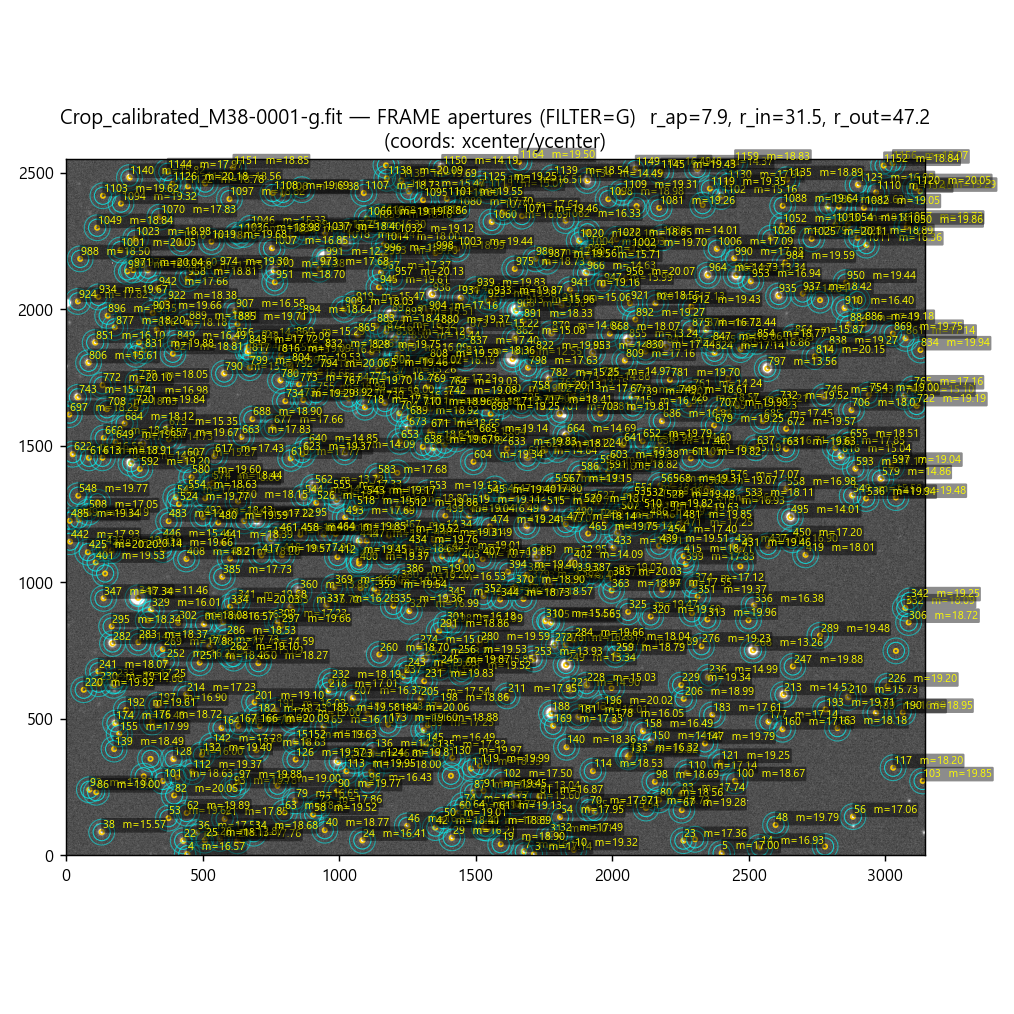

[Cell13] frame=Crop_calibrated_M38-0001-g.fit | N(ID)=710 | frame_xy_ok=710 | ref_xy_ok=710
[Cell13] ref→frame shift(px): min/med/max = 0.185 / 2.468 / 7.736  (N=710)


In [19]:
# === Cell 13 (REVISED) — Aperture/Annulus overlay (FRAME 좌표 기반 + ID/등급 라벨) ===
# 목적:
# - Cell12에서 실제 측광한 프레임별 중심(xcenter/ycenter 또는 x_init/y_init)을 기준으로 aperture/annulus overlay
# - (옵션) ref(master x_ref/y_ref)도 같이 얇게 그려서 오프셋 디버깅 가능
# - (옵션) ref→frame 오프셋 벡터(화살표) 표시

import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize

RESULT_DIR = Path(RESULT_DIR)
CACHE_DIR  = Path(CACHE_DIR)

# -----------------------------
# utils
# -----------------------------
def _as_bool(x, default=False):
    if isinstance(x, bool): return x
    if x is None: return default
    if isinstance(x, (int, np.integer)): return bool(x)
    s = str(x).strip().lower()
    if s in ("1","true","t","yes","y","on"): return True
    if s in ("0","false","f","no","n","off"): return False
    return default

def _get_filter_lower(fits_path: Path):
    try:
        h = fits.getheader(fits_path)
        f = h.get("FILTER", None)
        if f is None:
            return "unknown"
        return str(f).strip().lower()
    except Exception:
        return "unknown"

def _pick_col(cols, cands):
    for c in cands:
        if c in cols:
            return c
    return None

# -----------------------------
# 표시 옵션 (parameter.txt 키)
# -----------------------------
LABEL_LIMIT          = int(getattr(P, "overlay_max_labels", 2000))
LABEL_FONT_SIZE      = float(getattr(P, "overlay_label_fontsize", 6.0))
LABEL_OFFSET         = float(getattr(P, "overlay_label_offset_px", 3.0))
SHOW_ID_WHEN_NO_MAG  = _as_bool(getattr(P, "overlay_show_id_when_no_mag", False), False)

# ✅ 새 옵션들(없으면 기본값)
USE_PHOT_CENTROID    = _as_bool(getattr(P, "overlay_use_phot_centroid", True), True)   # xcenter/ycenter 우선 사용
SHOW_REF_POS         = _as_bool(getattr(P, "overlay_show_ref_pos", True), True)        # ref 좌표도 같이 표시
SHOW_SHIFT_VECTORS   = _as_bool(getattr(P, "overlay_show_shift_vectors", False), False)# ref→frame 화살표
SHIFT_VEC_LIMIT      = int(getattr(P, "overlay_shift_max_vectors", 300))               # 화살표 최대 개수
SHIFT_VEC_MIN_PX     = float(getattr(P, "overlay_shift_min_px", 1.5))                  # 이 값보다 작은 shift는 안 그림

# 대상 프레임
idx = int(getattr(P, "inspect_index", 0))
idx = max(0, min(idx, len(r_filenames)-1))
fname = r_filenames[idx]
fpath = RESULT_DIR / fname

# -----------------------------
# 데이터 로드
# -----------------------------
img = fits.getdata(fpath).astype(float)

master = pd.read_csv(RESULT_DIR/"master_catalog.tsv", sep="\t")
df_ap  = pd.read_csv(RESULT_DIR/"aperture_by_frame.csv")

row = df_ap[df_ap["file"].astype(str) == str(fname)]
if row.empty:
    raise RuntimeError(f"aperture_by_frame.csv에 {fname} 레코드 없음(8번 셀 실행 필요).")
r_ap  = float(row["r_ap"].values[0])
r_in  = float(row["r_in"].values[0])
r_out = float(row["r_out"].values[0])

# phot 결과(있으면 최우선)
phot_path = RESULT_DIR / f"{fname}_photometry.tsv"
phot = None
if phot_path.exists():
    try:
        phot = pd.read_csv(phot_path, sep="\t")
    except Exception:
        phot = None

# -----------------------------
# 프레임 좌표 테이블 만들기: lab_frame(ID, x_frame, y_frame, mag...)
# 우선순위:
# 1) photometry.tsv (xcenter/ycenter or x_init/y_init)
# 2) frame_sourceid_to_ID.tsv (있으면)
# 3) CACHE_DIR/idmatch/idmatch_{fname}.csv + sourceid_to_ID.csv/master 매핑
# -----------------------------
lab_frame = None

if phot is not None and ("ID" in phot.columns):
    cols = phot.columns

    cx = "xcenter" if "xcenter" in cols else None
    cy = "ycenter" if "ycenter" in cols else None
    ix = "x_init"  if "x_init"  in cols else None
    iy = "y_init"  if "y_init"  in cols else None

    # 중심 선택: centroid 우선(옵션), 없으면 init
    if USE_PHOT_CENTROID and (cx is not None) and (cy is not None):
        x_use = phot[cx].to_numpy(float)
        y_use = phot[cy].to_numpy(float)
        # NaN이면 init로 백업
        if (ix is not None) and (iy is not None):
            mnan = ~np.isfinite(x_use) | ~np.isfinite(y_use)
            x_use[mnan] = phot[ix].to_numpy(float)[mnan]
            y_use[mnan] = phot[iy].to_numpy(float)[mnan]
    else:
        if (ix is None) or (iy is None):
            # init도 없으면 center라도 사용
            if (cx is None) or (cy is None):
                raise RuntimeError(f"{phot_path.name}에 x/y 좌표 컬럼이 없습니다. (xcenter/ycenter 또는 x_init/y_init 필요)")
            x_use = phot[cx].to_numpy(float)
            y_use = phot[cy].to_numpy(float)
        else:
            x_use = phot[ix].to_numpy(float)
            y_use = phot[iy].to_numpy(float)

    lab_frame = pd.DataFrame({
        "ID": phot["ID"].astype(int).to_numpy(),
        "x_frame": x_use,
        "y_frame": y_use,
    })

    # mag
    if "mag" in cols:
        lab_frame["mag"] = phot["mag"].to_numpy(float)
    else:
        lab_frame["mag"] = np.nan
    if "mag_err" in cols:
        lab_frame["mag_err"] = phot["mag_err"].to_numpy(float)
    else:
        lab_frame["mag_err"] = np.nan

else:
    # 2) frame_sourceid_to_ID.tsv
    fm_path = RESULT_DIR / "frame_sourceid_to_ID.tsv"
    if fm_path.exists():
        try:
            fm = pd.read_csv(fm_path, sep="\t")
            c_file = _pick_col(fm.columns, ["file","fname","frame"])
            c_id   = _pick_col(fm.columns, ["ID","id"])
            c_x    = _pick_col(fm.columns, ["x","x_det","x_pix","x0"])
            c_y    = _pick_col(fm.columns, ["y","y_det","y_pix","y0"])
            if c_file and c_id and c_x and c_y:
                sub = fm[fm[c_file].astype(str) == str(fname)].copy()
                if len(sub):
                    lab_frame = pd.DataFrame({
                        "ID": sub[c_id].astype(int).to_numpy(),
                        "x_frame": sub[c_x].astype(float).to_numpy(),
                        "y_frame": sub[c_y].astype(float).to_numpy(),
                        "mag": np.nan,
                        "mag_err": np.nan,
                    })
        except Exception:
            lab_frame = None

    # 3) idmatch + mapping
    if lab_frame is None:
        idm_path = CACHE_DIR / "idmatch" / f"idmatch_{fname}.csv"
        if idm_path.exists():
            idm = pd.read_csv(idm_path)
            c_sid = _pick_col(idm.columns, ["source_id","sourceid","sid"])
            c_x   = _pick_col(idm.columns, ["x","x_det","x_pix","x0"])
            c_y   = _pick_col(idm.columns, ["y","y_det","y_pix","y0"])
            if c_sid and c_x and c_y:
                sid = idm[c_sid].astype(np.int64).to_numpy()
                x   = idm[c_x].astype(float).to_numpy()
                y   = idm[c_y].astype(float).to_numpy()

                # source_id -> ID
                map_path = RESULT_DIR / "sourceid_to_ID.csv"
                if map_path.exists():
                    mp = pd.read_csv(map_path)
                    if ("source_id" in mp.columns) and ("ID" in mp.columns):
                        sid2id = dict(zip(mp["source_id"].astype(np.int64), mp["ID"].astype(int)))
                    else:
                        sid2id = dict(zip(master["source_id"].astype(np.int64), master["ID"].astype(int)))
                else:
                    sid2id = dict(zip(master["source_id"].astype(np.int64), master["ID"].astype(int)))

                ID = np.array([sid2id.get(s, -1) for s in sid], dtype=int)
                ok = ID >= 0
                lab_frame = pd.DataFrame({
                    "ID": ID[ok],
                    "x_frame": x[ok],
                    "y_frame": y[ok],
                    "mag": np.nan,
                    "mag_err": np.nan,
                }).drop_duplicates("ID", keep="first").reset_index(drop=True)

if lab_frame is None or len(lab_frame) == 0:
    raise RuntimeError(f"[Cell13] {fname}: 프레임 좌표를 만들 수 없습니다. (photometry/frame_map/idmatch 확인)")

# ref 좌표 붙이기(디버깅용)
lab = lab_frame.merge(master[["ID","x_ref","y_ref"]], on="ID", how="left")

# -----------------------------
# 라벨 선택(밝은 순 우선)
# -----------------------------
lab["_has_mag"] = np.isfinite(lab.get("mag", np.nan))
lab["_mag_for_sort"] = lab["mag"].fillna(99.0) if "mag" in lab.columns else 99.0
lab = lab.sort_values(by=["_has_mag","_mag_for_sort","ID"], ascending=[False, True, True])
lab_sel = lab.head(LABEL_LIMIT).copy()

# -----------------------------
# 디스플레이
# -----------------------------
vmin, vmax = ZScaleInterval().get_limits(img)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(7.8, 7.8), dpi=130)
plt.imshow(img, origin="lower", cmap="gray", norm=norm)

filt = _get_filter_lower(fpath).upper()
plt.title(
    f"{fname} — FRAME apertures (FILTER={filt})  r_ap={r_ap:.1f}, r_in={r_in:.1f}, r_out={r_out:.1f}\n"
    f"(coords: {'xcenter/ycenter' if (phot is not None and USE_PHOT_CENTROID) else 'x_init/y_init or idmatch'})"
)

ax = plt.gca()

# 1) 프레임 좌표 기준 원
xy_frame = lab[["x_frame","y_frame"]].to_numpy(float)
xy_frame = xy_frame[np.isfinite(xy_frame).all(axis=1)]
for (x, y) in xy_frame:
    ax.add_patch(Circle((x, y), r_ap,  ec="gold", fc="none", lw=0.9, alpha=0.95))
    ax.add_patch(Circle((x, y), r_in,  ec="cyan", fc="none", lw=0.6, alpha=0.70))
    ax.add_patch(Circle((x, y), r_out, ec="cyan", fc="none", lw=0.6, alpha=0.50))

# 2) (옵션) ref 좌표도 얇게 표시
if SHOW_REF_POS:
    xy_ref = lab[["x_ref","y_ref"]].to_numpy(float)
    xy_ref = xy_ref[np.isfinite(xy_ref).all(axis=1)]
    for (x, y) in xy_ref:
        ax.add_patch(Circle((x, y), r_ap, ec="orange", fc="none", lw=0.4, alpha=0.35))

# 3) (옵션) ref→frame 오프셋 벡터
if SHOW_SHIFT_VECTORS and SHOW_REF_POS:
    sub = lab.copy()
    m = np.isfinite(sub["x_ref"]) & np.isfinite(sub["y_ref"]) & np.isfinite(sub["x_frame"]) & np.isfinite(sub["y_frame"])
    sub = sub.loc[m].copy()
    sub["dx"] = sub["x_frame"] - sub["x_ref"]
    sub["dy"] = sub["y_frame"] - sub["y_ref"]
    sub["dr"] = np.hypot(sub["dx"], sub["dy"])
    sub = sub[sub["dr"] >= SHIFT_VEC_MIN_PX].sort_values("dr", ascending=False).head(SHIFT_VEC_LIMIT)

    for _, r in sub.iterrows():
        x0, y0 = float(r["x_ref"]), float(r["y_ref"])
        x1, y1 = float(r["x_frame"]), float(r["y_frame"])
        arr = FancyArrowPatch((x0, y0), (x1, y1),
                              arrowstyle='->', mutation_scale=8,
                              lw=0.6, color='magenta', alpha=0.65)
        ax.add_patch(arr)

# 4) 라벨(프레임 좌표 기준)
for _, r in lab_sel.iterrows():
    x = float(r["x_frame"]); y = float(r["y_frame"])
    if (not np.isfinite(x)) or (not np.isfinite(y)):
        continue
    ID = int(r["ID"])
    if ("mag" in r) and np.isfinite(r["mag"]):
        txt = f"{ID}  m={float(r['mag']):.2f}"
    else:
        if not SHOW_ID_WHEN_NO_MAG:
            continue
        txt = f"{ID}"

    ax.text(
        x + LABEL_OFFSET, y + LABEL_OFFSET, txt,
        color="yellow", fontsize=LABEL_FONT_SIZE, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.12", fc=(0,0,0,0.45), ec="none")
    )

plt.xlim(0, img.shape[1])
plt.ylim(0, img.shape[0])
plt.tight_layout()
plt.show()

# 간단 디버깅 출력
n_ref_ok = int(np.isfinite(lab["x_ref"]).sum()) if "x_ref" in lab.columns else 0
n_fr_ok  = int(np.isfinite(lab["x_frame"]).sum()) if "x_frame" in lab.columns else 0
print(f"[Cell13] frame={fname} | N(ID)={len(lab)} | frame_xy_ok={n_fr_ok} | ref_xy_ok={n_ref_ok}")
if SHOW_REF_POS and ("x_ref" in lab.columns):
    m = np.isfinite(lab["x_ref"]) & np.isfinite(lab["y_ref"]) & np.isfinite(lab["x_frame"]) & np.isfinite(lab["y_frame"])
    if m.any():
        dr = np.hypot(lab.loc[m,"x_frame"]-lab.loc[m,"x_ref"], lab.loc[m,"y_frame"]-lab.loc[m,"y_ref"])
        print(f"[Cell13] ref→frame shift(px): min/med/max = {dr.min():.3f} / {np.median(dr):.3f} / {dr.max():.3f}  (N={m.sum()})")


In [20]:
# === Cell 14 — (A) median_by_ID_filter 생성 + (B) Gaia 매칭 + (C) SDSS 표준화 + (D) SDSS/GAIA CMD wide 저장 ===
import json
import numpy as np
import pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
import astropy.units as u

RESULT_DIR = Path(RESULT_DIR)

# ------------------------------------------------------------
# [A] photometry index -> (ID, FILTER)별 중앙값 집계 -> wide 생성
# ------------------------------------------------------------
def _pick_col(cols, cands):
    for c in cands:
        if c in cols:
            return c
    return None

def _resolve_path(p):
    p = str(p) if p is not None else ""
    if p.strip() == "":
        return None
    P0 = Path(p)
    if P0.is_absolute() and P0.exists():
        return P0
    for base in (RESULT_DIR, RESULT_DIR/"phot", RESULT_DIR/"photometry", RESULT_DIR/"result"):
        P1 = base / p
        if P1.exists():
            return P1
    return None

def _robust_median_and_err(arr):
    x = np.asarray(arr, float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return (np.nan, np.nan, 0)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)))
    err = float(1.4826 * mad / np.sqrt(max(len(x), 1)))
    return (med, err, int(len(x)))

# index 찾기
idx_candidates = [
    RESULT_DIR/"photometry_index.csv",
    RESULT_DIR/"phot_index.csv",
    RESULT_DIR/"phot"/"phot_index.csv",
    RESULT_DIR/"phot"/"photometry_index.csv",
]
idx_candidates += sorted(RESULT_DIR.glob("*phot*index*.csv"))
if (RESULT_DIR/"phot").exists():
    idx_candidates += sorted((RESULT_DIR/"phot").glob("*phot*index*.csv"))

idx_path = next((p for p in idx_candidates if p.exists()), None)
if idx_path is None:
    raise FileNotFoundError(
        "photometry index(csv)를 찾지 못했습니다.\n"
        "→ Forced photometry 셀에서 index 생성 여부 확인!"
    )

idx = pd.read_csv(idx_path)
print(f"[Cell14-A] index = {idx_path.name} | rows={len(idx)}")

# path/file/filter 컬럼 정리
if "path" not in idx.columns:
    for cand in ("phot_tsv","tsv","out","output"):
        if cand in idx.columns:
            idx = idx.rename(columns={cand:"path"})
            break

if "file" not in idx.columns:
    c_file = _pick_col(idx.columns, ["fname","frame","image","fits","name"])
    if c_file:
        idx = idx.rename(columns={c_file:"file"})

if "filter" in idx.columns:
    idx["filter"] = idx["filter"].astype(str).str.strip().str.lower()
elif "FILTER" in idx.columns:
    idx["filter"] = idx["FILTER"].astype(str).str.strip().str.lower()
else:
    idx["filter"] = "unknown"

# QC 통과만
fq_path = RESULT_DIR/"frame_quality.csv"
if fq_path.exists() and ("file" in idx.columns):
    fq = pd.read_csv(fq_path)
    if ("file" in fq.columns) and ("passed" in fq.columns):
        idx = idx.merge(fq[["file","passed"]], on="file", how="left")
        before = len(idx)
        idx = idx[idx["passed"] != False].copy()
        print(f"[Cell14-A] QC passed only: {before} -> {len(idx)}")

# median 집계 시 적용할 SNR 컷 (없으면 0)
min_snr_for_mag = float(getattr(P, "min_snr_for_mag", 0.0))

rows = []
n_missing = 0
for _, r in idx.iterrows():
    p = _resolve_path(r.get("path",""))
    if p is None or (not p.exists()):
        n_missing += 1
        continue

    try:
        dfp = pd.read_csv(p, sep="\t")
    except Exception:
        dfp = pd.read_csv(p)

    if "ID" not in dfp.columns:
        raise RuntimeError(f"[Cell14-A] {p.name}: ID 컬럼 없음")

    if "FILTER" in dfp.columns:
        dfp["FILTER"] = dfp["FILTER"].astype(str).str.strip().str.lower()
    else:
        dfp["FILTER"] = str(r.get("filter","unknown")).strip().lower()

    mag_col = None
    for cand in ("mag_inst", "mag", "mag_ap", "mag_apcorr"):
        if cand in dfp.columns:
            mag_col = cand
            break
    if mag_col is None:
        raise RuntimeError(f"[Cell14-A] {p.name}: mag_inst/mag 계열 컬럼을 못 찾음")

    err_col = None
    for cand in ("mag_err", "emag", "emag_inst", "magerr"):
        if cand in dfp.columns:
            err_col = cand
            break
    if err_col is None:
        dfp["mag_err"] = np.nan
        err_col = "mag_err"

    snr_col = "snr" if "snr" in dfp.columns else None

    tmp = dfp[["ID","FILTER",mag_col,err_col] + ([snr_col] if snr_col else [])].copy()
    tmp = tmp.rename(columns={mag_col:"mag_inst", err_col:"mag_err"})
    if snr_col is None:
        tmp["snr"] = np.nan
    else:
        tmp = tmp.rename(columns={snr_col:"snr"})

    tmp["file"] = str(r.get("file","")) if ("file" in idx.columns) else ""

    if min_snr_for_mag > 0:
        m = np.isfinite(tmp["snr"].to_numpy(float))
        tmp = tmp[(~m) | (tmp["snr"].to_numpy(float) >= min_snr_for_mag)].copy()

    rows.append(tmp)

print(f"[Cell14-A] read frames: {len(rows)}  | missing paths: {n_missing}")

all_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["ID","FILTER","mag_inst","mag_err","snr","file"])
all_df["FILTER"] = all_df["FILTER"].astype(str).str.strip().str.lower()

print(f"[Cell14-A] merged rows={len(all_df)} | unique IDs={all_df['ID'].nunique()} | filters={sorted(all_df['FILTER'].unique())}")

# (ID, FILTER)별 중앙값
grp = (
    all_df.groupby(["ID","FILTER"])
    .agg(
        mag_inst_med=("mag_inst", lambda s: _robust_median_and_err(s)[0]),
        mag_inst_med_err=("mag_inst", lambda s: _robust_median_and_err(s)[1]),
        n_frames=("mag_inst", lambda s: _robust_median_and_err(s)[2]),
        snr_med=("snr", lambda s: float(np.nanmedian(np.asarray(s, float))) if np.isfinite(np.asarray(s, float)).any() else np.nan),
    )
    .reset_index()
)

grp_path = RESULT_DIR/"median_by_ID_filter.csv"
grp.to_csv(grp_path, index=False, na_rep="NaN")
print(f"[Cell14-A] Saved → {grp_path.name} | rows={len(grp)}")

wide_mag = grp.pivot_table(index="ID", columns="FILTER", values="mag_inst_med", aggfunc="median")
wide_err = grp.pivot_table(index="ID", columns="FILTER", values="mag_inst_med_err", aggfunc="median")
wide_snr = grp.pivot_table(index="ID", columns="FILTER", values="snr_med", aggfunc="median")

wide_mag.columns = [f"mag_inst_{c}" for c in wide_mag.columns]
wide_err.columns = [f"mag_inst_err_{c}" for c in wide_err.columns]
wide_snr.columns = [f"snr_{c}" for c in wide_snr.columns]

wide = pd.concat([wide_mag, wide_err, wide_snr], axis=1).reset_index()

wide_path = RESULT_DIR/"median_by_ID_filter_wide.csv"
wide.to_csv(wide_path, index=False, na_rep="NaN")
print(f"[Cell14-A] Saved → {wide_path.name} | rows={len(wide)}")


# ------------------------------------------------------------
# [B] MASTER 픽셀 -> WCS -> Gaia 매칭
# ------------------------------------------------------------
master_path = RESULT_DIR/"master_catalog.tsv"
if not master_path.exists():
    raise FileNotFoundError("master_catalog.tsv가 없습니다. (마스터 생성 셀 확인)")
master = pd.read_csv(master_path, sep="\t")
if "ID" not in master.columns:
    raise RuntimeError("master_catalog.tsv에 ID 컬럼이 없습니다.")

col_xm = _pick_col(master.columns, ["x_ref","x","x_pix","x_center","x_med"])
col_ym = _pick_col(master.columns, ["y_ref","y","y_pix","y_center","y_med"])
if col_xm is None or col_ym is None:
    raise RuntimeError(f"master_catalog.tsv에서 x/y 컬럼을 못 찾음. cols={list(master.columns)[:30]}")

df = wide.merge(master[["ID", col_xm, col_ym]].rename(columns={col_xm:"x_pix", col_ym:"y_pix"}), on="ID", how="left")
n_xy = int(np.isfinite(df["x_pix"]).sum())
print(f"[Cell14-B] merge coords from master ({col_xm},{col_ym}) | xy_ok={n_xy}/{len(df)}")
if n_xy < 3:
    raise RuntimeError("x_pix/y_pix 유효값이 너무 적습니다. (ID 불일치 가능)")

def _has_wcs(header):
    try:
        w0 = WCS(header)
        return bool(w0.has_celestial)
    except Exception:
        return False

def load_ref_wcs():
    for key in ("ref_fits", "ref_frame", "ref_image", "ref_path"):
        p = getattr(P, key, None)
        if p:
            fp = Path(p)
            if not fp.is_absolute():
                fp = RESULT_DIR / fp
            if fp.exists():
                hdr = fits.getheader(fp)
                if _has_wcs(hdr):
                    print(f"[Cell14-B] WCS from P.{key}: {fp.name}")
                    return WCS(hdr), fp

    for name in ("ref_fits", "ref_frame_path", "ref_path", "ref_file", "ref_filename"):
        if name in globals():
            try:
                fp = Path(globals()[name])
                if not fp.is_absolute():
                    fp = RESULT_DIR / fp
                if fp.exists():
                    hdr = fits.getheader(fp)
                    if _has_wcs(hdr):
                        print(f"[Cell14-B] WCS from global '{name}': {fp.name}")
                        return WCS(hdr), fp
            except Exception:
                pass

    patterns = ["ref*.fit*", "rc_*.fit*", "crop_*.fit*", "*.fit*"]
    tried = 0
    for pat in patterns:
        for fp in sorted(RESULT_DIR.glob(pat)):
            tried += 1
            try:
                hdr = fits.getheader(fp)
                if _has_wcs(hdr):
                    print(f"[Cell14-B] WCS auto-detected: {fp.name} (pattern={pat}, tried={tried})")
                    return WCS(hdr), fp
            except Exception:
                continue
    return None, None

w, wcs_src = load_ref_wcs()
if w is None:
    print("[Cell14-B] ❌ WCS를 찾지 못했습니다. → Gaia 매칭/표준화 스킵(중앙값까지만 생성).")
    raise SystemExit

pix_scale_arcsec = float(getattr(P, "pixel_scale_arcsec", np.nan))
if (not np.isfinite(pix_scale_arcsec)) or (pix_scale_arcsec <= 0):
    s_deg = proj_plane_pixel_scales(w)
    pix_scale_arcsec = float(np.nanmedian(s_deg) * 3600.0)
    print(f"[Cell14-B] pixel_scale_arcsec auto from WCS: {pix_scale_arcsec:.6f}")

gaia_path = RESULT_DIR/"gaia_fov.ecsv"
if not gaia_path.exists():
    raise FileNotFoundError("gaia_fov.ecsv가 없습니다. (Gaia 저장 확인)")
t_gaia = Table.read(gaia_path, format="ascii.ecsv")
for k in ("ra","dec","phot_g_mean_mag"):
    if k not in t_gaia.colnames:
        raise RuntimeError(f"gaia_fov.ecsv에 '{k}' 없음")

gaia_sky = SkyCoord(t_gaia["ra"], t_gaia["dec"], unit="deg", frame="icrs")
print(f"[Cell14-B] Gaia N={len(t_gaia)}")

x = df["x_pix"].to_numpy(float)
y = df["y_pix"].to_numpy(float)
m_xy = np.isfinite(x) & np.isfinite(y)

ra = np.full(len(df), np.nan); dec = np.full(len(df), np.nan)
ra_t, dec_t = w.all_pix2world(x[m_xy], y[m_xy], 0)
ra[m_xy] = np.asarray(ra_t, float)
dec[m_xy] = np.asarray(dec_t, float)
sky_m = SkyCoord(ra*u.deg, dec*u.deg, frame="icrs")

match_tol_px = float(getattr(P, "match_tol_px", 1.0))
match_tol_arcsec = match_tol_px * pix_scale_arcsec

idx_m, sep2d, _ = sky_m.match_to_catalog_sky(gaia_sky)
m = np.isfinite(sep2d.arcsec) & (sep2d.arcsec <= match_tol_arcsec)

dfm = df.loc[m].copy()
dfm["gaia_idx"] = idx_m[m].astype(int)
dfm["sep_arcsec"] = sep2d.arcsec[m].astype(float)
dfm["dist_px"] = dfm["sep_arcsec"] / pix_scale_arcsec

print(f"[Cell14-B] match_tol_px={match_tol_px:.2f} (= {match_tol_arcsec:.2f}\") | matched N={len(dfm)}")
if len(dfm):
    print(f"[Cell14-B] dist_px min/med/max = {dfm['dist_px'].min():.3f} / {dfm['dist_px'].median():.3f} / {dfm['dist_px'].max():.3f}")

MIN_MATCH = int(getattr(P, "min_master_gaia_matches", 10))
if len(dfm) < MIN_MATCH:
    dfm.to_csv(RESULT_DIR/"gaia_sdss_calibrator_by_ID.csv", index=False)
    raise RuntimeError("Gaia 매칭 수 부족으로 표준화 불가")


# ------------------------------------------------------------
# [C] Gaia -> SDSS reference + inst -> SDSS(std) (zp + 색항)
# ------------------------------------------------------------
def poly_eval(x, coeffs):
    x = np.asarray(x, float)
    y = np.zeros_like(x, dtype=float)
    p = np.ones_like(x, dtype=float)
    for a in coeffs:
        y += a * p
        p *= x
    return y

def robust_linfit(x, y, clip_sigma=3.0, iters=5, slope_absmax=1.0, min_n=10):
    """
    y = zp + ct*x  (sigma-clip)
    return (zp, ct, N_used)
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    m0 = np.isfinite(x) & np.isfinite(y)
    x = x[m0]; y = y[m0]
    if len(x) < min_n:
        return (float(np.nanmedian(y)) if len(y) else np.nan, 0.0, int(len(x)))

    ct, zp = np.polyfit(x, y, 1)

    for _ in range(int(iters)):
        yhat = zp + ct*x
        r = y - yhat
        med = np.nanmedian(r)
        mad = np.nanmedian(np.abs(r - med)) + 1e-12
        sig = 1.4826 * mad
        keep = np.abs(r - med) <= float(clip_sigma) * sig
        if keep.sum() < min_n:
            break
        ct, zp = np.polyfit(x[keep], y[keep], 1)
        x, y = x[keep], y[keep]

    if abs(ct) > float(slope_absmax):
        return (float(np.nanmedian(y)), 0.0, int(len(x)))

    return float(zp), float(ct), int(len(x))

# Gaia mags
gG = np.asarray(t_gaia["phot_g_mean_mag"])[dfm["gaia_idx"].to_numpy(int)]
bp = np.asarray(t_gaia["phot_bp_mean_mag"])[dfm["gaia_idx"].to_numpy(int)] if "phot_bp_mean_mag" in t_gaia.colnames else np.full(len(dfm), np.nan)
rp = np.asarray(t_gaia["phot_rp_mean_mag"])[dfm["gaia_idx"].to_numpy(int)] if "phot_rp_mean_mag" in t_gaia.colnames else np.full(len(dfm), np.nan)
bprp = bp - rp

out_cal = dfm.copy()
out_cal["gaia_G"] = gG
out_cal["gaia_BP"] = bp
out_cal["gaia_RP"] = rp
out_cal["gaia_BP_RP"] = bprp

# (Riello+ poly; 기존 계수 유지)
xcol = out_cal["gaia_BP_RP"].to_numpy(float)
G = out_cal["gaia_G"].to_numpy(float)

m_g = np.isfinite(xcol) & (xcol >= 0.3) & (xcol <= 3.0)
m_r = np.isfinite(xcol) & (xcol >= 0.0) & (xcol <= 3.0)
m_i = np.isfinite(xcol) & (xcol >= 0.5) & (xcol <= 2.0)

G_minus_g = np.full_like(G, np.nan)
G_minus_r = np.full_like(G, np.nan)
G_minus_i = np.full_like(G, np.nan)

G_minus_g[m_g] = poly_eval(xcol[m_g], [0.2199, -0.6365, -0.1548, 0.0064])
G_minus_r[m_r] = poly_eval(xcol[m_r], [-0.09837, 0.08592, 0.1907, -0.1701, 0.02263])
G_minus_i[m_i] = poly_eval(xcol[m_i], [-0.293, 0.6404, -0.09609, -0.002104])

out_cal["sdss_g_ref"] = G - G_minus_g
out_cal["sdss_r_ref"] = G - G_minus_r
out_cal["sdss_i_ref"] = G - G_minus_i

# SNR 컷(캘리브레이터: SDSS 표준화용) — 기존과 동일(필요시 파라미터로 조절)
snr_cut_sdss = float(getattr(P, "cmd_snr_calib_min", 20.0))
m_snr_sdss = np.ones(len(out_cal), dtype=bool)
for band in ("g","r","i"):
    sc = f"snr_{band}"
    if sc in out_cal.columns:
        svals = out_cal[sc].to_numpy(float)
        m_snr_sdss &= np.isfinite(svals) & (svals >= snr_cut_sdss)

def _arr(col):
    return out_cal[col].to_numpy(float) if col in out_cal.columns else np.full(len(out_cal), np.nan)

g_inst = _arr("mag_inst_g")
r_inst = _arr("mag_inst_r")
i_inst = _arr("mag_inst_i")

color_gr = g_inst - r_inst
color_ri = r_inst - i_inst

clip_sigma = float(getattr(P, "zp_clip_sigma", 3.0))
fit_iters  = int(getattr(P, "zp_fit_iters", 5))
slope_absmax = float(getattr(P, "zp_slope_absmax", 1.0))

# g
delta_g = out_cal["sdss_g_ref"].to_numpy(float) - g_inst
mg = np.isfinite(delta_g) & np.isfinite(color_gr) & np.isfinite(g_inst) & m_snr_sdss
zp_g, ct_g, Ng = robust_linfit(color_gr[mg], delta_g[mg],
                               clip_sigma=clip_sigma, iters=fit_iters,
                               slope_absmax=slope_absmax, min_n=MIN_MATCH)

# r
delta_r = out_cal["sdss_r_ref"].to_numpy(float) - r_inst
mr = np.isfinite(delta_r) & np.isfinite(color_gr) & np.isfinite(r_inst) & m_snr_sdss
zp_r, ct_r, Nr = robust_linfit(color_gr[mr], delta_r[mr],
                               clip_sigma=clip_sigma, iters=fit_iters,
                               slope_absmax=slope_absmax, min_n=MIN_MATCH)

# i
delta_i = out_cal["sdss_i_ref"].to_numpy(float) - i_inst
mi = np.isfinite(delta_i) & np.isfinite(color_ri) & np.isfinite(i_inst) & m_snr_sdss
zp_i, ct_i, Ni = robust_linfit(color_ri[mi], delta_i[mi],
                               clip_sigma=clip_sigma, iters=fit_iters,
                               slope_absmax=slope_absmax, min_n=MIN_MATCH)

print(f"[Cell14-C] g_std = g_inst + {zp_g:+.4f} + {ct_g:+.4f}*(g-r)_inst   (N={Ng})")
print(f"[Cell14-C] r_std = r_inst + {zp_r:+.4f} + {ct_r:+.4f}*(g-r)_inst   (N={Nr})")
print(f"[Cell14-C] i_std = i_inst + {zp_i:+.4f} + {ct_i:+.4f}*(r-i)_inst   (N={Ni})")

out_cal_path = RESULT_DIR/"gaia_sdss_calibrator_by_ID.csv"
out_cal.to_csv(out_cal_path, index=False)
print(f"[Cell14-C] Saved → {out_cal_path.name} | rows={len(out_cal)}")


# ------------------------------------------------------------
# [D] (1) wide 전체에 SDSS 표준화 적용
#     (2) SDSS(std) -> synthetic Gaia (fallback)
#     (3) inst(g,i) -> Gaia(G, BP-RP) 직접 캘리브레이션 (권장/우선)
# ------------------------------------------------------------
df_out = df.copy()

gI = df_out["mag_inst_g"].to_numpy(float) if "mag_inst_g" in df_out.columns else np.full(len(df_out), np.nan)
rI = df_out["mag_inst_r"].to_numpy(float) if "mag_inst_r" in df_out.columns else np.full(len(df_out), np.nan)
iI = df_out["mag_inst_i"].to_numpy(float) if "mag_inst_i" in df_out.columns else np.full(len(df_out), np.nan)

grI = gI - rI
riI = rI - iI
giI = gI - iI

# SDSS(std)
df_out["mag_std_g"] = gI + zp_g + ct_g * grI
df_out["mag_std_r"] = rI + zp_r + ct_r * grI
df_out["mag_std_i"] = iI + zp_i + ct_i * riI

# (D-2) SDSS(std) -> synthetic Gaia (기존 식 유지: g-i 기반)
gi_std = df_out["mag_std_g"].to_numpy(float) - df_out["mag_std_i"].to_numpy(float)
m_gi_std = np.isfinite(gi_std) & (gi_std >= 1.0) & (gi_std <= 9.0)

G_minus_g_from_gi = np.full(len(df_out), np.nan)
BPmRP_from_gi     = np.full(len(df_out), np.nan)

G_minus_g_from_gi[m_gi_std] = poly_eval(gi_std[m_gi_std], [-0.1064, -0.4964, -0.09339, 0.004444])
BPmRP_from_gi[m_gi_std]     = poly_eval(gi_std[m_gi_std], [0.3971, 0.777, -0.04164, 0.008237])

df_out["gaia_G_syn"]     = df_out["mag_std_g"].to_numpy(float) + G_minus_g_from_gi
df_out["gaia_BP_RP_syn"] = BPmRP_from_gi

# --- (D-3) inst(g,i) -> Gaia 직접 캘리브레이션 (마스크 분리 버전: N 확 늘어남) ---
snr_cut_gaia = float(getattr(P, "gaia_snr_calib_min", 20.0))  # g,i만 적용
gi_min = float(getattr(P, "gaia_gi_min", -0.5))
gi_max = float(getattr(P, "gaia_gi_max",  4.5))

g_cal = out_cal["mag_inst_g"].to_numpy(float)
i_cal = out_cal["mag_inst_i"].to_numpy(float)
gi_cal = g_cal - i_cal

G_cal = out_cal["gaia_G"].to_numpy(float)             # 항상 있는 편
C_cal = out_cal["gaia_BP_RP"].to_numpy(float)         # BP/RP 없으면 NaN 가능

# SNR(g,i) 컷 (둘 다 있는 경우만 적용)
m_snr_gaia = np.ones(len(out_cal), dtype=bool)
for band in ("g","i"):
    sc = f"snr_{band}"
    if sc in out_cal.columns:
        sv = out_cal[sc].to_numpy(float)
        m_snr_gaia &= np.isfinite(sv) & (sv >= snr_cut_gaia)

# (1) G 피팅용: BP-RP 조건 빼고 G만으로
mG = (
    np.isfinite(gi_cal) & (gi_cal >= gi_min) & (gi_cal <= gi_max) &
    np.isfinite(g_cal) & np.isfinite(i_cal) &
    np.isfinite(G_cal) &
    m_snr_gaia
)

dG = G_cal - g_cal
zp_G, ct_G, N_G = robust_linfit(
    gi_cal[mG], dG[mG],
    clip_sigma=clip_sigma, iters=fit_iters,
    slope_absmax=float(getattr(P, "gaia_zp_slope_absmax", 1.0)),
    min_n=MIN_MATCH
)

# (2) 색(BP-RP) 피팅용: BP-RP 유효한 애들만
mC = (
    np.isfinite(gi_cal) & (gi_cal >= gi_min) & (gi_cal <= gi_max) &
    np.isfinite(g_cal) & np.isfinite(i_cal) &
    np.isfinite(C_cal) &
    m_snr_gaia
)

zp_C, ct_C, N_C = robust_linfit(
    gi_cal[mC], C_cal[mC],
    clip_sigma=clip_sigma, iters=fit_iters,
    slope_absmax=float(getattr(P, "gaia_color_slope_absmax", 2.0)),
    min_n=MIN_MATCH
)

print(f"[Cell14-D] Gaia(inst) calib:  G = g_inst + {zp_G:+.4f} + {ct_G:+.4f}*(g-i)_inst   (N={N_G})")
print(f"[Cell14-D] Gaia(inst) calib: (BP-RP) = {zp_C:+.4f} + {ct_C:+.4f}*(g-i)_inst   (N={N_C})")

# wide 전체 적용
gI = df_out["mag_inst_g"].to_numpy(float)
iI = df_out["mag_inst_i"].to_numpy(float)
giI = gI - iI

df_out["gaia_G_inst"] = gI + zp_G + ct_G * giI
df_out["gaia_BP_RP_inst"] = zp_C + ct_C * giI
out_cmd_path = RESULT_DIR / "median_by_ID_filter_wide_cmd.csv"
df_out.to_csv(out_cmd_path, index=False, na_rep="NaN")
print(f"[Cell14-D] Saved → {out_cmd_path.name} | rows={len(df_out)}")


[Cell14-A] index = photometry_index.csv | rows=9
[Cell14-A] QC passed only: 9 -> 8
[Cell14-A] read frames: 8  | missing paths: 0
[Cell14-A] merged rows=5571 | unique IDs=961 | filters=['g', 'i', 'r']
[Cell14-A] Saved → median_by_ID_filter.csv | rows=2409
[Cell14-A] Saved → median_by_ID_filter_wide.csv | rows=961
[Cell14-B] merge coords from master (x_ref,y_ref) | xy_ok=961/961
[Cell14-B] WCS from global 'ref_path': Crop_calibrated_M38-0001-r.fit
[Cell14-B] Gaia N=4160
[Cell14-B] match_tol_px=1.00 (= 0.39") | matched N=873
[Cell14-B] dist_px min/med/max = 0.000 / 0.314 / 0.998
[Cell14-C] g_std = g_inst + -2.6067 + +0.2020*(g-r)_inst   (N=182)
[Cell14-C] r_std = r_inst + -3.4173 + +0.0343*(g-r)_inst   (N=177)
[Cell14-C] i_std = i_inst + -4.5116 + +0.0464*(r-i)_inst   (N=104)
[Cell14-C] Saved → gaia_sdss_calibrator_by_ID.csv | rows=873
[Cell14-D] Gaia(inst) calib:  G = g_inst + -4.0052 + -0.8234*(g-i)_inst   (N=13)
[Cell14-D] Gaia(inst) calib: (BP-RP) = +1.8802 + +0.8576*(g-i)_inst   (N=1

In [33]:
# === Cell 15: CMD 플로터 (Instrumental / SDSS / Gaia) + OBAFGKM 스타일 색맵핑(색지수 기반) + 검은 배경 ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

from ipywidgets import (
    HBox, VBox, HTML,
    ToggleButtons, Dropdown, FloatSlider,
    Checkbox, Button, Layout, Output
)
from IPython.display import display

# -----------------------
# 0) Dark background
# -----------------------
plt.style.use("dark_background")  # ★ 배경/기본 글씨 흰색 테마

# -----------------------
# 1) 결과 디렉터리 & 로드
# -----------------------
try:
    RESULT = RESULT_DIR
except NameError:
    RESULT = Path("./result")
RESULT = Path(RESULT)

wide_path = RESULT / "median_by_ID_filter_wide_cmd.csv"
if not wide_path.exists():
    wide_path = RESULT / "median_by_ID_filter_wide.csv"
if not wide_path.exists():
    raise FileNotFoundError(f"[Cell15] wide CSV not found: {wide_path}")

df = pd.read_csv(wide_path).copy()

# --- SDSS 표준계 유무(mag_std_*) ---
std_cols_full = [c for c in df.columns if c.startswith("mag_std_")]
HAS_STD = (len(std_cols_full) > 0) and np.isfinite(df[std_cols_full].to_numpy(float)).any()

# --- Instrumental 밴드 ---
inst_bands = sorted({c.replace("mag_inst_","") for c in df.columns if c.startswith("mag_inst_")})
std_bands  = sorted({c.replace("mag_std_","")  for c in df.columns if c.startswith("mag_std_")}) if HAS_STD else []
all_bands  = sorted(set(inst_bands) | set(std_bands))

# -----------------------
# 2) 축 허용 조합 (X에 g-i 포함)
# -----------------------
X_ALLOWED = [("g","r"), ("r","i"), ("g","i")]
Y_ALLOWED_SCALARS = ["g","r","i"]
Y_ALLOWED_COLORS  = [("g","r"), ("r","i"), ("g","i")]

x_pairs = [(a,b) for (a,b) in X_ALLOWED if (a in inst_bands and b in inst_bands)]
y_scalar_opts = [b for b in Y_ALLOWED_SCALARS if b in inst_bands]
y_color_pairs = [(a,b) for (a,b) in Y_ALLOWED_COLORS if (a in inst_bands and b in inst_bands)]

# --- SNR 컬럼 ---
snr_cols = [c for c in df.columns if c.startswith("snr_")]
HAS_SNR = len(snr_cols) > 0
if HAS_SNR:
    snr_bands_available = sorted(c.replace("snr_","") for c in snr_cols)
    print("[Cell15] SNR bands:", snr_bands_available)
else:
    print("[Cell15] snr_* 없음 → SNR 슬라이더는 형식상만(필터링 없음).")

# --- Gaia CMD 컬럼: inst 우선, 없으면 syn ---
HAS_GAIA_INST = (
    {"gaia_G_inst","gaia_BP_RP_inst"}.issubset(df.columns)
    and np.isfinite(df["gaia_G_inst"].to_numpy(float)).any()
    and np.isfinite(df["gaia_BP_RP_inst"].to_numpy(float)).any()
)
HAS_GAIA_SYN = (
    {"gaia_G_syn","gaia_BP_RP_syn"}.issubset(df.columns)
    and np.isfinite(df["gaia_G_syn"].to_numpy(float)).any()
    and np.isfinite(df["gaia_BP_RP_syn"].to_numpy(float)).any()
)

GAIA_MODE = None
if HAS_GAIA_INST:
    GAIA_MODE = "inst"
    print("[Cell15] Gaia CMD: using gaia_G_inst / gaia_BP_RP_inst (preferred).")
elif HAS_GAIA_SYN:
    GAIA_MODE = "syn"
    print("[Cell15] Gaia CMD: using gaia_G_syn / gaia_BP_RP_syn (fallback).")
else:
    print("[Cell15] Gaia CMD columns not found → 우측 패널 비활성.")
HAS_GAIA = GAIA_MODE is not None

# -----------------------
# 3) 유틸
# -----------------------
def _col_mag(band: str, system: str) -> str:
    return f"mag_{system}_{band}"  # system: inst/std

def _col_snr(band: str) -> str:
    return f"snr_{band}"

def _label_color(a,b):
    return f"{a}-{b}"

def _get_y_mode(yval):
    if yval in y_scalar_opts:
        return ("scalar", yval)
    if isinstance(yval, str) and "-" in yval:
        a,b = yval.split("-",1)
        if (a,b) in y_color_pairs:
            return ("color", (a,b))
    return (None, None)

def _safe_float_col(series):
    return pd.to_numeric(series, errors="coerce").to_numpy(float)

# -----------------------
# 4) OBAFGKM 스타일 "Teff colormap" (오류 방지: pos 0~1)
# -----------------------
TEFF_VMIN = 2400.0
TEFF_VMAX = 40000.0
OB_NORM = Normalize(vmin=TEFF_VMIN, vmax=TEFF_VMAX, clip=True)

# 낮은 온도(빨강) -> 높은 온도(보라), 10000K는 "흰색" 고정
_TEFF_COLOR_ANCHORS = [
    (2400,  "#E53935"),  # very cool red
    (3200,  "#FF6A3D"),  # M orange-red
    (4500,  "#FFB84D"),  # K orange
    (5800,  "#FFE36A"),  # G yellow
    (6500,  "#FFF6C7"),  # F warm white
    (8000,  "#FFFFFF"),  # A/F white-ish
    (10000, "#FFFFFF"),  # ★ 10000K=흰색
    (20000, "#2D5BFF"),  # B blue
    (40000, "#7A3CFF"),  # O violet-ish
]
_TEFF_COLOR_ANCHORS = sorted(_TEFF_COLOR_ANCHORS, key=lambda x: x[0])
_pos = [(t - TEFF_VMIN) / (TEFF_VMAX - TEFF_VMIN) for t, _ in _TEFF_COLOR_ANCHORS]
_pos[0] = 0.0
_pos[-1] = 1.0

OB_CMAP = LinearSegmentedColormap.from_list(
    "obafgkm_like",
    list(zip(_pos, [c for _, c in _TEFF_COLOR_ANCHORS])),
    N=256
)
OB_CMAP.set_bad("#777777")

# colorbar tick: 온도값 + 분광형
_OB_TICKS = [
    (35000, "O"),
    (20000, "B"),
    (10000, "A"),
    ( 7500, "F"),
    ( 6000, "G"),
    ( 4500, "K"),
    ( 3200, "M"),
]
CB_TICKS = [t for t, _ in _OB_TICKS]
CB_LABS  = [f"{t:>5d} K  ({cls})" for t, cls in _OB_TICKS]

# -----------------------
# 5) 색지수 -> Teff(시각화용 매핑)
# -----------------------
_COLOR_TO_TEFF_ANCHORS = {
    "g-r": {
        "x": np.array([-0.40, -0.20,  0.00, 0.30, 0.45, 0.80, 1.40, 1.80], float),
        "t": np.array([35000, 20000, 10000, 7500, 6000, 4500, 3200, 2400], float),
    },
    "r-i": {
        "x": np.array([-0.30, -0.20, -0.05, 0.10, 0.20, 0.40, 0.80, 1.10], float),
        "t": np.array([35000, 20000, 10000, 7500, 6000, 4500, 3200, 2400], float),
    },
    "g-i": {
        "x": np.array([-0.70, -0.45,  0.00, 0.50, 0.80, 1.50, 2.60, 3.20], float),
        "t": np.array([35000, 20000, 10000, 7500, 6000, 4500, 3200, 2400], float),
    },
    "BP-RP": {
        "x": np.array([-0.40, -0.20, 0.00, 0.40, 0.80, 1.30, 2.30, 3.50], float),
        "t": np.array([35000, 20000, 10000, 7500, 6000, 4500, 3200, 2400], float),
    }
}

def _teff_from_color_index(color_x: np.ndarray, mode: str):
    a = _COLOR_TO_TEFF_ANCHORS.get(mode, None)
    if a is None or color_x.size == 0:
        return np.full_like(color_x, np.nan, dtype=float)
    x = np.asarray(color_x, float)
    teff = np.interp(x, a["x"], a["t"])
    return np.clip(teff, TEFF_VMIN, TEFF_VMAX)

# -----------------------
# 6) 데이터 계산 (X/Y + mask + xcolor)
# -----------------------
def _compute_arrays_and_mask(system: str, x_pair, y_choice, snr_cut: float):
    a, b = x_pair
    colAx = _col_mag(a, system)
    colBx = _col_mag(b, system)
    if (colAx not in df.columns) or (colBx not in df.columns):
        return np.array([]), np.array([]), np.zeros(len(df), bool), np.array([])

    Ax = _safe_float_col(df[colAx])
    Bx = _safe_float_col(df[colBx])
    xcolor = Ax - Bx
    x = xcolor

    y_mode, y_param = _get_y_mode(y_choice)
    involved = set([a,b])

    if y_mode == "scalar":
        by = y_param
        colY = _col_mag(by, system)
        if colY not in df.columns:
            return np.array([]), np.array([]), np.zeros(len(df), bool), np.array([])
        y = _safe_float_col(df[colY])
        involved.add(by)

    elif y_mode == "color":
        ya, yb = y_param
        colYa = _col_mag(ya, system)
        colYb = _col_mag(yb, system)
        if (colYa not in df.columns) or (colYb not in df.columns):
            return np.array([]), np.array([]), np.zeros(len(df), bool), np.array([])
        Ya = _safe_float_col(df[colYa])
        Yb = _safe_float_col(df[colYb])
        y = Ya - Yb
        involved.update([ya,yb])

    else:
        return np.array([]), np.array([]), np.zeros(len(df), bool), np.array([])

    mask = np.isfinite(x) & np.isfinite(y)

    snr_cut = float(snr_cut)
    if snr_cut > 0 and HAS_SNR:
        for band in involved:
            sc = _col_snr(band)
            if sc in df.columns:
                sv = _safe_float_col(df[sc])
                mask &= np.isfinite(sv) & (sv >= snr_cut)

    return x[mask], y[mask], mask, xcolor[mask]

def _compute_gaia_arrays_and_mask(snr_cut: float):
    if not HAS_GAIA:
        return np.array([]), np.array([]), np.zeros(len(df), bool), np.array([])

    if GAIA_MODE == "inst":
        G = _safe_float_col(df["gaia_G_inst"])
        C = _safe_float_col(df["gaia_BP_RP_inst"])
    else:
        G = _safe_float_col(df["gaia_G_syn"])
        C = _safe_float_col(df["gaia_BP_RP_syn"])

    mask = np.isfinite(G) & np.isfinite(C)

    snr_cut = float(snr_cut)
    if snr_cut > 0 and HAS_SNR:
        for band in ("g","r","i"):
            sc = _col_snr(band)
            if sc in df.columns:
                sv = _safe_float_col(df[sc])
                mask &= np.isfinite(sv) & (sv >= snr_cut)

    return C[mask], G[mask], mask, C[mask]

# -----------------------
# 7) UI
# -----------------------
help_text = (
    "<b>점 색:</b> 현재 선택된 X축 색지수(g−r / r−i / g−i)에 따라 "
    "OBAFGKM 느낌(보라→파랑→흰→노랑→주황→빨강)으로 칠합니다. (10000K=흰색)<br>"
    "<b>배경:</b> 검은색(white 점 보이도록)"
)
help_html = HTML(help_text, layout=Layout(margin="0 0 6px 0"))

x_options = [_label_color(a,b) for (a,b) in x_pairs] if x_pairs else ["(없음)"]
x_map = { _label_color(a,b):(a,b) for (a,b) in x_pairs }
x_toggle = ToggleButtons(options=x_options, description="X(color):",
                         layout=Layout(width="280px"), disabled=(len(x_pairs)==0))

y_labels_scalar = y_scalar_opts
y_labels_color  = [_label_color(a,b) for (a,b) in y_color_pairs]
y_options = (y_labels_scalar + y_labels_color) if (y_labels_scalar or y_labels_color) else ["(없음)"]
y_default = (y_labels_scalar[0] if y_labels_scalar else
             (y_labels_color[0] if y_labels_color else None))
y_band = Dropdown(options=y_options, value=y_default, description="Y:",
                  layout=Layout(width="170px"), disabled=(len(y_options)==0))

snr_min = FloatSlider(value=20.0, min=0.0, max=100.0, step=1.0,
                      description="SNR≥", readout_format=".0f",
                      layout=Layout(width="220px"))
invert_y = Checkbox(value=True, description="Y축 반전 (밝을수록 위)")
save_btn = Button(description="PNG로 저장", tooltip="현재 설정으로 PNG 저장", icon="save",
                  layout=Layout(width="130px"))

info_out = Output(layout=Layout(height="110px", overflow="auto",
                                border="1px solid #444", padding="4px"))

# -----------------------
# 8) Figure 생성 (colorbar 고정 축 -> 밀림 방지)
# -----------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 9
mpl.rcParams['axes.titlesize'] = 11
plt.ioff()

if HAS_STD and HAS_GAIA:
    fig, (ax_inst, ax_std, ax_gaia) = plt.subplots(1, 3, figsize=(15.2, 5.2), dpi=130)
    fig.subplots_adjust(left=0.055, right=0.90, bottom=0.12, top=0.88, wspace=0.25)
    cax = fig.add_axes([0.92, 0.16, 0.015, 0.70])
elif HAS_STD and (not HAS_GAIA):
    fig, (ax_inst, ax_std) = plt.subplots(1, 2, figsize=(12.4, 5.2), dpi=130)
    ax_gaia = None
    fig.subplots_adjust(left=0.07, right=0.90, bottom=0.12, top=0.88, wspace=0.25)
    cax = fig.add_axes([0.92, 0.16, 0.015, 0.70])
elif (not HAS_STD) and HAS_GAIA:
    fig, (ax_inst, ax_gaia) = plt.subplots(1, 2, figsize=(12.4, 5.2), dpi=130)
    ax_std = None
    fig.subplots_adjust(left=0.07, right=0.90, bottom=0.12, top=0.88, wspace=0.25)
    cax = fig.add_axes([0.92, 0.16, 0.015, 0.70])
else:
    fig, ax_inst = plt.subplots(1, 1, figsize=(6.0, 5.2), dpi=130)
    ax_std = None
    ax_gaia = None
    fig.subplots_adjust(left=0.13, right=0.88, bottom=0.12, top=0.88)
    cax = fig.add_axes([0.90, 0.16, 0.02, 0.70])

# 배경 확실히 블랙
fig.patch.set_facecolor("black")
for ax in [ax_inst, ax_std, ax_gaia]:
    if ax is None:
        continue
    ax.set_facecolor("black")
    for sp in ax.spines.values():
        sp.set_color("white")
    ax.tick_params(colors="white")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.title.set_color("white")

cax.set_facecolor("black")

_sm = mpl.cm.ScalarMappable(norm=OB_NORM, cmap=OB_CMAP)
_sm.set_array([])
_cbar = fig.colorbar(_sm, cax=cax)
_cbar.set_label("Teff (K)  +  OBAFGKM-like color", fontsize=9, color="white")
_cbar.set_ticks(CB_TICKS)
_cbar.set_ticklabels(CB_LABS)
_cbar.ax.tick_params(colors="white")
for sp in _cbar.ax.spines.values():
    sp.set_color("white")

# -----------------------
# 9) redraw
# -----------------------
_initializing = True

def _log_info(text):
    with info_out:
        from IPython.display import clear_output
        clear_output(wait=True)
        print(text)

def _apply_y_orientation():
    axes = [ax_inst]
    if ax_std is not None:
        axes.append(ax_std)
    if ax_gaia is not None:
        axes.append(ax_gaia)

    for ax in axes:
        ymin, ymax = ax.get_ylim()
        if invert_y.value:
            if ymin < ymax:
                ax.set_ylim(ymax, ymin)
        else:
            if ymin > ymax:
                ax.set_ylim(ymax, ymin)

def _y_label_for_choice(yval: str) -> str:
    if yval is None:
        return ""
    return f"{yval} (mag)"

def _scatter_ob(ax, x, y, teff, title):
    ax.set_facecolor("black")
    for sp in ax.spines.values():
        sp.set_color("white")
    ax.tick_params(colors="white")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.title.set_color("white")

    if len(x) == 0:
        ax.set_title(f"{title} (N=0)", fontsize=11)
        return

    ax.scatter(
        x, y,
        s=12, alpha=0.92, linewidths=0, rasterized=True,
        c=teff, cmap=OB_CMAP, norm=OB_NORM
    )
    ax.set_title(f"{title} (N={len(x)})", fontsize=11)

def _redraw(*_):
    global _initializing
    if _initializing:
        return

    ax_inst.clear()
    if ax_std is not None:
        ax_std.clear()
    if ax_gaia is not None:
        ax_gaia.clear()

    if (not x_pairs) or (x_toggle.value not in x_map):
        ax_inst.set_title("사용 가능한 X축(g−r / r−i / g−i)이 없습니다.", fontsize=10, color="white")
        fig.canvas.draw_idle()
        return

    x_pair = x_map[x_toggle.value]
    yval = y_band.value
    a, b = x_pair
    xmode = f"{a}-{b}"  # 'g-r'/'r-i'/'g-i'

    # inst
    x_i, y_i, _, xcol_i = _compute_arrays_and_mask("inst", x_pair, yval, snr_min.value)
    teff_i = _teff_from_color_index(xcol_i, xmode)

    # std
    if HAS_STD and (ax_std is not None):
        x_s, y_s, _, xcol_s = _compute_arrays_and_mask("std", x_pair, yval, snr_min.value)
        teff_s = _teff_from_color_index(xcol_s, xmode)
    else:
        x_s, y_s, teff_s = np.array([]), np.array([]), np.array([])

    # gaia
    if HAS_GAIA and (ax_gaia is not None):
        x_g, y_g, _, xcol_g = _compute_gaia_arrays_and_mask(snr_min.value)
        teff_g = _teff_from_color_index(xcol_g, "BP-RP")
    else:
        x_g, y_g, teff_g = np.array([]), np.array([]), np.array([])

    # plot
    _scatter_ob(ax_inst, x_i, y_i, teff_i, "Instrumental CMD")
    if ax_std is not None:
        _scatter_ob(ax_std, x_s, y_s, teff_s, "SDSS-calibrated CMD")
    if ax_gaia is not None:
        title = "Gaia CMD (inst-cal)" if GAIA_MODE == "inst" else "Gaia CMD (synth)"
        _scatter_ob(ax_gaia, x_g, y_g, teff_g, title)

    x_label = f"{a}-{b} (mag)"
    y_label = _y_label_for_choice(yval)

    ax_inst.set_xlabel(x_label)
    ax_inst.set_ylabel(y_label)

    if ax_std is not None:
        ax_std.set_xlabel(x_label)
        ax_std.set_ylabel(y_label)

    if ax_gaia is not None:
        ax_gaia.set_xlabel("BP-RP (mag)")
        ax_gaia.set_ylabel("G (mag)")

    _apply_y_orientation()

    def _rng(arr):
        arr = np.asarray(arr, float)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return "n/a"
        return f"{arr.min():.0f}–{arr.max():.0f} K"

    lines = [
        f"X={a}-{b} (색칠도 동일), Y={yval}, SNR≥{snr_min.value:.0f}",
        f"[Inst] N={len(x_i)} | Teff(from {xmode}) range: {_rng(teff_i)}",
    ]
    if HAS_STD:
        lines.append(f"[Std]  N={len(x_s)} | Teff(from {xmode}) range: {_rng(teff_s)}")
    if HAS_GAIA:
        lines.append(f"[Gaia:{GAIA_MODE}] N={len(x_g)} | Teff(from BP-RP) range: {_rng(teff_g)}")
    if not HAS_SNR:
        lines.append("(snr_* 없음 → SNR컷 비활성)")
    _log_info("\n".join(lines))

    fig.canvas.draw_idle()

def _save_png(_btn):
    if (not x_pairs) or (x_toggle.value not in x_map) or (y_band.value is None):
        _log_info("저장 실패: 축 설정을 먼저 선택하세요.")
        return

    a,b = x_map[x_toggle.value]
    yv = str(y_band.value).replace(" ", "")

    if HAS_STD and HAS_GAIA:
        mode = f"inst_std_gaia{GAIA_MODE}"
    elif HAS_STD and (not HAS_GAIA):
        mode = "inst_std"
    elif (not HAS_STD) and HAS_GAIA:
        mode = f"inst_gaia{GAIA_MODE}"
    else:
        mode = "inst_only"

    out = RESULT / f"cmd_{mode}_{a}-{b}_vs_{yv}_snr{int(snr_min.value)}_OBcolor_dark.png"
    fig.savefig(out, dpi=170, bbox_inches="tight",
                facecolor=fig.get_facecolor(), edgecolor="none")
    _log_info(f"저장됨: {out}")

for w in (x_toggle, y_band, invert_y, snr_min):
    w.observe(_redraw, names="value")
save_btn.on_click(_save_png)

controls = HBox([
    x_toggle,
    y_band,
    snr_min,
    VBox([invert_y, save_btn], layout=Layout(justify_content="space-between"))
], layout=Layout(align_items="center", gap="10px"))

ui = VBox([help_html, controls, info_out])

try:
    display(VBox([ui, fig.canvas]))
except Exception:
    display(ui)
    display(fig)
    plt.close(fig)

# 초기값 세팅 & draw
if len(x_options):
    default = "g-r" if "g-r" in x_options else x_options[0]
    try:
        x_toggle.value = default
    except Exception:
        pass

if (y_default is not None) and (y_band.value != y_default):
    y_band.value = y_default

_initializing = False
_redraw()


[Cell15] SNR bands: ['g', 'i', 'r']
[Cell15] Gaia CMD: using gaia_G_inst / gaia_BP_RP_inst (preferred).


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


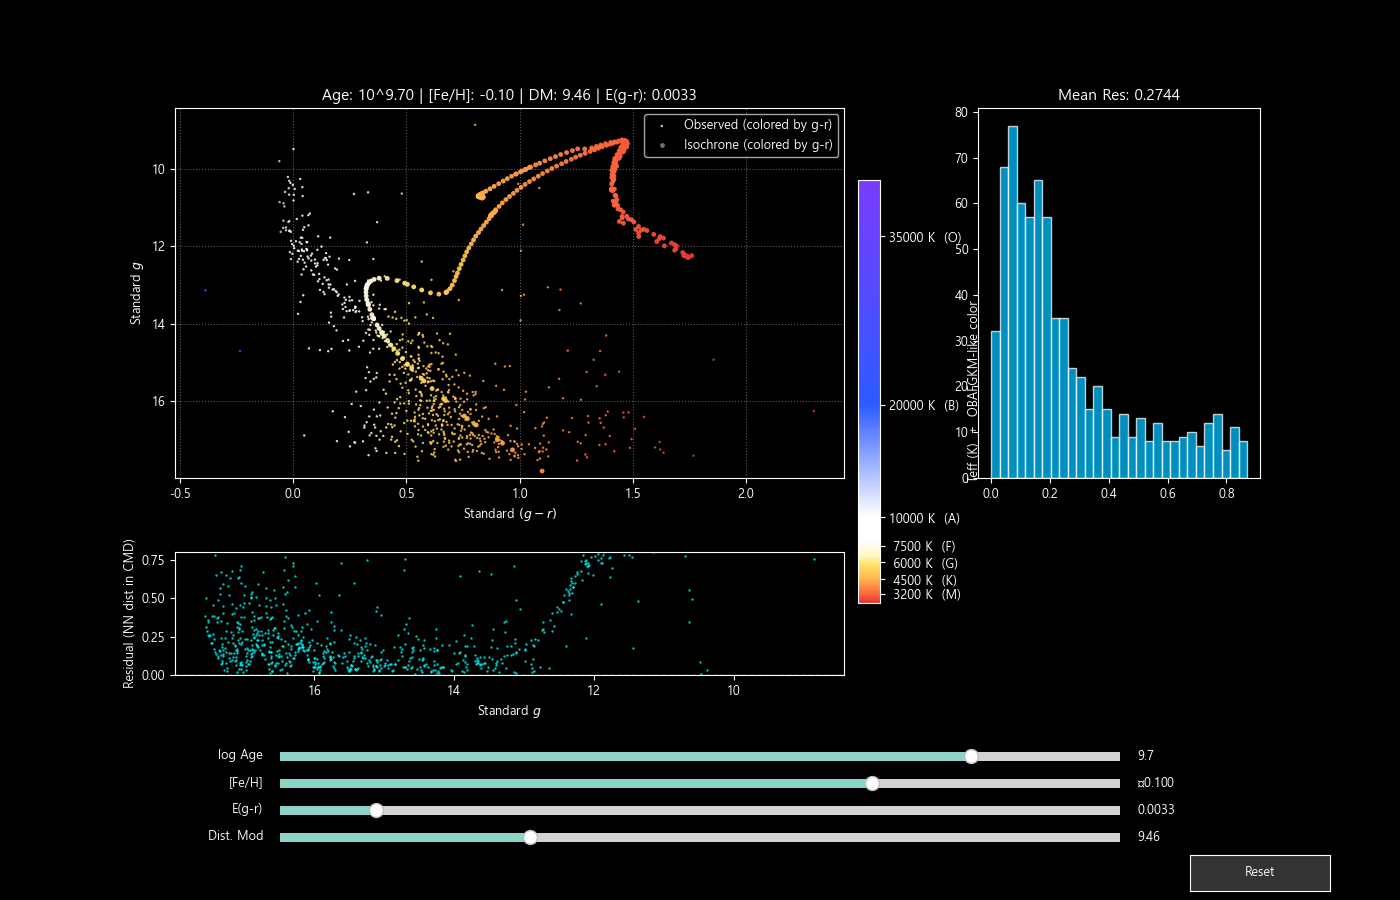

In [ ]:
# === Cell 16: Isochrone fitting (g-r 색지수 -> OBAFGKM 스타일 색맵핑) + 검은 배경 ===

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.spatial import cKDTree

# -----------------------
# 0) Dark background
# -----------------------
plt.style.use("dark_background")
plt.rcParams['axes.unicode_minus'] = False

# -----------------------
# 1) OBAFGKM 스타일 colormap (Teff 기반, 10000K=흰색) + g-r -> Teff 매핑
# -----------------------
TEFF_VMIN = 2400.0
TEFF_VMAX = 40000.0
OB_NORM = Normalize(vmin=TEFF_VMIN, vmax=TEFF_VMAX, clip=True)

# 빨강(저온) -> 주황/노랑 -> 흰색(≈10000K) -> 파랑 -> 보라(고온)
_teff_anchors = [
    (2400,  "#E53935"),
    (3200,  "#FF6A3D"),
    (4500,  "#FFB84D"),
    (5800,  "#FFE36A"),
    (6500,  "#FFF6C7"),
    (8000,  "#FFFFFF"),
    (10000, "#FFFFFF"),  # ★ 10000K=흰색
    (20000, "#2D5BFF"),
    (40000, "#7A3CFF"),
]
_teff_anchors = sorted(_teff_anchors, key=lambda x: x[0])
_pos = [(t - TEFF_VMIN) / (TEFF_VMAX - TEFF_VMIN) for t, _ in _teff_anchors]
_pos[0] = 0.0
_pos[-1] = 1.0

OB_CMAP = LinearSegmentedColormap.from_list(
    "obafgkm_like",
    list(zip(_pos, [c for _, c in _teff_anchors])),
    N=256
)
OB_CMAP.set_bad("#777777")

# g-r -> Teff (시각화용 앵커; 단순/안정적으로)
_GR_X = np.array([-0.40, -0.20,  0.00, 0.30, 0.45, 0.80, 1.40, 1.80], float)
_GR_T = np.array([35000, 20000, 10000,  7500,  6000,  4500,  3200,  2400], float)

def teff_from_gr(gr):
    gr = np.asarray(gr, float)
    t = np.interp(gr, _GR_X, _GR_T)
    return np.clip(t, TEFF_VMIN, TEFF_VMAX)

# colorbar tick (온도 + 분광형)
_OB_TICKS = [(35000,"O"), (20000,"B"), (10000,"A"), (7500,"F"), (6000,"G"), (4500,"K"), (3200,"M")]
CB_TICKS = [t for t, _ in _OB_TICKS]
CB_LABS  = [f"{t:>5d} K  ({cls})" for t, cls in _OB_TICKS]

# -----------------------
# 2) 데이터 로드
# -----------------------
iso_file_path = r'C:\Users\bmffr\Desktop\Result\CMD\iso_data.dat'
iso_raw = np.genfromtxt(iso_file_path, comments='#')
iso_raw = iso_raw[~np.isnan(iso_raw).any(axis=1)]

available_ages = np.unique(iso_raw[:, 2])
available_mhs  = np.unique(iso_raw[:, 1])

# df_out 필요
obs_g  = df_out["mag_std_g"].to_numpy(float)
obs_r  = df_out["mag_std_r"].to_numpy(float)
obs_gr = obs_g - obs_r

mask = np.isfinite(obs_g) & np.isfinite(obs_gr)
obs_g, obs_gr = obs_g[mask], obs_gr[mask]
obs_pts = np.c_[obs_gr, obs_g]
obs_teff = teff_from_gr(obs_gr)

# -----------------------
# 3) 레이아웃
# -----------------------
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(
    2, 2,
    width_ratios=[2.5, 1],
    height_ratios=[3, 1],
    hspace=0.3, wspace=0.2
)

ax_cmd   = fig.add_subplot(gs[0, 0])
ax_hist  = fig.add_subplot(gs[0, 1])
ax_res_g = fig.add_subplot(gs[1, 0])

plt.subplots_adjust(bottom=0.25)

# 배경 확실히 블랙
fig.patch.set_facecolor("black")
for ax in (ax_cmd, ax_hist, ax_res_g):
    ax.set_facecolor("black")
    for sp in ax.spines.values():
        sp.set_color("white")
    ax.tick_params(colors="white")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.title.set_color("white")

# (A) CMD: 관측 데이터(색=Teff(g-r))
sc_obs = ax_cmd.scatter(
    obs_gr, obs_g,
    s=3, alpha=0.85, linewidths=0,
    c=obs_teff, cmap=OB_CMAP, norm=OB_NORM,
    label="Observed (colored by g-r)"
)

# (A) Isochrone: 초기 placeholder (나중에 set_offsets + set_array)
sc_iso = ax_cmd.scatter(
    [np.nan], [np.nan],
    s=12, alpha=0.95, linewidths=0,
    c=[np.nan], cmap=OB_CMAP, norm=OB_NORM,
    label="Isochrone (colored by g-r)",
    zorder=6
)

ax_cmd.invert_yaxis()
ax_cmd.set_xlabel('Standard $(g - r)$')
ax_cmd.set_ylabel('Standard $g$')
ax_cmd.grid(True, linestyle=':', alpha=0.35)
ax_cmd.legend(loc='upper right')

# (B) 잔차 산점도
res_scat = ax_res_g.scatter([], [], s=3, alpha=0.75, linewidths=0, color="cyan")
ax_res_g.axhline(0, color='white', lw=1, ls='--', alpha=0.6)
ax_res_g.set_xlabel('Standard $g$')
ax_res_g.set_ylabel('Residual (NN dist in CMD)')

# (C) Colorbar (Teff)
_sm = mpl.cm.ScalarMappable(norm=OB_NORM, cmap=OB_CMAP)
_sm.set_array([])
cbar = fig.colorbar(_sm, ax=[ax_cmd, ax_res_g], fraction=0.03, pad=0.02)
cbar.set_label("Teff (K)  +  OBAFGKM-like color", color="white")
cbar.set_ticks(CB_TICKS)
cbar.set_ticklabels(CB_LABS)
cbar.ax.tick_params(colors="white")
for sp in cbar.ax.spines.values():
    sp.set_color("white")

# -----------------------
# 4) 핵심 함수
# -----------------------
def get_iso_points(age, mh, h_shift, v_shift):
    m = (iso_raw[:, 2] == age) & (iso_raw[:, 1] == mh)
    filtered = iso_raw[m]
    if len(filtered) == 0:
        return np.array([]), np.array([])
    # 사용자 원 코드 유지 (컬럼 29/30 사용)
    g_model  = filtered[:, 29] + v_shift
    gr_model = (filtered[:, 29] - filtered[:, 30]) + h_shift
    return gr_model, g_model

def _style_axis_dark(ax):
    ax.set_facecolor("black")
    for sp in ax.spines.values():
        sp.set_color("white")
    ax.tick_params(colors="white")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.title.set_color("white")

def update(val):
    age, mh = s_age.val, s_mh.val
    h_s, v_s = s_hshift.val, s_vshift.val

    new_gr, new_g = get_iso_points(age, mh, h_s, v_s)

    # Isochrone scatter 업데이트 (+ 색=Teff(g-r))
    if len(new_gr) > 0:
        iso_teff = teff_from_gr(new_gr)
        sc_iso.set_offsets(np.c_[new_gr, new_g])
        sc_iso.set_array(iso_teff)
    else:
        sc_iso.set_offsets(np.c_[[np.nan], [np.nan]].T)
        sc_iso.set_array(np.array([np.nan]))

    # Residual / hist
    if len(new_gr) > 0:
        iso_pts = np.c_[new_gr, new_g]
        tree = cKDTree(iso_pts)
        dist, _ = tree.query(obs_pts)

        res_scat.set_offsets(np.c_[obs_g, dist])

        # x축을 "g" 축 범위에 맞추고 싶다면 CMD의 y-lim(뒤집힌 값)을 그대로 사용
        ax_res_g.set_xlim(ax_cmd.get_ylim())  # (의도 유지)
        ax_res_g.set_ylim(0, np.percentile(dist, 95))

        ax_hist.clear()
        _style_axis_dark(ax_hist)
        hi = np.percentile(dist, 98)
        ax_hist.hist(dist, bins=30, range=(0, hi), color='deepskyblue', edgecolor='white', alpha=0.75)
        ax_hist.set_title(f"Mean Res: {np.mean(dist):.4f}", color="white")
    else:
        ax_hist.clear()
        _style_axis_dark(ax_hist)
        ax_hist.set_title("No isochrone points", color="white")

    ax_cmd.set_title(f"Age: 10^{age:.2f} | [Fe/H]: {mh:.2f} | DM: {v_s:.2f} | E(g-r): {h_s:.4f}", color="white")
    fig.canvas.draw_idle()

# -----------------------
# 5) 슬라이더 (검은 배경용)
# -----------------------
ax_color = '#222222'
s_age = Slider(plt.axes([0.2, 0.15, 0.6, 0.02], facecolor=ax_color), 'log Age',
               available_ages.min(), available_ages.max(), valinit=9.7, valstep=available_ages)
s_mh = Slider(plt.axes([0.2, 0.12, 0.6, 0.02], facecolor=ax_color), '[Fe/H]',
              available_mhs.min(), available_mhs.max(), valinit=-0.1, valstep=available_mhs)

s_hshift = Slider(plt.axes([0.2, 0.09, 0.6, 0.02], facecolor=ax_color), 'E(g-r)',
                  -0.1, 0.8, valinit=0.0033, valstep=0.0001)
s_vshift = Slider(plt.axes([0.2, 0.06, 0.6, 0.02], facecolor=ax_color), 'Dist. Mod',
                  5.0, 20.0, valinit=9.46, valstep=0.01)

# 슬라이더 글씨 흰색
for s in (s_age, s_mh, s_hshift, s_vshift):
    s.label.set_color("white")
    s.valtext.set_color("white")

s_age.on_changed(update); s_mh.on_changed(update)
s_hshift.on_changed(update); s_vshift.on_changed(update)

# Reset 버튼
resetax = plt.axes([0.85, 0.01, 0.1, 0.04], facecolor="#111111")
button = Button(resetax, 'Reset', color='#333333', hovercolor='#444444')
button.label.set_color("white")

def reset(event):
    s_age.reset(); s_mh.reset(); s_hshift.reset(); s_vshift.reset()

button.on_clicked(reset)

update(None)
plt.show()
